In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import pickle
import mlflow
import time
import logging

import optuna
import optuna.visualization as vis

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Scalers
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE, ADASYN

# Metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, auc, roc_curve, precision_recall_curve, f1_score, confusion_matrix, balanced_accuracy_score, cohen_kappa_score, log_loss 

# Model
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Model Selection - LightGBM

## 1. Load Data

In [211]:
attributes = pd.read_csv("data/btc_price_data_1_year_attributes.csv")
attributes.set_index('timestamp', inplace=True, drop = True)
attributes

,open,high,low,close,volume,month,day,weekday,hour,hour_sin,...,lag_47,lag_56,RSI,EMA12,EMA26,MACD,Signal_Line,SMA,EMA,future_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:56:00,34524.12,34549.26,34541.45,34524.49,31.117144,11,1,2,0,0.000000,...,34619.47,34667.88,47.431310,34542.664324,34556.581568,-13.917244,-12.759288,34553.5310,34550.874620,0.000377
2023-11-01 00:57:00,34524.13,34537.66,34524.52,34524.62,7.349951,11,1,2,0,0.000000,...,34603.20,34642.82,48.755135,34539.888274,34554.214045,-14.325771,-13.072585,34549.4505,34548.374180,-0.005330
2023-11-01 00:58:00,34519.85,34531.41,34527.81,34522.78,5.134526,11,1,2,0,0.000000,...,34602.26,34656.56,48.265451,34537.256232,34551.885597,-14.629365,-13.383941,34545.2715,34545.936639,0.025461
2023-11-01 00:59:00,34521.42,34531.98,34521.42,34531.57,4.310564,11,1,2,0,0.000000,...,34623.10,34629.34,41.702541,34536.381427,34550.380738,-13.999311,-13.507015,34542.0065,34544.568387,0.021053
2023-11-01 01:00:00,34531.46,34547.87,34532.22,34538.84,1.327905,11,1,2,1,0.258819,...,34611.54,34622.27,48.144440,34536.759669,34549.525868,-12.766199,-13.358852,34540.4225,34544.022827,0.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:55:00,70248.97,70264.97,70248.98,70248.97,1.604753,10,31,3,23,-0.258819,...,70345.60,70383.13,15.731750,70316.514762,70363.992465,-47.477702,-35.505422,70367.7305,70348.638181,-0.014534
2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,10,31,3,23,-0.258819,...,70329.38,70461.07,20.028025,70304.552491,70354.715986,-50.163495,-38.437037,70352.5490,70338.173592,-0.007859
2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,10,31,3,23,-0.258819,...,70317.72,70470.15,14.761536,70293.581339,70345.717765,-52.136426,-41.176915,70338.1685,70328.179916,-0.036251


In [212]:
target_data = pd.read_csv("data/btc_price_data_1_year_target.csv")
target_data.set_index('timestamp', inplace=True, drop = True)
target = target_data['target']
target

timestamp
2023-11-01 00:56:00    0
2023-11-01 00:57:00    0
2023-11-01 00:58:00    0
2023-11-01 00:59:00    0
2023-11-01 01:00:00    0
                      ..
2024-10-31 23:55:00    0
2024-10-31 23:56:00    0
2024-10-31 23:57:00    0
2024-10-31 23:58:00    0
2024-10-31 23:59:00    0
Name: target, Length: 528575, dtype: int64

## 2. Data Splitting

In [213]:
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False,
    random_state = 42
)

In [214]:
attributes_train.shape, attributes_test.shape

((422860, 52), (105715, 52))

In [215]:
target_train.shape, target_test.shape

((422860,), (105715,))

## 3. Oversampling- Address Class Imbalance

**SMOTE** (Synthetic Minority Oversampling Technique) and **ADASYN** (Adaptive Synthetic Sampling) are two popular oversampling techniques for addressing class imbalance in datasets. Both generate synthetic samples for the minority class to balance the dataset, but they differ in how they create these samples. Below is a detailed comparison to help you understand their strengths and use cases.

##### **Core Approach**

###### **SMOTE**
- **How it works**: 
  - For each minority class sample, SMOTE selects one or more nearest neighbors.
  - It creates synthetic samples by interpolating between the sample and its neighbors.
  - The interpolation is linear, producing samples along the line segments between the selected points.
- **Focus**: Generates synthetic samples evenly across the minority class.

###### **ADASYN**
- **How it works**: 
  - ADASYN builds on SMOTE by focusing more on the minority class samples that are harder to classify.
  - It identifies minority samples near the decision boundary (using k-nearest neighbors) and generates more synthetic samples in these regions.
  - The number of synthetic samples per instance is proportional to the local difficulty (measured by the density of majority class samples nearby).
- **Focus**: Creates samples adaptively, concentrating on areas where the minority class is harder to learn.

---

##### **Key Differences**

| Feature                     | **SMOTE**                                  | **ADASYN**                                      |
|-----------------------------|---------------------------------------------|------------------------------------------------|
| **Generation Strategy**     | Uniformly interpolates between samples.     | Focuses on generating samples near decision boundaries. |
| **Focus**                   | Balances the dataset evenly.               | Adaptive oversampling based on instance difficulty.      |
| **Synthetic Sample Location** | Can lead to over-generalization.           | More targeted and refined near complex regions. |
| **Computational Complexity**| Relatively lower computational cost.        | Slightly higher due to the adaptive nature.     |
| **Risk of Overfitting**     | Higher risk if the boundary is noisy.       | Reduced overfitting near decision boundaries.   |

---

##### **Strengths**

###### **SMOTE**
- **Advantages**:
  - Simple and effective for moderately imbalanced datasets.
  - Maintains the distribution of the minority class.
- **When to Use**:
  - When the imbalance is not extreme.
  - When you want a more uniform oversampling approach.

###### **ADASYN**
- **Advantages**:
  - Focuses on challenging regions, improving the model's ability to classify difficult cases.
  - Reduces the risk of overgeneralization by targeting specific areas.
- **When to Use**:
  - For highly imbalanced datasets.
  - When the minority class has complex boundaries or is under-represented in critical regions.

---

##### **Limitations**

###### **SMOTE**
- Does not consider the difficulty of classification.
- Can create synthetic samples in regions that are already well-represented, potentially leading to redundancy.
- May cause overfitting in noisy datasets.

###### **ADASYN**
- Slightly more computationally expensive than SMOTE.
- If the data is very noisy, it might generate samples in misleading or non-representative regions.


### 3.1. SMOTE (Synthetic Minority Oversampling Technique)

In [216]:
def create_oversampling_smote(attributes_train, target_train):
    """
    Apply SMOTE(Synthetic Minority Oversampling Technique) to generate synthetic examples for minority classes
    """
    smote = SMOTE(random_state=42)
    attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (SMOTE):", np.bincount(target_train))
    print("Balanced Class Distribution (SMOTE):", np.bincount(target_train_smote))

    return attributes_train_smote, target_train_smote

### 3.2. ADASYN (Adaptive Synthetic Sampling)

In [217]:
def create_oversampling_adasyn(attributes_train, target_train):
    """
    Apply ADASYN(Adaptive Synthetic Sampling) to generate synthetic examples for minority classes
    """
    adasyn = ADASYN(random_state=42)
    attributes_train_adasyn, target_train_adasyn = adasyn.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (ADASYN):", np.bincount(target_train))
    print("Balanced Class Distribution (ADASYN):", np.bincount(target_train_adasyn))

    return attributes_train_adasyn, target_train_adasyn

### 3.3. Set Oversampling Type

In [218]:
def create_oversampling(attributes_train, target_train, oversampling_type = None):
    """
    Apply 'oversampling_type' to generate synthetic examples for minority classes
    """
    if oversampling_type == 'smote':
        return create_oversampling_smote(attributes_train, target_train)
    elif oversampling_type == 'adasyn':
        return create_oversampling_adasyn(attributes_train, target_train)
    else:
        print(f"Invalid oversampling type: [{oversampling_type}]")
        return attributes_train, target_train

## 4. Feature Importance Regularization

LightGBM can overfit when unimportant features dominate. Regularization can be achieved by the removing irrelevant features (feature selection).

### 4.1. Remove Low Importance Features

After training the model, identify and remove features with low importance.

In [219]:
def plot_feature_importance(model, importances, feature_names, title = 'Feature Importance'):
    # Feature importances
    # importances = model.feature_importances_
    # feature_names = attributes_train.columns
    sorted_indices = importances.argsort()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.title(title)
    plt.show()

In [220]:
def remove_low_important_features(model, attributes, attributes_type):
    importances = model.feature_importances_
    feature_names = attributes.columns
    
    # Plot the importances
    plot_feature_importance(model, importances, feature_names, title = f'Feature Importance({attributes_type}) before drop')
    
    # Feature importance
    feature_importances = pd.DataFrame({
        'Feature': attributes.columns,
        'Importance': model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    # Drop features with low importance
    low_importance_features = feature_importances[feature_importances['Importance'] < 0.01]['Feature']
    attributes_reg = attributes.drop(columns=low_importance_features)

    print('attributes.shape before drop: ' , attributes.shape)
    print('attributes.shape after the drop: ', attributes_reg.shape)

    # Plot the importances after the drop
    # plot_feature_importance(model, high_importance_features.Importance, high_importance_features.Feature, title = 'Feature Importance after the drop')

    return attributes_reg

In [221]:
# attributes_reg = remove_low_important_features(lgb_model, attributes, 'train')

## 5. Evaluate the Model

**ROC-AUC score:**
   - Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes (1 and 2):

**Precision-Recall Curves:**
   - Precision-recall curves are often more informative for imbalanced datasets. They focus on the trade-off between precision and recall for each class.

In [222]:
def plot_classification_report_multiclass(model, attributes_test_data, target_test_data): 
    # Predictions
    target_pred_data = model.predict(attributes_test_data, verbose=-1)

    # Calculate F1-score (weighted)
    f1 = f1_score(target_test_data, target_pred_data, average='macro')

    print(f"\nF1 score (macro) : [{f1}]")
    
    # Classification Report
    print("\nClassification report: ")
    print(classification_report(target_test_data, target_pred_data))

In [223]:
# LIghtLGB Feature Importance
def plot_lgb_importance(lgb_model):
    lgb.plot_importance(lgb_model, max_num_features=20, importance_type = 'split', title = 'Feature Importance (split)')
    lgb.plot_importance(lgb_model, max_num_features=20, importance_type = 'gain', title = 'Feature Importance (gain)')
    plt.show()

In [224]:
def plot_confusion_matrix(model, attributes_test_data, target_test_data):
    # Predictions
    target_pred_data = model.predict(attributes_test_data, verbose=-1)
    
    # Confusion Matrix Computation
    cm = confusion_matrix(target_test_data, target_pred_data)
    #print("Confusion Matrix:\n", cm)
    
    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], 
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [225]:
def plot_classification_error(model, eval_metric='mlogloss'):
    # Retrieve evaluation results
    eval_results = model.evals_result_
    
    # Plot classification error
    plt.figure(figsize=(10, 6))
    plt.plot(eval_results['training'][eval_metric], label='Train Error')
    plt.plot(eval_results['valid_1'][eval_metric], label='Validation Error')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Classification Error')
    plt.title(f"Classification Error ({eval_metric}) During Training ")
    plt.legend()
    plt.grid(True)
    plt.show()

In [226]:
def plot_roc_curve_multiclass(model,target_test_data, classes):
    print(f"\nCalculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes")
    
    # Binarize labels for one-vs-rest (multiclass ROC-AUC)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities

    # ROC-AUC for multiclass
    roc_auc = roc_auc_score(target_test, target_pred_prob, multi_class='ovr') # 'ovr' (one-vs-rest), 'ovo'-(one-vs-one)
    print(f"\nROC-AUC Score: {roc_auc}")
    
    # Compute ROC-AUC for each class
    roc_auc_per_class = roc_auc_score(target_test_binarized, target_pred_prob, average=None)
    print(f"ROC-AUC per class {classes}:", roc_auc_per_class)

    # Compute ROC curve and ROC-AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Configure the plot
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [227]:
def plot_precision_recal_curve_multiclass(model,target_test_data, classes):
    # Binarize labels for one-vs-rest (multiclass precision-recall)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities
    
    # Plot precision-recall curves for each class
    for i in range(3):  # Assuming 3 classes (0, 1, 2)
        precision, recall, _ = precision_recall_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [228]:
def plot_feature_importance(model):
    # Feature importances
    importances = model.feature_importances_
    feature_names = attributes_train.columns
    sorted_indices = importances.argsort()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.title('Feature Importance')
    plt.show()

In [229]:
def evaluate_model(model, attributes_test_data, target_test_data):
    classes = [0, 1, 2]
    
    plot_classification_report_multiclass(model, attributes_test_data, target_test_data)
    plot_lgb_importance(model)
    plot_confusion_matrix(model, attributes_test_data, target_test_data)
    plot_classification_error(model, eval_metric='multi_logloss')
    # plot_classification_error(model, eval_metric='merror')
    plot_roc_curve_multiclass(model, target_test_data, classes)
    plot_precision_recal_curve_multiclass(model, target_test_data, classes)

In [230]:
# evaluate_model(lgb_model, attributes_test, target_test)

## 6. Hyperparameter Tuning

We will use **Optuna** for the hyperparameter tuning.

In [231]:
initial_forest_model_parameters = {
    'random_state': 42,
    'n_jobs': 10
}

### 6.1. Optuna

#### 6.1.1. Define the Objective Function

The objective function tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [232]:
def fit_model_with_timeseries_split(model_params, attributes_train, target_train):
    """
    Cross-Validate with TimeSeriesSplit - using TimeSeriesSplit on the training data to ensure 
    the model performs consistently across different time windows.
    """
     # Metrics collection
    scores = {
        #  The F1 score is the harmonic mean of precision and recall. The 'macro' version calculates the F1 score 
        #  for each class independently and then averages them, giving equal weight to all classes, regardless of their size
        'f1_macro_scores' : [],
        # Balanced accuracy is the average of recall obtained on each class. It accounts for class imbalance 
        # by giving equal weight to each class
        'balanced_acc_scores' : [],
        'f1_weighted_scores' : [],
        'kappa_scores' : [],
        'log_loss_scores' : [],
        'roc_auc_scores' : [],
    }

    # Use TimeSeriesSplit for time series cross-validation
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes_train)):
        attributes_train_fold, attributes_val_fold = attributes_train.iloc[train_idx], attributes_train.iloc[val_idx]
        target_train_fold, target_val_fold = target_train.iloc[train_idx], target_train.iloc[val_idx]

        # Apply oversampling to handle class imbalance in training data
        attributes_train_fold, target_train_fold = create_oversampling(
            attributes_train_fold,
            target_train_fold, 
            oversampling_type
        )

        # Train LightGB model
        lgb_model_split = LGBMClassifier(**model_params)
        lgb_model_split.fit(
            attributes_train_fold,
                  target_train_fold,
                  eval_set=[(attributes_val_fold, target_val_fold)],
                  eval_metric="multi_logloss",
                  callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(period=10)  # Optional: control logging
                  ])

        # Predictions and probabilities
        target_val_pred = lgb_model_split.predict(attributes_val_fold)
        target_val_proba = lgb_model_split.predict_proba(attributes_val_fold)
        
        # Calculate metrics for this fold
        scores['f1_macro_scores'].append(f1_score(target_val_fold, target_val_pred, average='macro'))
        scores['f1_weighted_scores'].append(f1_score(target_val_fold, target_val_pred, average='weighted'))
        scores['balanced_acc_scores'].append(balanced_accuracy_score(target_val_fold, target_val_pred))
        scores['kappa_scores'].append(cohen_kappa_score(target_val_fold, target_val_pred))
        scores['log_loss_scores'].append(log_loss(target_val_fold, target_val_proba))
        scores['roc_auc_scores'].append(roc_auc_score(target_val_fold, target_val_proba, multi_class='ovr'))

        print(f"\nFold {fold+1} Classification Report")
        print(classification_report(target_val_fold, target_val_pred))

    # Aggregate metrics across folds
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}

    print("\nCross-Validated Metrics:")
    print(f"F1-Score (Macro): {avg_scores['f1_macro_scores']:.4f} ± {np.std(scores['f1_macro_scores']):.4f}")
    print(f"F1-Score (Weighted): {avg_scores['f1_weighted_scores']:.4f} ± {np.std(scores['f1_weighted_scores']):.4f}")
    print(f"Balanced Accuracy: {avg_scores['balanced_acc_scores']:.4f} ± {np.std(scores['balanced_acc_scores']):.4f}")
    print(f"Cohen's Kappa: {avg_scores['kappa_scores']:.4f} ± {np.std(scores['kappa_scores']):.4f}")
    print(f"Log Loss: {avg_scores['log_loss_scores']:.4f} ± {np.std(scores['log_loss_scores']):.4f}")
    print(f"ROC-AUC: {avg_scores['roc_auc_scores']:.4f} ± {np.std(scores['roc_auc_scores']):.4f}")

    return avg_scores

In [233]:
def objective(trial, model_type, oversampling_type = None, n_splits = 5):
    print(f"\nStart trial:[{trial.number}] for model:[{model_type}] with time series cross validation, oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")

    # Define the hyperparameters to tune
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart']), # 'gbdt', 'dart'
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0, log=True),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'class_weight' : 'balanced',
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),  # Variable n_estimators
        # "n_estimators": trial.suggest_int("n_estimators", 50, 1000),  # Variable n_estimators
        'n_jobs': 10,
        'random_state': 42
    }
    
    # Train the model with the 'params'
    avg_scores = fit_model_with_timeseries_split(params, attributes_train, target_train)

    # Log all scores to Optuna
    trial.set_user_attr("scores", avg_scores)
    
    # Return the mean F1-macro across all folds
    return avg_scores['f1_macro_scores']


#### 6.1.2. Run the Optuna Study in MLFlow

Set some params needed for the Optuna study:

In [240]:
# Set model type
model_type = 'LightGBM'

# Set oversampling type
oversampling_type = 'adasyn'

n_trials = 50 # default : 50
n_splits = 5 # default : 5
posfix = '_DART_balanced_weight_try_1'
mlflow_run_name = f"BTC_{model_type}_Optuna_{oversampling_type}_Trials_{n_trials}{posfix}"

print("Oversampling Type:", oversampling_type)
print("n_trials:", n_trials)
print("n_splits:", n_splits)
print("mlflow_run_name:", mlflow_run_name)

Oversampling Type: smote
n_trials: 50
n_splits: 5
mlflow_run_name: BTC_LightGBM_Optuna_smote_Trials_50_DART_balanced_weight_try_1


In [241]:
# Create a MLFlow experiment
experiment_name = f"BTC_{model_type}_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

In [242]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/03.Machine%20Learning-September-2024/Exam/02.Exam-Project/01.Repo/Algorithmic-Trading-Bot/Notebook/mlruns/290176675589735609', creation_time=1733082676435, experiment_id='290176675589735609', last_update_time=1733082676435, lifecycle_stage='active', name='BTC_LightGBM_Optuna', tags={}>

Start an **MLFlow** run using **Optuna** to tune the hyperparameters of the **LGBMClassifier**:

In [243]:
def start_mlflow_run(run_name):
    with mlflow.start_run(run_name = run_name):
        # Suppress only warning logs from LightGBM
        logging.getLogger('lightgbm').setLevel(logging.ERROR)
    
        mlflow.log_param("train size", len(attributes_train))
        mlflow.log_param("test size", len(attributes_test))
    
        # Create a Optuna study and optimize
        study = optuna.create_study(direction = 'maximize')
        study.optimize(
            partial(objective, model_type = model_type, oversampling_type = oversampling_type, n_splits = n_splits),
            n_trials = n_trials
        )
    
        ################################################################################
        # log best params
        ################################################################################
        # Get the best trial
        best_trial = study.best_trial
    
        # Output the best hyperparameters
        print("\n\nBest Parameters:", study.best_params)
        print("\nBest F1-macro-score-fine-tuning:", study.best_value)
        print("\nBest Trial:", best_trial)
    
        # Access the parameters of the best trial
        print("\n\nBest Trial Parameters:")
        print(f"Trial {best_trial.number}:")
        print(f"Parameters: {best_trial.params}")
        
       # Access the scores stored in user attributes
        print("\nBest Trial Scores:")
        for metric, value in best_trial.user_attrs['scores'].items():
            print(f"{metric}: {value:.4f}")
            mlflow.log_metric(metric, value)
    
        ################################################################################
        # END: log best params
        ################################################################################
        mlflow.log_metric("best_F1-macro_score_fine_tuning", study.best_value)
        
        # Train best model
        merged_params = initial_forest_model_parameters | study.best_params
    
        print("\nmerged_params:", merged_params)
        mlflow.log_params(merged_params)
    
        # # Removing irrelevant features (feature selection)
        # attributes_train_reg = remove_low_important_features(rf_model, attributes_train, attributes_type = 'train')
        # attributes_test_reg = remove_low_important_features(rf_model, attributes_test, attributes_type = 'test')
    
        # Train the model with the best params and TimeSeriesSplit
        avg_scores = fit_model_with_timeseries_split(merged_params, attributes_train, target_train)
    
        print(f"F1-Score(Macro) with Best Params and TimeSplit: {avg_scores['f1_macro_scores']:.4f}")
        # Access the scores stored in user attributes
        print("\nScores with Best Params and TimeSplit:")
        for metric, value in avg_scores.items():
            print(f"{metric}: {value:.4f}")
            mlflow.log_metric(metric, value)
    
        # Use evaluation metrics
        eval_set = [(attributes_train, target_train), (attributes_test, target_test)]
    
        # Train the final model on all available data (training + test)
        lgb_model = LGBMClassifier(**merged_params)
        lgb_model.fit(attributes_train,
                      target_train,
                      eval_set= eval_set,
                      callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(period=10)  # Optional: control logging
                      ])
        
        # Validate
        target_train_pred = lgb_model.predict(attributes_train)
        target_test_pred = lgb_model.predict(attributes_test)
        
        # Validate
        classification_train_report = classification_report(target_train, target_train_pred)
        classification_test_report = classification_report(target_test, target_test_pred)
       
        print(f"classification_train_report_{model_type}_{oversampling_type}: ", classification_train_report)
        print(f"classification_test_report_{model_type}_{oversampling_type}: ", classification_test_report)
    
        # F1-macro score after the final model tarining on all available data (training + test)
        f1_macro_score = f1_score(target_test, target_test_pred, average='macro')
        print(f"F1-Score (Macro) final training: {f1_macro_score:.4f}")
        
        mlflow.log_metric("F1-macro-score-final", f1_macro_score)
    
        # Log metrics
        mlflow.log_metric(f"train_accuracy_{model_type}_{oversampling_type}", lgb_model.score(attributes_train, target_train))
        mlflow.log_metric(f"test_accuracy_{model_type}_{oversampling_type}", lgb_model.score(attributes_test, target_test))
    
        with open(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt",  "w") as f:
            f.write(classification_train_report)
        with open(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt",  "w") as f:
            f.write(classification_test_report)
            
        pickle.dump(lgb_model, open(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl", "wb"))
    
        # Log artifacts
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl")
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt")
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt")
    
        # Visualize optimization history
        optimization_history_plot = vis.plot_optimization_history(study)
        # Visualize parameter importance
        param_importance_plot = vis.plot_param_importances(study)
        # Visualize hyperparameter values
        hyperparameter_values_plot = vis.plot_parallel_coordinate(study)
    
        # Save visualizations to files
        optimization_history_plot.write_html(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
        param_importance_plot.write_html(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
        hyperparameter_values_plot.write_html(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")
    
        # Log visualization MLflow artifacts
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")
        
        evaluate_model(lgb_model, attributes_test, target_test)

[I 2024-12-03 23:14:54,125] A new study created in memory with name: no-name-8ecc1f8b-3228-4637-ad2b-b2636dd44c51



Start trial:[0] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.927027
[20]	valid_0's multi_logloss: 0.833423
[30]	valid_0's multi_logloss: 0.784639
[40]	valid_0's multi_logloss: 0.703637
[50]	valid_0's multi_logloss: 0.665307
[60]	valid_0's multi_logloss: 0.622759
[70]	valid_0's multi_logloss: 0.605194
[80]	valid_0's multi_logloss: 0.582715
[90]	valid_0's multi_logloss: 0.566114
[100]	valid_0's multi_logloss: 0.533164
[110]	valid_0's multi_logloss: 0.530153
[120]	valid_0's multi_logloss: 0.528814
[130]	valid_0's multi_logloss: 0.524374
[140]	valid_0's multi_logloss: 0.514004
[150]	valid_0's multi_logloss: 0.480607
[160]	valid_0's multi_logloss: 0.493402
[170]	valid_0's multi_logloss: 0.476904
[180]	valid_0's multi_logloss: 0.455603
[190]	valid_0's multi_logloss: 0.447467
[200]	valid_0's multi_logloss: 0.446387
[210]	valid_0's multi_logloss: 0.445098
[220]	valid_0's multi_logloss: 0.427399
[230]	valid_0's multi_logloss: 0.401627
[240]	valid_0's multi_logloss: 0.398533
[250]	valid_0's multi_logloss: 0.390448
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.950614
[20]	valid_0's multi_logloss: 0.872726
[30]	valid_0's multi_logloss: 0.823839
[40]	valid_0's multi_logloss: 0.750988
[50]	valid_0's multi_logloss: 0.7104
[60]	valid_0's multi_logloss: 0.66633
[70]	valid_0's multi_logloss: 0.649932
[80]	valid_0's multi_logloss: 0.625727
[90]	valid_0's multi_logloss: 0.61033
[100]	valid_0's multi_logloss: 0.575494
[110]	valid_0's multi_logloss: 0.57166
[120]	valid_0's multi_logloss: 0.568517
[130]	valid_0's multi_logloss: 0.564436
[140]	valid_0's multi_logloss: 0.554315
[150]	valid_0's multi_logloss: 0.520875
[160]	valid_0's multi_logloss: 0.532629
[170]	valid_0's multi_logloss: 0.51536
[180]	valid_0's multi_logloss: 0.495152
[190]	valid_0's multi_logloss: 0.486884
[200]	valid_0's multi_logloss: 0.485822
[210]	valid_0's multi_logloss: 0.48359
[220]	valid_0's multi_logloss: 0.468544
[230]	valid_0's multi_logloss: 0.443335
[240]	valid_0's multi_logloss: 0.439274
[250]	valid_0's multi_logloss: 0.430024
[260]	valid_0's 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.94311
[20]	valid_0's multi_logloss: 0.854407
[30]	valid_0's multi_logloss: 0.807464
[40]	valid_0's multi_logloss: 0.730167
[50]	valid_0's multi_logloss: 0.692991
[60]	valid_0's multi_logloss: 0.650509
[70]	valid_0's multi_logloss: 0.634731
[80]	valid_0's multi_logloss: 0.611785
[90]	valid_0's multi_logloss: 0.596467
[100]	valid_0's multi_logloss: 0.563005
[110]	valid_0's multi_logloss: 0.560424
[120]	valid_0's multi_logloss: 0.558269
[130]	valid_0's multi_logloss: 0.553294
[140]	valid_0's multi_logloss: 0.543509
[150]	valid_0's multi_logloss: 0.51164
[160]	valid_0's multi_logloss: 0.524122
[170]	valid_0's multi_logloss: 0.507005
[180]	valid_0's multi_logloss: 0.489342
[190]	valid_0's multi_logloss: 0.481363
[200]	valid_0's multi_logloss: 0.478276
[210]	valid_0's multi_logloss: 0.476184
[220]	valid_0's multi_logloss: 0.458326
[230]	valid_0's multi_logloss: 0.434795
[240]	valid_0's multi_logloss: 0.431922
[250]	valid_0's multi_logloss: 0.423835
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.919079
[20]	valid_0's multi_logloss: 0.822971
[30]	valid_0's multi_logloss: 0.765099
[40]	valid_0's multi_logloss: 0.679417
[50]	valid_0's multi_logloss: 0.638066
[60]	valid_0's multi_logloss: 0.593641
[70]	valid_0's multi_logloss: 0.576788
[80]	valid_0's multi_logloss: 0.552811
[90]	valid_0's multi_logloss: 0.53428
[100]	valid_0's multi_logloss: 0.502106
[110]	valid_0's multi_logloss: 0.498376
[120]	valid_0's multi_logloss: 0.498597
[130]	valid_0's multi_logloss: 0.493608
[140]	valid_0's multi_logloss: 0.483221
[150]	valid_0's multi_logloss: 0.447173
[160]	valid_0's multi_logloss: 0.461078
[170]	valid_0's multi_logloss: 0.446174
[180]	valid_0's multi_logloss: 0.42182
[190]	valid_0's multi_logloss: 0.415488
[200]	valid_0's multi_logloss: 0.414095
[210]	valid_0's multi_logloss: 0.412208
[220]	valid_0's multi_logloss: 0.394357
[230]	valid_0's multi_logloss: 0.368596
[240]	valid_0's multi_logloss: 0.366093
[250]	valid_0's multi_logloss: 0.356602
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.939602
[20]	valid_0's multi_logloss: 0.851509
[30]	valid_0's multi_logloss: 0.803423
[40]	valid_0's multi_logloss: 0.724603
[50]	valid_0's multi_logloss: 0.685661
[60]	valid_0's multi_logloss: 0.6453
[70]	valid_0's multi_logloss: 0.629103
[80]	valid_0's multi_logloss: 0.605652
[90]	valid_0's multi_logloss: 0.589639
[100]	valid_0's multi_logloss: 0.556993
[110]	valid_0's multi_logloss: 0.554906
[120]	valid_0's multi_logloss: 0.552444
[130]	valid_0's multi_logloss: 0.549006
[140]	valid_0's multi_logloss: 0.537788
[150]	valid_0's multi_logloss: 0.505471
[160]	valid_0's multi_logloss: 0.517443
[170]	valid_0's multi_logloss: 0.501155
[180]	valid_0's multi_logloss: 0.481391
[190]	valid_0's multi_logloss: 0.473921
[200]	valid_0's multi_logloss: 0.472253
[210]	valid_0's multi_logloss: 0.47011
[220]	valid_0's multi_logloss: 0.451331
[230]	valid_0's multi_logloss: 0.425892
[240]	valid_0's multi_logloss: 0.42328
[250]	valid_0's multi_logloss: 0.414452
[260]	valid_0

[I 2024-12-03 23:16:28,940] Trial 0 finished with value: 0.33867646237808235 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1013529339572669, 'num_leaves': 108, 'min_data_in_leaf': 80, 'max_depth': 1, 'feature_fraction': 0.7192682459808165, 'bagging_fraction': 0.5162283968378699, 'bagging_freq': 4, 'lambda_l1': 1.645909538255469, 'lambda_l2': 2.4391463567130155e-05, 'n_estimators': 271}. Best is trial 0 with value: 0.33867646237808235.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     70084
           1       0.03      0.99      0.06       191
           2       0.03      0.99      0.06       201

    accuracy                           0.82     70476
   macro avg       0.35      0.93      0.34     70476
weighted avg       0.99      0.82      0.89     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3387 ± 0.0017
F1-Score (Weighted): 0.8981 ± 0.0067
Balanced Accuracy: 0.9292 ± 0.0068
Cohen's Kappa: 0.0492 ± 0.0011
Log Loss: 0.3880 ± 0.0268
ROC-AUC: 0.9701 ± 0.0028

Start trial:[1] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.328576
[20]	valid_0's multi_logloss: 0.168856
[30]	valid_0's multi_logloss: 0.134888
[40]	valid_0's multi_logloss: 0.0733292
[50]	valid_0's multi_logloss: 0.0548494
[60]	valid_0's multi_logloss: 0.0413474
[70]	valid_0's multi_logloss: 0.0374474
[80]	valid_0's multi_logloss: 0.0326728
[90]	valid_0's multi_logloss: 0.0300116
[100]	valid_0's multi_logloss: 0.0253161
[110]	valid_0's multi_logloss: 0.0254716
[120]	valid_0's multi_logloss: 0.0254208
[130]	valid_0's multi_logloss: 0.0250435
[140]	valid_0's multi_logloss: 0.0239897
[150]	valid_0's multi_logloss: 0.0223261
[160]	valid_0's multi_logloss: 0.022865
[170]	valid_0's multi_logloss: 0.0222741
[180]	valid_0's multi_logloss: 0.0219899
[190]	valid_0's multi_logloss: 0.0221031
[200]	valid_0's multi_logloss: 0.0219557
[210]	valid_0's multi_logloss: 0.0220181
[220]	valid_0's multi_logloss: 0.0223687
[230]	valid_0's multi_logloss: 0.0232833
[240]	valid_0's multi_logloss: 0.0230794
[250]	valid_0's multi_logloss

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.356494
[20]	valid_0's multi_logloss: 0.197992
[30]	valid_0's multi_logloss: 0.159391
[40]	valid_0's multi_logloss: 0.0928448
[50]	valid_0's multi_logloss: 0.0714272
[60]	valid_0's multi_logloss: 0.0539583
[70]	valid_0's multi_logloss: 0.0479579
[80]	valid_0's multi_logloss: 0.0417962
[90]	valid_0's multi_logloss: 0.0386704
[100]	valid_0's multi_logloss: 0.0315908
[110]	valid_0's multi_logloss: 0.0321449
[120]	valid_0's multi_logloss: 0.0321925
[130]	valid_0's multi_logloss: 0.0319683
[140]	valid_0's multi_logloss: 0.0303709
[150]	valid_0's multi_logloss: 0.0264355
[160]	valid_0's multi_logloss: 0.0282442
[170]	valid_0's multi_logloss: 0.0262159
[180]	valid_0's multi_logloss: 0.0247777
[190]	valid_0's multi_logloss: 0.0241933
[200]	valid_0's multi_logloss: 0.0242488
[210]	valid_0's multi_logloss: 0.0240159
[220]	valid_0's multi_logloss: 0.0231733
[230]	valid_0's multi_logloss: 0.0227644
[240]	valid_0's multi_logloss: 0.0226061
[250]	valid_0's multi_loglos

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.355029
[20]	valid_0's multi_logloss: 0.195806
[30]	valid_0's multi_logloss: 0.157306
[40]	valid_0's multi_logloss: 0.0893565
[50]	valid_0's multi_logloss: 0.0684491
[60]	valid_0's multi_logloss: 0.0516611
[70]	valid_0's multi_logloss: 0.0467476
[80]	valid_0's multi_logloss: 0.0412631
[90]	valid_0's multi_logloss: 0.0382392
[100]	valid_0's multi_logloss: 0.0316041
[110]	valid_0's multi_logloss: 0.0318765
[120]	valid_0's multi_logloss: 0.0321127
[130]	valid_0's multi_logloss: 0.0314335
[140]	valid_0's multi_logloss: 0.0296967
[150]	valid_0's multi_logloss: 0.0255876
[160]	valid_0's multi_logloss: 0.0276074
[170]	valid_0's multi_logloss: 0.0256506
[180]	valid_0's multi_logloss: 0.0239945
[190]	valid_0's multi_logloss: 0.0235396
[200]	valid_0's multi_logloss: 0.0235987
[210]	valid_0's multi_logloss: 0.0235827
[220]	valid_0's multi_logloss: 0.022554
[230]	valid_0's multi_logloss: 0.0219111
[240]	valid_0's multi_logloss: 0.021669
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.334241
[20]	valid_0's multi_logloss: 0.176263
[30]	valid_0's multi_logloss: 0.144214
[40]	valid_0's multi_logloss: 0.0807051
[50]	valid_0's multi_logloss: 0.060815
[60]	valid_0's multi_logloss: 0.0451576
[70]	valid_0's multi_logloss: 0.0406493
[80]	valid_0's multi_logloss: 0.035597
[90]	valid_0's multi_logloss: 0.0328509
[100]	valid_0's multi_logloss: 0.0263582
[110]	valid_0's multi_logloss: 0.0265636
[120]	valid_0's multi_logloss: 0.0267213
[130]	valid_0's multi_logloss: 0.0261106
[140]	valid_0's multi_logloss: 0.0244235
[150]	valid_0's multi_logloss: 0.0207817
[160]	valid_0's multi_logloss: 0.0225444
[170]	valid_0's multi_logloss: 0.0208558
[180]	valid_0's multi_logloss: 0.0191188
[190]	valid_0's multi_logloss: 0.0186057
[200]	valid_0's multi_logloss: 0.0186838
[210]	valid_0's multi_logloss: 0.0186014
[220]	valid_0's multi_logloss: 0.0176425
[230]	valid_0's multi_logloss: 0.0168723
[240]	valid_0's multi_logloss: 0.0166874
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.346978
[20]	valid_0's multi_logloss: 0.187834
[30]	valid_0's multi_logloss: 0.152362
[40]	valid_0's multi_logloss: 0.0869315
[50]	valid_0's multi_logloss: 0.0666942
[60]	valid_0's multi_logloss: 0.0502289
[70]	valid_0's multi_logloss: 0.0452944
[80]	valid_0's multi_logloss: 0.039963
[90]	valid_0's multi_logloss: 0.0370051
[100]	valid_0's multi_logloss: 0.0303017
[110]	valid_0's multi_logloss: 0.0305795
[120]	valid_0's multi_logloss: 0.0306977
[130]	valid_0's multi_logloss: 0.0302086
[140]	valid_0's multi_logloss: 0.0285149
[150]	valid_0's multi_logloss: 0.0241828
[160]	valid_0's multi_logloss: 0.0261898
[170]	valid_0's multi_logloss: 0.0243449
[180]	valid_0's multi_logloss: 0.0225123
[190]	valid_0's multi_logloss: 0.0219043
[200]	valid_0's multi_logloss: 0.0219644
[210]	valid_0's multi_logloss: 0.0218181
[220]	valid_0's multi_logloss: 0.020715
[230]	valid_0's multi_logloss: 0.0197797
[240]	valid_0's multi_logloss: 0.0197876
[250]	valid_0's multi_logloss:

[I 2024-12-03 23:27:10,683] Trial 1 finished with value: 0.3783832378707878 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.11712056212102961, 'num_leaves': 188, 'min_data_in_leaf': 73, 'max_depth': 13, 'feature_fraction': 0.643885987682855, 'bagging_fraction': 0.6429048896459282, 'bagging_freq': 9, 'lambda_l1': 1.4894216330670978e-07, 'lambda_l2': 1.1394497024816792e-08, 'n_estimators': 262}. Best is trial 1 with value: 0.3783832378707878.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.25      0.02      0.03       191
           2       0.36      0.06      0.10       201

    accuracy                           0.99     70476
   macro avg       0.54      0.36      0.38     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3784 ± 0.0125
F1-Score (Weighted): 0.9921 ± 0.0007
Balanced Accuracy: 0.3598 ± 0.0076
Cohen's Kappa: 0.0699 ± 0.0195
Log Loss: 0.0206 ± 0.0026
ROC-AUC: 0.9832 ± 0.0050

Start trial:[2] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.989626
[20]	valid_0's multi_logloss: 0.923677
[30]	valid_0's multi_logloss: 0.897516
[40]	valid_0's multi_logloss: 0.83859
[50]	valid_0's multi_logloss: 0.810904
[60]	valid_0's multi_logloss: 0.784842
[70]	valid_0's multi_logloss: 0.779841
[80]	valid_0's multi_logloss: 0.761197
[90]	valid_0's multi_logloss: 0.751155
[100]	valid_0's multi_logloss: 0.721806
[110]	valid_0's multi_logloss: 0.721396
[120]	valid_0's multi_logloss: 0.721161
[130]	valid_0's multi_logloss: 0.719051

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     70112
           1       0.03      0.98      0.06       174
           2       0.03      0.96      0.06       190

    accuracy                           0.84     70476
   macro avg       0.35      0.93      0.34     70476
weighted avg       0.99      0.84      0.91     70476

Original Class Distribution (SMOTE): [140262    308    386]
Balanced Class Dist

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.978197
[20]	valid_0's multi_logloss: 0.91352
[30]	valid_0's multi_logloss: 0.884867
[40]	valid_0's multi_logloss: 0.825884
[50]	valid_0's multi_logloss: 0.806812
[60]	valid_0's multi_logloss: 0.781073
[70]	valid_0's multi_logloss: 0.772297
[80]	valid_0's multi_logloss: 0.756077
[90]	valid_0's multi_logloss: 0.745709
[100]	valid_0's multi_logloss: 0.717098
[110]	valid_0's multi_logloss: 0.718253
[120]	valid_0's multi_logloss: 0.717766
[130]	valid_0's multi_logloss: 0.715919

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     70085
           1       0.03      0.97      0.06       176
           2       0.03      0.96      0.06       215

    accuracy                           0.83     70476
   macro avg       0.35      0.92      0.34     70476
weighted avg       0.99      0.83      0.90     70476

Original Class Distribution (SMOTE): [210347    484    601]
Balanced Class Dist

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.978794
[20]	valid_0's multi_logloss: 0.913683
[30]	valid_0's multi_logloss: 0.885572
[40]	valid_0's multi_logloss: 0.831277
[50]	valid_0's multi_logloss: 0.808229
[60]	valid_0's multi_logloss: 0.780273
[70]	valid_0's multi_logloss: 0.774898
[80]	valid_0's multi_logloss: 0.75983
[90]	valid_0's multi_logloss: 0.749934
[100]	valid_0's multi_logloss: 0.72018
[110]	valid_0's multi_logloss: 0.723758
[120]	valid_0's multi_logloss: 0.722742
[130]	valid_0's multi_logloss: 0.721393

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     70055
           1       0.03      0.99      0.06       203
           2       0.03      0.97      0.06       218

    accuracy                           0.82     70476
   macro avg       0.35      0.92      0.34     70476
weighted avg       0.99      0.82      0.89     70476

Original Class Distribution (SMOTE): [280402    687    819]
Balanced Class Distr

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.01505
[20]	valid_0's multi_logloss: 0.94836
[30]	valid_0's multi_logloss: 0.918772
[40]	valid_0's multi_logloss: 0.854745
[50]	valid_0's multi_logloss: 0.824836
[60]	valid_0's multi_logloss: 0.803709
[70]	valid_0's multi_logloss: 0.788797
[80]	valid_0's multi_logloss: 0.770311
[90]	valid_0's multi_logloss: 0.765996
[100]	valid_0's multi_logloss: 0.730864
[110]	valid_0's multi_logloss: 0.733265
[120]	valid_0's multi_logloss: 0.731677
[130]	valid_0's multi_logloss: 0.726956

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     70140
           1       0.03      0.99      0.06       162
           2       0.03      0.99      0.06       174

    accuracy                           0.85     70476
   macro avg       0.35      0.94      0.34     70476
weighted avg       1.00      0.85      0.91     70476

Original Class Distribution (SMOTE): [350542    849    993]
Balanced Class Distr

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.01928
[20]	valid_0's multi_logloss: 0.958361
[30]	valid_0's multi_logloss: 0.925957
[40]	valid_0's multi_logloss: 0.874001
[50]	valid_0's multi_logloss: 0.849081
[60]	valid_0's multi_logloss: 0.817601
[70]	valid_0's multi_logloss: 0.811792
[80]	valid_0's multi_logloss: 0.792462
[90]	valid_0's multi_logloss: 0.783791
[100]	valid_0's multi_logloss: 0.750572
[110]	valid_0's multi_logloss: 0.75177
[120]	valid_0's multi_logloss: 0.747053
[130]	valid_0's multi_logloss: 0.745384


[I 2024-12-03 23:28:41,284] Trial 2 finished with value: 0.3422687380032429 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.01294253982919699, 'num_leaves': 243, 'min_data_in_leaf': 48, 'max_depth': 3, 'feature_fraction': 0.9798952064552311, 'bagging_fraction': 0.5658685365528764, 'bagging_freq': 2, 'lambda_l1': 4.945573360976669e-06, 'lambda_l2': 0.10400641943324045, 'n_estimators': 139}. Best is trial 1 with value: 0.3783832378707878.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     70084
           1       0.03      0.98      0.06       191
           2       0.03      0.99      0.06       201

    accuracy                           0.83     70476
   macro avg       0.35      0.93      0.34     70476
weighted avg       0.99      0.83      0.90     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3423 ± 0.0019
F1-Score (Weighted): 0.9034 ± 0.0070
Balanced Accuracy: 0.9288 ± 0.0080
Cohen's Kappa: 0.0518 ± 0.0005
Log Loss: 0.7220 ± 0.0108
ROC-AUC: 0.9649 ± 0.0039

Start trial:[3] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.95195
[20]	valid_0's multi_logloss: 0.861804
[30]	valid_0's multi_logloss: 0.831934
[40]	valid_0's multi_logloss: 0.759084
[50]	valid_0's multi_logloss: 0.726078
[60]	valid_0's multi_logloss: 0.690258
[70]	valid_0's multi_logloss: 0.686729
[80]	valid_0's multi_logloss: 0.667694
[90]	valid_0's multi_logloss: 0.65831
[100]	valid_0's multi_logloss: 0.620946
[110]	valid_0's multi_logloss: 0.622195
[120]	valid_0's multi_logloss: 0.620873
[130]	valid_0's multi_logloss: 0.61835
[140]	valid_0's multi_logloss: 0.604777
[150]	valid_0's multi_logloss: 0.568057
[160]	valid_0's multi_logloss: 0.588753
[170]	valid_0's multi_logloss: 0.566953
[180]	valid_0's multi_logloss: 0.542739
[190]	valid_0's multi_logloss: 0.535463
[200]	valid_0's multi_logloss: 0.532293
[210]	valid_0's multi_logloss: 0.533728

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     70112
           1       0.04      0.97

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.947924
[20]	valid_0's multi_logloss: 0.866526
[30]	valid_0's multi_logloss: 0.834483
[40]	valid_0's multi_logloss: 0.768302
[50]	valid_0's multi_logloss: 0.737674
[60]	valid_0's multi_logloss: 0.705997
[70]	valid_0's multi_logloss: 0.699014
[80]	valid_0's multi_logloss: 0.682819
[90]	valid_0's multi_logloss: 0.668317
[100]	valid_0's multi_logloss: 0.638012
[110]	valid_0's multi_logloss: 0.639199
[120]	valid_0's multi_logloss: 0.641755
[130]	valid_0's multi_logloss: 0.63959
[140]	valid_0's multi_logloss: 0.628383
[150]	valid_0's multi_logloss: 0.596916
[160]	valid_0's multi_logloss: 0.61547
[170]	valid_0's multi_logloss: 0.598007
[180]	valid_0's multi_logloss: 0.580326
[190]	valid_0's multi_logloss: 0.572667
[200]	valid_0's multi_logloss: 0.573547
[210]	valid_0's multi_logloss: 0.571641

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     70085
           1       0.03      0.9

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.949603
[20]	valid_0's multi_logloss: 0.865737
[30]	valid_0's multi_logloss: 0.835165
[40]	valid_0's multi_logloss: 0.779372
[50]	valid_0's multi_logloss: 0.755446
[60]	valid_0's multi_logloss: 0.71891
[70]	valid_0's multi_logloss: 0.713531
[80]	valid_0's multi_logloss: 0.694277
[90]	valid_0's multi_logloss: 0.683339
[100]	valid_0's multi_logloss: 0.651536
[110]	valid_0's multi_logloss: 0.657
[120]	valid_0's multi_logloss: 0.65608
[130]	valid_0's multi_logloss: 0.655465
[140]	valid_0's multi_logloss: 0.64498
[150]	valid_0's multi_logloss: 0.613378
[160]	valid_0's multi_logloss: 0.630959
[170]	valid_0's multi_logloss: 0.60759
[180]	valid_0's multi_logloss: 0.58954
[190]	valid_0's multi_logloss: 0.584608
[200]	valid_0's multi_logloss: 0.583982
[210]	valid_0's multi_logloss: 0.5834

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     70055
           1       0.04      0.98      0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.961593
[20]	valid_0's multi_logloss: 0.884922
[30]	valid_0's multi_logloss: 0.850303
[40]	valid_0's multi_logloss: 0.771719
[50]	valid_0's multi_logloss: 0.73997
[60]	valid_0's multi_logloss: 0.705722
[70]	valid_0's multi_logloss: 0.703667
[80]	valid_0's multi_logloss: 0.679638
[90]	valid_0's multi_logloss: 0.667273
[100]	valid_0's multi_logloss: 0.624586
[110]	valid_0's multi_logloss: 0.627752
[120]	valid_0's multi_logloss: 0.627367
[130]	valid_0's multi_logloss: 0.626634
[140]	valid_0's multi_logloss: 0.612844
[150]	valid_0's multi_logloss: 0.577636
[160]	valid_0's multi_logloss: 0.597564
[170]	valid_0's multi_logloss: 0.577202
[180]	valid_0's multi_logloss: 0.554445
[190]	valid_0's multi_logloss: 0.547188
[200]	valid_0's multi_logloss: 0.549803
[210]	valid_0's multi_logloss: 0.549405

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     70140
           1       0.03      0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.974067
[20]	valid_0's multi_logloss: 0.905058
[30]	valid_0's multi_logloss: 0.870999
[40]	valid_0's multi_logloss: 0.801541
[50]	valid_0's multi_logloss: 0.772532
[60]	valid_0's multi_logloss: 0.73733
[70]	valid_0's multi_logloss: 0.729582
[80]	valid_0's multi_logloss: 0.710301
[90]	valid_0's multi_logloss: 0.698397
[100]	valid_0's multi_logloss: 0.658021
[110]	valid_0's multi_logloss: 0.660802
[120]	valid_0's multi_logloss: 0.663046
[130]	valid_0's multi_logloss: 0.660914
[140]	valid_0's multi_logloss: 0.646445
[150]	valid_0's multi_logloss: 0.614883
[160]	valid_0's multi_logloss: 0.633008
[170]	valid_0's multi_logloss: 0.608843
[180]	valid_0's multi_logloss: 0.589675
[190]	valid_0's multi_logloss: 0.581086
[200]	valid_0's multi_logloss: 0.582301
[210]	valid_0's multi_logloss: 0.581754


[I 2024-12-03 23:31:15,494] Trial 3 finished with value: 0.35381762507172193 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02242044153323731, 'num_leaves': 123, 'min_data_in_leaf': 77, 'max_depth': 3, 'feature_fraction': 0.6327512227306265, 'bagging_fraction': 0.5442866333791536, 'bagging_freq': 9, 'lambda_l1': 9.536560043717142e-05, 'lambda_l2': 0.005217634222769045, 'n_estimators': 219}. Best is trial 1 with value: 0.3783832378707878.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     70084
           1       0.03      0.98      0.07       191
           2       0.04      0.98      0.07       201

    accuracy                           0.85     70476
   macro avg       0.36      0.94      0.35     70476
weighted avg       0.99      0.85      0.91     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3538 ± 0.0033
F1-Score (Weighted): 0.9185 ± 0.0071
Balanced Accuracy: 0.9361 ± 0.0085
Cohen's Kappa: 0.0618 ± 0.0025
Log Loss: 0.5372 ± 0.0197
ROC-AUC: 0.9715 ± 0.0036

Start trial:[4] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.361484
[20]	valid_0's multi_logloss: 0.195809
[30]	valid_0's multi_logloss: 0.159533
[40]	valid_0's multi_logloss: 0.0903317
[50]	valid_0's multi_logloss: 0.06985
[60]	valid_0's multi_logloss: 0.051719
[70]	valid_0's multi_logloss: 0.046071
[80]	valid_0's multi_logloss: 0.0398474

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70112
           1       0.19      0.09      0.12       174
           2       0.18      0.09      0.12       190

    accuracy                           0.99     70476
   macro avg       0.45      0.39      0.41     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [140262    308    386]
Balanced Class Distribution (SMOTE): [140262 140262 140262]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.403579
[20]	valid_0's multi_logloss: 0.238759
[30]	valid_0's multi_logloss: 0.191705
[40]	valid_0's multi_logloss: 0.116612
[50]	valid_0's multi_logloss: 0.0924498
[60]	valid_0's multi_logloss: 0.0698448
[70]	valid_0's multi_logloss: 0.062457
[80]	valid_0's multi_logloss: 0.0540341

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70085
           1       0.16      0.12      0.14       176
           2       0.13      0.12      0.12       215

    accuracy                           0.99     70476
   macro avg       0.43      0.41      0.42     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [210347    484    601]
Balanced Class Distribution (SMOTE): [210347 210347 210347]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.402965
[20]	valid_0's multi_logloss: 0.236748
[30]	valid_0's multi_logloss: 0.19407
[40]	valid_0's multi_logloss: 0.115926
[50]	valid_0's multi_logloss: 0.0924897
[60]	valid_0's multi_logloss: 0.0706018
[70]	valid_0's multi_logloss: 0.0642408
[80]	valid_0's multi_logloss: 0.0561526

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70055
           1       0.16      0.10      0.13       203
           2       0.18      0.21      0.19       218

    accuracy                           0.99     70476
   macro avg       0.45      0.44      0.44     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [280402    687    819]
Balanced Class Distribution (SMOTE): [280402 280402 280402]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.382197
[20]	valid_0's multi_logloss: 0.216699
[30]	valid_0's multi_logloss: 0.175127
[40]	valid_0's multi_logloss: 0.103743
[50]	valid_0's multi_logloss: 0.080231
[60]	valid_0's multi_logloss: 0.0604084
[70]	valid_0's multi_logloss: 0.0546284
[80]	valid_0's multi_logloss: 0.0476649

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70140
           1       0.15      0.07      0.09       162
           2       0.20      0.18      0.19       174

    accuracy                           0.99     70476
   macro avg       0.45      0.41      0.43     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [350542    849    993]
Balanced Class Distribution (SMOTE): [350542 350542 350542]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.39795
[20]	valid_0's multi_logloss: 0.231828
[30]	valid_0's multi_logloss: 0.187653
[40]	valid_0's multi_logloss: 0.114484
[50]	valid_0's multi_logloss: 0.0879903
[60]	valid_0's multi_logloss: 0.0674064
[70]	valid_0's multi_logloss: 0.0611522
[80]	valid_0's multi_logloss: 0.0538076


[I 2024-12-03 23:32:52,589] Trial 4 finished with value: 0.42282735418169226 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.10843914497676388, 'num_leaves': 107, 'min_data_in_leaf': 95, 'max_depth': 14, 'feature_fraction': 0.5779126589533741, 'bagging_fraction': 0.7386036042792536, 'bagging_freq': 6, 'lambda_l1': 0.003705513766738992, 'lambda_l2': 0.06761002810841926, 'n_estimators': 85}. Best is trial 4 with value: 0.42282735418169226.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.14      0.09      0.11       191
           2       0.19      0.13      0.16       201

    accuracy                           0.99     70476
   macro avg       0.44      0.41      0.42     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4228 ± 0.0089
F1-Score (Weighted): 0.9913 ± 0.0008
Balanced Accuracy: 0.4116 ± 0.0142
Cohen's Kappa: 0.1361 ± 0.0159
Log Loss: 0.0441 ± 0.0052
ROC-AUC: 0.9791 ± 0.0052

Start trial:[5] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.00443
[20]	valid_0's multi_logloss: 0.959973
[30]	valid_0's multi_logloss: 0.93342
[40]	valid_0's multi_logloss: 0.877557
[50]	valid_0's multi_logloss: 0.85037
[60]	valid_0's multi_logloss: 0.819118
[70]	valid_0's multi_logloss: 0.81479
[80]	valid_0's multi_logloss: 0.800149
[90]	valid_0's multi_logloss: 0.791299
[100]	valid_0's multi_logloss: 0.764654
[110]	valid_0's multi_logloss: 0.764689
[120]	valid_0's multi_logloss: 0.762856
[130]	valid_0's multi_logloss: 0.759162
[140]	valid_0's multi_logloss: 0.750233
[150]	valid_0's multi_logloss: 0.719803
[160]	valid_0's multi_logloss: 0.737743
[170]	valid_0's multi_logloss: 0.724293
[180]	valid_0's multi_logloss: 0.69921
[190]	valid_0's multi_logloss: 0.693592
[200]	valid_0's multi_logloss: 0.695674
[210]	valid_0's multi_logloss: 0.696622
[220]	valid_0's multi_logloss: 0.670798
[230]	valid_0's multi_logloss: 0.639486
[240]	valid_0's multi_logloss: 0.639641
[250]	valid_0's multi_logloss: 0.627896
[260]	valid_0'

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.0145
[20]	valid_0's multi_logloss: 0.971158
[30]	valid_0's multi_logloss: 0.944501
[40]	valid_0's multi_logloss: 0.885538
[50]	valid_0's multi_logloss: 0.862265
[60]	valid_0's multi_logloss: 0.839654
[70]	valid_0's multi_logloss: 0.828693
[80]	valid_0's multi_logloss: 0.8168
[90]	valid_0's multi_logloss: 0.809916
[100]	valid_0's multi_logloss: 0.787987
[110]	valid_0's multi_logloss: 0.788129
[120]	valid_0's multi_logloss: 0.787448
[130]	valid_0's multi_logloss: 0.782747
[140]	valid_0's multi_logloss: 0.773562
[150]	valid_0's multi_logloss: 0.743707
[160]	valid_0's multi_logloss: 0.759878
[170]	valid_0's multi_logloss: 0.745565
[180]	valid_0's multi_logloss: 0.726229
[190]	valid_0's multi_logloss: 0.718634
[200]	valid_0's multi_logloss: 0.720953
[210]	valid_0's multi_logloss: 0.721054
[220]	valid_0's multi_logloss: 0.696982
[230]	valid_0's multi_logloss: 0.66785
[240]	valid_0's multi_logloss: 0.667868
[250]	valid_0's multi_logloss: 0.655603
[260]	valid_0'

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.0153
[20]	valid_0's multi_logloss: 0.971124
[30]	valid_0's multi_logloss: 0.94514
[40]	valid_0's multi_logloss: 0.885427
[50]	valid_0's multi_logloss: 0.863055
[60]	valid_0's multi_logloss: 0.837284
[70]	valid_0's multi_logloss: 0.830878
[80]	valid_0's multi_logloss: 0.818586
[90]	valid_0's multi_logloss: 0.813077
[100]	valid_0's multi_logloss: 0.791161
[110]	valid_0's multi_logloss: 0.794689
[120]	valid_0's multi_logloss: 0.792318
[130]	valid_0's multi_logloss: 0.788628
[140]	valid_0's multi_logloss: 0.778188
[150]	valid_0's multi_logloss: 0.748694
[160]	valid_0's multi_logloss: 0.764179
[170]	valid_0's multi_logloss: 0.749769
[180]	valid_0's multi_logloss: 0.731144
[190]	valid_0's multi_logloss: 0.723619
[200]	valid_0's multi_logloss: 0.727475
[210]	valid_0's multi_logloss: 0.729074
[220]	valid_0's multi_logloss: 0.707306
[230]	valid_0's multi_logloss: 0.677793
[240]	valid_0's multi_logloss: 0.678421
[250]	valid_0's multi_logloss: 0.666358
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.00846
[20]	valid_0's multi_logloss: 0.961672
[30]	valid_0's multi_logloss: 0.941612
[40]	valid_0's multi_logloss: 0.883414
[50]	valid_0's multi_logloss: 0.862743
[60]	valid_0's multi_logloss: 0.835212
[70]	valid_0's multi_logloss: 0.826204
[80]	valid_0's multi_logloss: 0.809266
[90]	valid_0's multi_logloss: 0.79885
[100]	valid_0's multi_logloss: 0.772049
[110]	valid_0's multi_logloss: 0.772155
[120]	valid_0's multi_logloss: 0.771818
[130]	valid_0's multi_logloss: 0.769941
[140]	valid_0's multi_logloss: 0.753859
[150]	valid_0's multi_logloss: 0.724091
[160]	valid_0's multi_logloss: 0.742121
[170]	valid_0's multi_logloss: 0.728472
[180]	valid_0's multi_logloss: 0.707
[190]	valid_0's multi_logloss: 0.699067
[200]	valid_0's multi_logloss: 0.700146
[210]	valid_0's multi_logloss: 0.70265
[220]	valid_0's multi_logloss: 0.685061
[230]	valid_0's multi_logloss: 0.652021
[240]	valid_0's multi_logloss: 0.650312
[250]	valid_0's multi_logloss: 0.634196
[260]	valid_0's

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 1.02326
[20]	valid_0's multi_logloss: 0.9792
[30]	valid_0's multi_logloss: 0.958811
[40]	valid_0's multi_logloss: 0.908883
[50]	valid_0's multi_logloss: 0.88617
[60]	valid_0's multi_logloss: 0.858465
[70]	valid_0's multi_logloss: 0.852712
[80]	valid_0's multi_logloss: 0.836455
[90]	valid_0's multi_logloss: 0.824856
[100]	valid_0's multi_logloss: 0.801308
[110]	valid_0's multi_logloss: 0.799668
[120]	valid_0's multi_logloss: 0.799121
[130]	valid_0's multi_logloss: 0.795536
[140]	valid_0's multi_logloss: 0.783196
[150]	valid_0's multi_logloss: 0.75335
[160]	valid_0's multi_logloss: 0.770051
[170]	valid_0's multi_logloss: 0.754118
[180]	valid_0's multi_logloss: 0.734119
[190]	valid_0's multi_logloss: 0.727673
[200]	valid_0's multi_logloss: 0.731491
[210]	valid_0's multi_logloss: 0.730729
[220]	valid_0's multi_logloss: 0.709249
[230]	valid_0's multi_logloss: 0.680189
[240]	valid_0's multi_logloss: 0.680164
[250]	valid_0's multi_logloss: 0.667745
[260]	valid_0'

[I 2024-12-03 23:36:15,235] Trial 5 finished with value: 0.35548440350208393 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.014119346413309248, 'num_leaves': 176, 'min_data_in_leaf': 95, 'max_depth': 3, 'feature_fraction': 0.5257036007549598, 'bagging_fraction': 0.5489073448496475, 'bagging_freq': 2, 'lambda_l1': 2.414171509898043, 'lambda_l2': 5.852778061134574e-06, 'n_estimators': 268}. Best is trial 4 with value: 0.42282735418169226.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     70084
           1       0.04      0.98      0.07       191
           2       0.04      0.98      0.07       201

    accuracy                           0.85     70476
   macro avg       0.36      0.94      0.35     70476
weighted avg       0.99      0.85      0.92     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3555 ± 0.0027
F1-Score (Weighted): 0.9206 ± 0.0065
Balanced Accuracy: 0.9356 ± 0.0040
Cohen's Kappa: 0.0633 ± 0.0020
Log Loss: 0.6338 ± 0.0164
ROC-AUC: 0.9706 ± 0.0037

Start trial:[6] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.949207
[20]	valid_0's multi_logloss: 0.863329
[30]	valid_0's multi_logloss: 0.831306
[40]	valid_0's multi_logloss: 0.753331
[50]	valid_0's multi_logloss: 0.720934
[60]	valid_0's multi_logloss: 0.681523
[70]	valid_0's multi_logloss: 0.66916
[80]	valid_0's multi_logloss: 0.64796
[90]	valid_0's multi_logloss: 0.633624
[100]	valid_0's multi_logloss: 0.593499

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70112
           1       0.13      0.38      0.19       174
           2       0.13      0.27      0.18       190

    accuracy                           0.99     70476
   macro avg       0.42      0.55      0.45     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [140262    308    386]
Balanced Class Distribution (SMOTE): [140262 140262 140262]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.956425
[20]	valid_0's multi_logloss: 0.874983
[30]	valid_0's multi_logloss: 0.843844
[40]	valid_0's multi_logloss: 0.769031
[50]	valid_0's multi_logloss: 0.737609
[60]	valid_0's multi_logloss: 0.699083
[70]	valid_0's multi_logloss: 0.687694
[80]	valid_0's multi_logloss: 0.66739
[90]	valid_0's multi_logloss: 0.652673
[100]	valid_0's multi_logloss: 0.613306

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70085
           1       0.10      0.43      0.16       176
           2       0.09      0.37      0.15       215

    accuracy                           0.98     70476
   macro avg       0.40      0.59      0.43     70476
weighted avg       0.99      0.98      0.98     70476

Original Class Distribution (SMOTE): [210347    484    601]
Balanced Class Distribution (SMOTE): [210347 210347 210347]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.957544
[20]	valid_0's multi_logloss: 0.876577
[30]	valid_0's multi_logloss: 0.845718
[40]	valid_0's multi_logloss: 0.771057
[50]	valid_0's multi_logloss: 0.73964
[60]	valid_0's multi_logloss: 0.701193
[70]	valid_0's multi_logloss: 0.689204
[80]	valid_0's multi_logloss: 0.669496
[90]	valid_0's multi_logloss: 0.655611
[100]	valid_0's multi_logloss: 0.616819

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     70055
           1       0.09      0.49      0.15       203
           2       0.10      0.58      0.18       218

    accuracy                           0.97     70476
   macro avg       0.40      0.68      0.44     70476
weighted avg       0.99      0.97      0.98     70476

Original Class Distribution (SMOTE): [280402    687    819]
Balanced Class Distribution (SMOTE): [280402 280402 280402]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.954603
[20]	valid_0's multi_logloss: 0.87188
[30]	valid_0's multi_logloss: 0.84042
[40]	valid_0's multi_logloss: 0.763891
[50]	valid_0's multi_logloss: 0.731899
[60]	valid_0's multi_logloss: 0.692749
[70]	valid_0's multi_logloss: 0.680745
[80]	valid_0's multi_logloss: 0.660684
[90]	valid_0's multi_logloss: 0.64639
[100]	valid_0's multi_logloss: 0.607103

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70140
           1       0.09      0.46      0.15       162
           2       0.11      0.56      0.19       174

    accuracy                           0.98     70476
   macro avg       0.40      0.67      0.44     70476
weighted avg       0.99      0.98      0.98     70476

Original Class Distribution (SMOTE): [350542    849    993]
Balanced Class Distribution (SMOTE): [350542 350542 350542]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.956115
[20]	valid_0's multi_logloss: 0.874613
[30]	valid_0's multi_logloss: 0.844305
[40]	valid_0's multi_logloss: 0.769131
[50]	valid_0's multi_logloss: 0.737743
[60]	valid_0's multi_logloss: 0.699192
[70]	valid_0's multi_logloss: 0.687294
[80]	valid_0's multi_logloss: 0.667432
[90]	valid_0's multi_logloss: 0.653422
[100]	valid_0's multi_logloss: 0.615082


[I 2024-12-03 23:39:02,665] Trial 6 finished with value: 0.4381525040932293 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.011190948354956666, 'num_leaves': 173, 'min_data_in_leaf': 27, 'max_depth': -1, 'feature_fraction': 0.8056151985704167, 'bagging_fraction': 0.557123901546489, 'bagging_freq': 3, 'lambda_l1': 3.689158488157744e-08, 'lambda_l2': 0.0024431180117982605, 'n_estimators': 106}. Best is trial 6 with value: 0.4381525040932293.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     70084
           1       0.08      0.45      0.13       191
           2       0.09      0.50      0.15       201

    accuracy                           0.97     70476
   macro avg       0.39      0.64      0.42     70476
weighted avg       0.99      0.97      0.98     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4382 ± 0.0101
F1-Score (Weighted): 0.9827 ± 0.0035
Balanced Accuracy: 0.6249 ± 0.0497
Cohen's Kappa: 0.1584 ± 0.0147
Log Loss: 0.6070 ± 0.0084
ROC-AUC: 0.9724 ± 0.0053

Start trial:[7] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.560678
[20]	valid_0's multi_logloss: 0.382073
[30]	valid_0's multi_logloss: 0.337586
[40]	valid_0's multi_logloss: 0.234643
[50]	valid_0's multi_logloss: 0.200497
[60]	valid_0's multi_logloss: 0.162517
[70]	valid_0's multi_logloss: 0.151483
[80]	valid_0's multi_logloss: 0.133563
[90]	valid_0's multi_logloss: 0.122722
[100]	valid_0's multi_logloss: 0.0972552
[110]	valid_0's multi_logloss: 0.0974804
[120]	valid_0's multi_logloss: 0.0965966
[130]	valid_0's multi_logloss: 0.0937076
[140]	valid_0's multi_logloss: 0.0862457
[150]	valid_0's multi_logloss: 0.0652477
[160]	valid_0's multi_logloss: 0.0741055
[170]	valid_0's multi_logloss: 0.0645768
[180]	valid_0's multi_logloss: 0.0538957
[190]	valid_0's multi_logloss: 0.0504501
[200]	valid_0's multi_logloss: 0.0504264
[210]	valid_0's multi_logloss: 0.0501305
[220]	valid_0's multi_logloss: 0.042392
[230]	valid_0's multi_logloss: 0.033492
[240]	valid_0's multi_logloss: 0.0333948
[250]	valid_0's multi_logloss: 0.031

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.577143
[20]	valid_0's multi_logloss: 0.404461
[30]	valid_0's multi_logloss: 0.361676
[40]	valid_0's multi_logloss: 0.254092
[50]	valid_0's multi_logloss: 0.220021
[60]	valid_0's multi_logloss: 0.17896
[70]	valid_0's multi_logloss: 0.168386
[80]	valid_0's multi_logloss: 0.150023
[90]	valid_0's multi_logloss: 0.138303
[100]	valid_0's multi_logloss: 0.112067
[110]	valid_0's multi_logloss: 0.112378
[120]	valid_0's multi_logloss: 0.111913
[130]	valid_0's multi_logloss: 0.10844
[140]	valid_0's multi_logloss: 0.101101
[150]	valid_0's multi_logloss: 0.0769867
[160]	valid_0's multi_logloss: 0.0873524
[170]	valid_0's multi_logloss: 0.0764039
[180]	valid_0's multi_logloss: 0.0641247
[190]	valid_0's multi_logloss: 0.060689
[200]	valid_0's multi_logloss: 0.0611402
[210]	valid_0's multi_logloss: 0.0600203
[220]	valid_0's multi_logloss: 0.0511572
[230]	valid_0's multi_logloss: 0.0405429
[240]	valid_0's multi_logloss: 0.0407504
[250]	valid_0's multi_logloss: 0.0376861
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.578306
[20]	valid_0's multi_logloss: 0.404594
[30]	valid_0's multi_logloss: 0.363344
[40]	valid_0's multi_logloss: 0.259867
[50]	valid_0's multi_logloss: 0.225434
[60]	valid_0's multi_logloss: 0.186784
[70]	valid_0's multi_logloss: 0.175604
[80]	valid_0's multi_logloss: 0.156526
[90]	valid_0's multi_logloss: 0.1448
[100]	valid_0's multi_logloss: 0.117596
[110]	valid_0's multi_logloss: 0.117129
[120]	valid_0's multi_logloss: 0.116926
[130]	valid_0's multi_logloss: 0.113553
[140]	valid_0's multi_logloss: 0.105017
[150]	valid_0's multi_logloss: 0.0786423
[160]	valid_0's multi_logloss: 0.0893269
[170]	valid_0's multi_logloss: 0.0775999
[180]	valid_0's multi_logloss: 0.0641831
[190]	valid_0's multi_logloss: 0.0604234
[200]	valid_0's multi_logloss: 0.0610261
[210]	valid_0's multi_logloss: 0.0609246
[220]	valid_0's multi_logloss: 0.0515585
[230]	valid_0's multi_logloss: 0.0410445
[240]	valid_0's multi_logloss: 0.0411112
[250]	valid_0's multi_logloss: 0.0383761


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.561778
[20]	valid_0's multi_logloss: 0.385564
[30]	valid_0's multi_logloss: 0.344211
[40]	valid_0's multi_logloss: 0.239994
[50]	valid_0's multi_logloss: 0.205281
[60]	valid_0's multi_logloss: 0.169216
[70]	valid_0's multi_logloss: 0.158967
[80]	valid_0's multi_logloss: 0.141552
[90]	valid_0's multi_logloss: 0.13029
[100]	valid_0's multi_logloss: 0.10302
[110]	valid_0's multi_logloss: 0.103175
[120]	valid_0's multi_logloss: 0.102347
[130]	valid_0's multi_logloss: 0.0997406
[140]	valid_0's multi_logloss: 0.0913785
[150]	valid_0's multi_logloss: 0.0681271
[160]	valid_0's multi_logloss: 0.07823
[170]	valid_0's multi_logloss: 0.0675627
[180]	valid_0's multi_logloss: 0.0555888
[190]	valid_0's multi_logloss: 0.0521472
[200]	valid_0's multi_logloss: 0.0527132
[210]	valid_0's multi_logloss: 0.052365
[220]	valid_0's multi_logloss: 0.0442203
[230]	valid_0's multi_logloss: 0.0346481
[240]	valid_0's multi_logloss: 0.0346322
[250]	valid_0's multi_logloss: 0.0322621
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.573655
[20]	valid_0's multi_logloss: 0.400412
[30]	valid_0's multi_logloss: 0.359148
[40]	valid_0's multi_logloss: 0.255905
[50]	valid_0's multi_logloss: 0.220154
[60]	valid_0's multi_logloss: 0.181744
[70]	valid_0's multi_logloss: 0.170402
[80]	valid_0's multi_logloss: 0.152458
[90]	valid_0's multi_logloss: 0.13822
[100]	valid_0's multi_logloss: 0.109623
[110]	valid_0's multi_logloss: 0.109072
[120]	valid_0's multi_logloss: 0.108684
[130]	valid_0's multi_logloss: 0.105976
[140]	valid_0's multi_logloss: 0.0972522
[150]	valid_0's multi_logloss: 0.0729004
[160]	valid_0's multi_logloss: 0.0838081
[170]	valid_0's multi_logloss: 0.0730834
[180]	valid_0's multi_logloss: 0.0609921
[190]	valid_0's multi_logloss: 0.0573998
[200]	valid_0's multi_logloss: 0.0578435
[210]	valid_0's multi_logloss: 0.0576666
[220]	valid_0's multi_logloss: 0.0491191
[230]	valid_0's multi_logloss: 0.039305
[240]	valid_0's multi_logloss: 0.0396332
[250]	valid_0's multi_logloss: 0.036906


[I 2024-12-04 00:01:10,744] Trial 7 finished with value: 0.4066533215434661 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.05916377112669534, 'num_leaves': 143, 'min_data_in_leaf': 55, 'max_depth': 12, 'feature_fraction': 0.9437401064117403, 'bagging_fraction': 0.9387768632029907, 'bagging_freq': 3, 'lambda_l1': 0.23188224037049157, 'lambda_l2': 0.000159810137499057, 'n_estimators': 397}. Best is trial 6 with value: 0.4381525040932293.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.16      0.03      0.05       191
           2       0.22      0.08      0.12       201

    accuracy                           0.99     70476
   macro avg       0.46      0.37      0.39     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4067 ± 0.0158
F1-Score (Weighted): 0.9920 ± 0.0007
Balanced Accuracy: 0.3839 ± 0.0126
Cohen's Kappa: 0.1108 ± 0.0228
Log Loss: 0.0236 ± 0.0020
ROC-AUC: 0.9830 ± 0.0035

Start trial:[8] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.79809
[20]	valid_0's multi_logloss: 0.656481
[30]	valid_0's multi_logloss: 0.613192
[40]	valid_0's multi_logloss: 0.50813
[50]	valid_0's multi_logloss: 0.469409
[60]	valid_0's multi_logloss: 0.4245
[70]	valid_0's multi_logloss: 0.411874
[80]	valid_0's multi_logloss: 0.38955
[90]	valid_0's multi_logloss: 0.374778
[100]	valid_0's multi_logloss: 0.334837
[110]	valid_0's multi_logloss: 0.336636
[120]	valid_0's multi_logloss: 0.335808
[130]	valid_0's multi_logloss: 0.332036
[140]	valid_0's multi_logloss: 0.318606
[150]	valid_0's multi_logloss: 0.274742
[160]	valid_0's multi_logloss: 0.295284
[170]	valid_0's multi_logloss: 0.274805
[180]	valid_0's multi_logloss: 0.249679
[190]	valid_0's multi_logloss: 0.242191
[200]	valid_0's multi_logloss: 0.243276

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     70112
           1       0.08      0.71      0.14       174
           2       0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.810693
[20]	valid_0's multi_logloss: 0.676656
[30]	valid_0's multi_logloss: 0.634307
[40]	valid_0's multi_logloss: 0.533122
[50]	valid_0's multi_logloss: 0.498777
[60]	valid_0's multi_logloss: 0.456015
[70]	valid_0's multi_logloss: 0.444008
[80]	valid_0's multi_logloss: 0.42242
[90]	valid_0's multi_logloss: 0.407789
[100]	valid_0's multi_logloss: 0.369135
[110]	valid_0's multi_logloss: 0.370711
[120]	valid_0's multi_logloss: 0.370544
[130]	valid_0's multi_logloss: 0.366381
[140]	valid_0's multi_logloss: 0.353899
[150]	valid_0's multi_logloss: 0.312228
[160]	valid_0's multi_logloss: 0.331796
[170]	valid_0's multi_logloss: 0.312301
[180]	valid_0's multi_logloss: 0.284949
[190]	valid_0's multi_logloss: 0.274237
[200]	valid_0's multi_logloss: 0.272868

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     70085
           1       0.07      0.76      0.12       176
           2     

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.810699
[20]	valid_0's multi_logloss: 0.675988
[30]	valid_0's multi_logloss: 0.634599
[40]	valid_0's multi_logloss: 0.533152
[50]	valid_0's multi_logloss: 0.497187
[60]	valid_0's multi_logloss: 0.455611
[70]	valid_0's multi_logloss: 0.443118
[80]	valid_0's multi_logloss: 0.421648
[90]	valid_0's multi_logloss: 0.407122
[100]	valid_0's multi_logloss: 0.36885
[110]	valid_0's multi_logloss: 0.370313
[120]	valid_0's multi_logloss: 0.369728
[130]	valid_0's multi_logloss: 0.366677
[140]	valid_0's multi_logloss: 0.354408
[150]	valid_0's multi_logloss: 0.313409
[160]	valid_0's multi_logloss: 0.333006
[170]	valid_0's multi_logloss: 0.313197
[180]	valid_0's multi_logloss: 0.288214
[190]	valid_0's multi_logloss: 0.27798
[200]	valid_0's multi_logloss: 0.279142

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     70055
           1       0.07      0.79      0.14       203
           2      

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.802536
[20]	valid_0's multi_logloss: 0.663522
[30]	valid_0's multi_logloss: 0.622304
[40]	valid_0's multi_logloss: 0.516212
[50]	valid_0's multi_logloss: 0.477876
[60]	valid_0's multi_logloss: 0.433953
[70]	valid_0's multi_logloss: 0.422052
[80]	valid_0's multi_logloss: 0.399499
[90]	valid_0's multi_logloss: 0.3854
[100]	valid_0's multi_logloss: 0.344632
[110]	valid_0's multi_logloss: 0.347136
[120]	valid_0's multi_logloss: 0.346293
[130]	valid_0's multi_logloss: 0.342502
[140]	valid_0's multi_logloss: 0.329379
[150]	valid_0's multi_logloss: 0.286751
[160]	valid_0's multi_logloss: 0.307963
[170]	valid_0's multi_logloss: 0.28722
[180]	valid_0's multi_logloss: 0.261378
[190]	valid_0's multi_logloss: 0.252574
[200]	valid_0's multi_logloss: 0.254692

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     70140
           1       0.07      0.88      0.14       162
           2       

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.813551
[20]	valid_0's multi_logloss: 0.677883
[30]	valid_0's multi_logloss: 0.635067
[40]	valid_0's multi_logloss: 0.535135
[50]	valid_0's multi_logloss: 0.497013
[60]	valid_0's multi_logloss: 0.453743
[70]	valid_0's multi_logloss: 0.441639
[80]	valid_0's multi_logloss: 0.4206
[90]	valid_0's multi_logloss: 0.40673
[100]	valid_0's multi_logloss: 0.366878
[110]	valid_0's multi_logloss: 0.367971
[120]	valid_0's multi_logloss: 0.367292
[130]	valid_0's multi_logloss: 0.362603
[140]	valid_0's multi_logloss: 0.348203
[150]	valid_0's multi_logloss: 0.300736
[160]	valid_0's multi_logloss: 0.322294
[170]	valid_0's multi_logloss: 0.302466
[180]	valid_0's multi_logloss: 0.274429
[190]	valid_0's multi_logloss: 0.264114
[200]	valid_0's multi_logloss: 0.265548


[I 2024-12-04 00:09:30,717] Trial 8 finished with value: 0.4062726395659362 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02867481213127858, 'num_leaves': 218, 'min_data_in_leaf': 34, 'max_depth': 8, 'feature_fraction': 0.9292749237667289, 'bagging_fraction': 0.5731502861000763, 'bagging_freq': 2, 'lambda_l1': 5.7612613042843686e-05, 'lambda_l2': 7.564728852872473e-07, 'n_estimators': 203}. Best is trial 6 with value: 0.4381525040932293.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     70084
           1       0.07      0.85      0.13       191
           2       0.06      0.88      0.12       201

    accuracy                           0.93     70476
   macro avg       0.38      0.89      0.40     70476
weighted avg       0.99      0.93      0.96     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4063 ± 0.0058
F1-Score (Weighted): 0.9623 ± 0.0046
Balanced Accuracy: 0.8694 ± 0.0314
Cohen's Kappa: 0.1183 ± 0.0076
Log Loss: 0.2699 ± 0.0128
ROC-AUC: 0.9745 ± 0.0041

Start trial:[9] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.82902
[20]	valid_0's multi_logloss: 0.69643
[30]	valid_0's multi_logloss: 0.654323
[40]	valid_0's multi_logloss: 0.548704
[50]	valid_0's multi_logloss: 0.506356
[60]	valid_0's multi_logloss: 0.459018
[70]	valid_0's multi_logloss: 0.444915
[80]	valid_0's multi_logloss: 0.420953
[90]	valid_0's multi_logloss: 0.405841
[100]	valid_0's multi_logloss: 0.362318
[110]	valid_0's multi_logloss: 0.364376
[120]	valid_0's multi_logloss: 0.366048
[130]	valid_0's multi_logloss: 0.362907

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70112
           1       0.15      0.36      0.21       174
           2       0.16      0.29      0.20       190

    accuracy                           0.99     70476
   macro avg       0.43      0.55      0.47     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [140262    308    386]
Balanced Class Distr

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.84945
[20]	valid_0's multi_logloss: 0.72633
[30]	valid_0's multi_logloss: 0.686544
[40]	valid_0's multi_logloss: 0.583967
[50]	valid_0's multi_logloss: 0.542877
[60]	valid_0's multi_logloss: 0.496335
[70]	valid_0's multi_logloss: 0.482254
[80]	valid_0's multi_logloss: 0.460237
[90]	valid_0's multi_logloss: 0.446685
[100]	valid_0's multi_logloss: 0.404831
[110]	valid_0's multi_logloss: 0.407167
[120]	valid_0's multi_logloss: 0.41053
[130]	valid_0's multi_logloss: 0.408918

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70085
           1       0.12      0.38      0.19       176
           2       0.10      0.40      0.16       215

    accuracy                           0.98     70476
   macro avg       0.41      0.59      0.45     70476
weighted avg       0.99      0.98      0.98     70476

Original Class Distribution (SMOTE): [210347    484    601]
Balanced Class Distri

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.844647
[20]	valid_0's multi_logloss: 0.716793
[30]	valid_0's multi_logloss: 0.679368
[40]	valid_0's multi_logloss: 0.57638
[50]	valid_0's multi_logloss: 0.535193
[60]	valid_0's multi_logloss: 0.488267
[70]	valid_0's multi_logloss: 0.473902
[80]	valid_0's multi_logloss: 0.450796
[90]	valid_0's multi_logloss: 0.436417
[100]	valid_0's multi_logloss: 0.39333
[110]	valid_0's multi_logloss: 0.395672
[120]	valid_0's multi_logloss: 0.397832
[130]	valid_0's multi_logloss: 0.395399

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70055
           1       0.12      0.34      0.18       203
           2       0.15      0.46      0.23       218

    accuracy                           0.98     70476
   macro avg       0.42      0.60      0.46     70476
weighted avg       0.99      0.98      0.99     70476

Original Class Distribution (SMOTE): [280402    687    819]
Balanced Class Distr

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.835934
[20]	valid_0's multi_logloss: 0.705478
[30]	valid_0's multi_logloss: 0.664838
[40]	valid_0's multi_logloss: 0.560726
[50]	valid_0's multi_logloss: 0.51709
[60]	valid_0's multi_logloss: 0.468888
[70]	valid_0's multi_logloss: 0.454157
[80]	valid_0's multi_logloss: 0.430744
[90]	valid_0's multi_logloss: 0.416303
[100]	valid_0's multi_logloss: 0.373028
[110]	valid_0's multi_logloss: 0.375856
[120]	valid_0's multi_logloss: 0.37715
[130]	valid_0's multi_logloss: 0.374178

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70140
           1       0.12      0.25      0.16       162
           2       0.17      0.41      0.24       174

    accuracy                           0.99     70476
   macro avg       0.43      0.55      0.47     70476
weighted avg       0.99      0.99      0.99     70476

Original Class Distribution (SMOTE): [350542    849    993]
Balanced Class Distr

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.83995
[20]	valid_0's multi_logloss: 0.711505
[30]	valid_0's multi_logloss: 0.672242
[40]	valid_0's multi_logloss: 0.569571
[50]	valid_0's multi_logloss: 0.526327
[60]	valid_0's multi_logloss: 0.478859
[70]	valid_0's multi_logloss: 0.463319
[80]	valid_0's multi_logloss: 0.440014
[90]	valid_0's multi_logloss: 0.425395
[100]	valid_0's multi_logloss: 0.382554
[110]	valid_0's multi_logloss: 0.385316
[120]	valid_0's multi_logloss: 0.38677
[130]	valid_0's multi_logloss: 0.383873


[I 2024-12-04 00:15:07,715] Trial 9 finished with value: 0.4595370820724446 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.023787718178047125, 'num_leaves': 192, 'min_data_in_leaf': 83, 'max_depth': 0, 'feature_fraction': 0.5156517737873092, 'bagging_fraction': 0.5150726492914943, 'bagging_freq': 8, 'lambda_l1': 0.0017883944736580238, 'lambda_l2': 1.3370628806778457, 'n_estimators': 136}. Best is trial 9 with value: 0.4595370820724446.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.12      0.27      0.17       191
           2       0.14      0.31      0.20       201

    accuracy                           0.99     70476
   macro avg       0.42      0.52      0.45     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4595 ± 0.0093
F1-Score (Weighted): 0.9876 ± 0.0021
Balanced Accuracy: 0.5612 ± 0.0279
Cohen's Kappa: 0.1892 ± 0.0152
Log Loss: 0.3672 ± 0.0156
ROC-AUC: 0.9767 ± 0.0051

Start trial:[10] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.697335
[20]	valid_0's multi_logloss: 0.536073
[30]	valid_0's multi_logloss: 0.49323
[40]	valid_0's multi_logloss: 0.384623
[50]	valid_0's multi_logloss: 0.345741
[60]	valid_0's multi_logloss: 0.301489
[70]	valid_0's multi_logloss: 0.287492
[80]	valid_0's multi_logloss: 0.26665
[90]	valid_0's multi_logloss: 0.254933
[100]	valid_0's multi_logloss: 0.221155
[110]	valid_0's multi_logloss: 0.221788
[120]	valid_0's multi_logloss: 0.221398
[130]	valid_0's multi_logloss: 0.219239
[140]	valid_0's multi_logloss: 0.208955
[150]	valid_0's multi_logloss: 0.173828
[160]	valid_0's multi_logloss: 0.189898
[170]	valid_0's multi_logloss: 0.1705
[180]	valid_0's multi_logloss: 0.149671
[190]	valid_0's multi_logloss: 0.143854
[200]	valid_0's multi_logloss: 0.144276
[210]	valid_0's multi_logloss: 0.142642
[220]	valid_0's multi_logloss: 0.123746
[230]	valid_0's multi_logloss: 0.0999876
[240]	valid_0's multi_logloss: 0.0991018
[250]	valid_0's multi_logloss: 0.0931959
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.738032
[20]	valid_0's multi_logloss: 0.588822
[30]	valid_0's multi_logloss: 0.544057
[40]	valid_0's multi_logloss: 0.43677
[50]	valid_0's multi_logloss: 0.39879
[60]	valid_0's multi_logloss: 0.356579
[70]	valid_0's multi_logloss: 0.340078
[80]	valid_0's multi_logloss: 0.315983
[90]	valid_0's multi_logloss: 0.304356
[100]	valid_0's multi_logloss: 0.268744
[110]	valid_0's multi_logloss: 0.268114
[120]	valid_0's multi_logloss: 0.269497
[130]	valid_0's multi_logloss: 0.268174
[140]	valid_0's multi_logloss: 0.257008
[150]	valid_0's multi_logloss: 0.219275
[160]	valid_0's multi_logloss: 0.237546
[170]	valid_0's multi_logloss: 0.217228
[180]	valid_0's multi_logloss: 0.194569
[190]	valid_0's multi_logloss: 0.189561
[200]	valid_0's multi_logloss: 0.190648
[210]	valid_0's multi_logloss: 0.189393
[220]	valid_0's multi_logloss: 0.168076
[230]	valid_0's multi_logloss: 0.13942
[240]	valid_0's multi_logloss: 0.13895
[250]	valid_0's multi_logloss: 0.132047
[260]	valid_0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.737744
[20]	valid_0's multi_logloss: 0.589158
[30]	valid_0's multi_logloss: 0.545237
[40]	valid_0's multi_logloss: 0.438877
[50]	valid_0's multi_logloss: 0.393858
[60]	valid_0's multi_logloss: 0.348897
[70]	valid_0's multi_logloss: 0.332195
[80]	valid_0's multi_logloss: 0.307907
[90]	valid_0's multi_logloss: 0.295953
[100]	valid_0's multi_logloss: 0.258852
[110]	valid_0's multi_logloss: 0.261869
[120]	valid_0's multi_logloss: 0.263645
[130]	valid_0's multi_logloss: 0.262327
[140]	valid_0's multi_logloss: 0.248689
[150]	valid_0's multi_logloss: 0.212168
[160]	valid_0's multi_logloss: 0.230387
[170]	valid_0's multi_logloss: 0.208029
[180]	valid_0's multi_logloss: 0.187257
[190]	valid_0's multi_logloss: 0.183281
[200]	valid_0's multi_logloss: 0.184652
[210]	valid_0's multi_logloss: 0.182072
[220]	valid_0's multi_logloss: 0.162717
[230]	valid_0's multi_logloss: 0.13628
[240]	valid_0's multi_logloss: 0.13636
[250]	valid_0's multi_logloss: 0.130274
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.717377
[20]	valid_0's multi_logloss: 0.558724
[30]	valid_0's multi_logloss: 0.516964
[40]	valid_0's multi_logloss: 0.409013
[50]	valid_0's multi_logloss: 0.368846
[60]	valid_0's multi_logloss: 0.324259
[70]	valid_0's multi_logloss: 0.31017
[80]	valid_0's multi_logloss: 0.285035
[90]	valid_0's multi_logloss: 0.27361
[100]	valid_0's multi_logloss: 0.237411
[110]	valid_0's multi_logloss: 0.240011
[120]	valid_0's multi_logloss: 0.241105
[130]	valid_0's multi_logloss: 0.240091
[140]	valid_0's multi_logloss: 0.226382
[150]	valid_0's multi_logloss: 0.188092
[160]	valid_0's multi_logloss: 0.206151
[170]	valid_0's multi_logloss: 0.185
[180]	valid_0's multi_logloss: 0.16267
[190]	valid_0's multi_logloss: 0.158065
[200]	valid_0's multi_logloss: 0.160172
[210]	valid_0's multi_logloss: 0.158409
[220]	valid_0's multi_logloss: 0.138264
[230]	valid_0's multi_logloss: 0.114524
[240]	valid_0's multi_logloss: 0.114918
[250]	valid_0's multi_logloss: 0.108615
[260]	valid_0's

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.731951
[20]	valid_0's multi_logloss: 0.576911
[30]	valid_0's multi_logloss: 0.535571
[40]	valid_0's multi_logloss: 0.430514
[50]	valid_0's multi_logloss: 0.387401
[60]	valid_0's multi_logloss: 0.342945
[70]	valid_0's multi_logloss: 0.326659
[80]	valid_0's multi_logloss: 0.305756
[90]	valid_0's multi_logloss: 0.294845
[100]	valid_0's multi_logloss: 0.257918
[110]	valid_0's multi_logloss: 0.257038
[120]	valid_0's multi_logloss: 0.257915
[130]	valid_0's multi_logloss: 0.256005
[140]	valid_0's multi_logloss: 0.242628
[150]	valid_0's multi_logloss: 0.20465
[160]	valid_0's multi_logloss: 0.222741
[170]	valid_0's multi_logloss: 0.20124
[180]	valid_0's multi_logloss: 0.179877
[190]	valid_0's multi_logloss: 0.174765
[200]	valid_0's multi_logloss: 0.17646
[210]	valid_0's multi_logloss: 0.174646
[220]	valid_0's multi_logloss: 0.152791
[230]	valid_0's multi_logloss: 0.126
[240]	valid_0's multi_logloss: 0.126326
[250]	valid_0's multi_logloss: 0.119093
[260]	valid_0's

[I 2024-12-04 00:28:17,357] Trial 10 finished with value: 0.46906135184690784 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.048817667712867135, 'num_leaves': 35, 'min_data_in_leaf': 67, 'max_depth': 7, 'feature_fraction': 0.5382653452819541, 'bagging_fraction': 0.7695201841685281, 'bagging_freq': 7, 'lambda_l1': 0.007894852585898749, 'lambda_l2': 9.756123529421899, 'n_estimators': 419}. Best is trial 10 with value: 0.46906135184690784.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.13      0.44      0.21       191
           2       0.14      0.47      0.22       201

    accuracy                           0.98     70476
   macro avg       0.42      0.63      0.47     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4691 ± 0.0115
F1-Score (Weighted): 0.9860 ± 0.0027
Balanced Accuracy: 0.6372 ± 0.0432
Cohen's Kappa: 0.2045 ± 0.0171
Log Loss: 0.0626 ± 0.0104
ROC-AUC: 0.9816 ± 0.0031

Start trial:[11] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.740498
[20]	valid_0's multi_logloss: 0.591926
[30]	valid_0's multi_logloss: 0.550565
[40]	valid_0's multi_logloss: 0.437865
[50]	valid_0's multi_logloss: 0.397251
[60]	valid_0's multi_logloss: 0.350141
[70]	valid_0's multi_logloss: 0.335785
[80]	valid_0's multi_logloss: 0.313534
[90]	valid_0's multi_logloss: 0.300067
[100]	valid_0's multi_logloss: 0.26393
[110]	valid_0's multi_logloss: 0.265151
[120]	valid_0's multi_logloss: 0.266102
[130]	valid_0's multi_logloss: 0.263774
[140]	valid_0's multi_logloss: 0.251933
[150]	valid_0's multi_logloss: 0.213836
[160]	valid_0's multi_logloss: 0.232789
[170]	valid_0's multi_logloss: 0.211987
[180]	valid_0's multi_logloss: 0.188537
[190]	valid_0's multi_logloss: 0.181606
[200]	valid_0's multi_logloss: 0.182105
[210]	valid_0's multi_logloss: 0.17999
[220]	valid_0's multi_logloss: 0.157553
[230]	valid_0's multi_logloss: 0.127102
[240]	valid_0's multi_logloss: 0.127171
[250]	valid_0's multi_logloss: 0.118806
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.776829
[20]	valid_0's multi_logloss: 0.637814
[30]	valid_0's multi_logloss: 0.594139
[40]	valid_0's multi_logloss: 0.490225
[50]	valid_0's multi_logloss: 0.4503
[60]	valid_0's multi_logloss: 0.40554
[70]	valid_0's multi_logloss: 0.38836
[80]	valid_0's multi_logloss: 0.364867
[90]	valid_0's multi_logloss: 0.352228
[100]	valid_0's multi_logloss: 0.321374
[110]	valid_0's multi_logloss: 0.320108
[120]	valid_0's multi_logloss: 0.319213
[130]	valid_0's multi_logloss: 0.322823
[140]	valid_0's multi_logloss: 0.307275
[150]	valid_0's multi_logloss: 0.265517
[160]	valid_0's multi_logloss: 0.2857
[170]	valid_0's multi_logloss: 0.25906
[180]	valid_0's multi_logloss: 0.234526
[190]	valid_0's multi_logloss: 0.229915
[200]	valid_0's multi_logloss: 0.231462
[210]	valid_0's multi_logloss: 0.229829
[220]	valid_0's multi_logloss: 0.204431
[230]	valid_0's multi_logloss: 0.170612
[240]	valid_0's multi_logloss: 0.171839
[250]	valid_0's multi_logloss: 0.162797
[260]	valid_0's 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.775007
[20]	valid_0's multi_logloss: 0.638632
[30]	valid_0's multi_logloss: 0.598518
[40]	valid_0's multi_logloss: 0.492983
[50]	valid_0's multi_logloss: 0.451457
[60]	valid_0's multi_logloss: 0.405509
[70]	valid_0's multi_logloss: 0.389015
[80]	valid_0's multi_logloss: 0.366814
[90]	valid_0's multi_logloss: 0.354068
[100]	valid_0's multi_logloss: 0.314569
[110]	valid_0's multi_logloss: 0.317582
[120]	valid_0's multi_logloss: 0.317561
[130]	valid_0's multi_logloss: 0.316056
[140]	valid_0's multi_logloss: 0.300933
[150]	valid_0's multi_logloss: 0.259699
[160]	valid_0's multi_logloss: 0.280597
[170]	valid_0's multi_logloss: 0.259182
[180]	valid_0's multi_logloss: 0.233969
[190]	valid_0's multi_logloss: 0.227066
[200]	valid_0's multi_logloss: 0.22862
[210]	valid_0's multi_logloss: 0.227033
[220]	valid_0's multi_logloss: 0.203076
[230]	valid_0's multi_logloss: 0.169201
[240]	valid_0's multi_logloss: 0.169549
[250]	valid_0's multi_logloss: 0.161631
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.760049
[20]	valid_0's multi_logloss: 0.609738
[30]	valid_0's multi_logloss: 0.569433
[40]	valid_0's multi_logloss: 0.461188
[50]	valid_0's multi_logloss: 0.419446
[60]	valid_0's multi_logloss: 0.372082
[70]	valid_0's multi_logloss: 0.357286
[80]	valid_0's multi_logloss: 0.334135
[90]	valid_0's multi_logloss: 0.323149
[100]	valid_0's multi_logloss: 0.284802
[110]	valid_0's multi_logloss: 0.286609
[120]	valid_0's multi_logloss: 0.287439
[130]	valid_0's multi_logloss: 0.284971
[140]	valid_0's multi_logloss: 0.272028
[150]	valid_0's multi_logloss: 0.231666
[160]	valid_0's multi_logloss: 0.251845
[170]	valid_0's multi_logloss: 0.232177
[180]	valid_0's multi_logloss: 0.205326
[190]	valid_0's multi_logloss: 0.199071
[200]	valid_0's multi_logloss: 0.201249
[210]	valid_0's multi_logloss: 0.200005
[220]	valid_0's multi_logloss: 0.177443
[230]	valid_0's multi_logloss: 0.145999
[240]	valid_0's multi_logloss: 0.14658
[250]	valid_0's multi_logloss: 0.138689
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.769319
[20]	valid_0's multi_logloss: 0.626496
[30]	valid_0's multi_logloss: 0.587885
[40]	valid_0's multi_logloss: 0.482339
[50]	valid_0's multi_logloss: 0.442572
[60]	valid_0's multi_logloss: 0.393238
[70]	valid_0's multi_logloss: 0.377036
[80]	valid_0's multi_logloss: 0.353246
[90]	valid_0's multi_logloss: 0.340994
[100]	valid_0's multi_logloss: 0.300655
[110]	valid_0's multi_logloss: 0.302612
[120]	valid_0's multi_logloss: 0.303919
[130]	valid_0's multi_logloss: 0.301904
[140]	valid_0's multi_logloss: 0.288635
[150]	valid_0's multi_logloss: 0.248397
[160]	valid_0's multi_logloss: 0.267983
[170]	valid_0's multi_logloss: 0.245437
[180]	valid_0's multi_logloss: 0.220115
[190]	valid_0's multi_logloss: 0.214939
[200]	valid_0's multi_logloss: 0.216944
[210]	valid_0's multi_logloss: 0.215139
[220]	valid_0's multi_logloss: 0.19262
[230]	valid_0's multi_logloss: 0.159289
[240]	valid_0's multi_logloss: 0.159704
[250]	valid_0's multi_logloss: 0.151006
[260]	vali

[I 2024-12-04 00:50:17,514] Trial 11 finished with value: 0.46757389438477287 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.040270405175399655, 'num_leaves': 34, 'min_data_in_leaf': 68, 'max_depth': 8, 'feature_fraction': 0.5102208550485703, 'bagging_fraction': 0.7939390001139727, 'bagging_freq': 7, 'lambda_l1': 0.00908443963604256, 'lambda_l2': 6.0671331636014365, 'n_estimators': 491}. Best is trial 10 with value: 0.46906135184690784.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.15      0.32      0.20       191
           2       0.16      0.38      0.23       201

    accuracy                           0.99     70476
   macro avg       0.44      0.56      0.47     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4676 ± 0.0113
F1-Score (Weighted): 0.9878 ± 0.0024
Balanced Accuracy: 0.5791 ± 0.0526
Cohen's Kappa: 0.2022 ± 0.0175
Log Loss: 0.0577 ± 0.0107
ROC-AUC: 0.9812 ± 0.0036

Start trial:[12] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.64125
[20]	valid_0's multi_logloss: 0.473788
[30]	valid_0's multi_logloss: 0.431518
[40]	valid_0's multi_logloss: 0.324611
[50]	valid_0's multi_logloss: 0.286192
[60]	valid_0's multi_logloss: 0.243129
[70]	valid_0's multi_logloss: 0.231587
[80]	valid_0's multi_logloss: 0.211749
[90]	valid_0's multi_logloss: 0.19738
[100]	valid_0's multi_logloss: 0.166363
[110]	valid_0's multi_logloss: 0.166023
[120]	valid_0's multi_logloss: 0.166247
[130]	valid_0's multi_logloss: 0.164112
[140]	valid_0's multi_logloss: 0.153542
[150]	valid_0's multi_logloss: 0.122987
[160]	valid_0's multi_logloss: 0.136675
[170]	valid_0's multi_logloss: 0.119727
[180]	valid_0's multi_logloss: 0.102465
[190]	valid_0's multi_logloss: 0.098513
[200]	valid_0's multi_logloss: 0.0996322
[210]	valid_0's multi_logloss: 0.0989
[220]	valid_0's multi_logloss: 0.0843745
[230]	valid_0's multi_logloss: 0.0675549
[240]	valid_0's multi_logloss: 0.0672303
[250]	valid_0's multi_logloss: 0.062204
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.680899
[20]	valid_0's multi_logloss: 0.522077
[30]	valid_0's multi_logloss: 0.476995
[40]	valid_0's multi_logloss: 0.374489
[50]	valid_0's multi_logloss: 0.336311
[60]	valid_0's multi_logloss: 0.28966
[70]	valid_0's multi_logloss: 0.272518
[80]	valid_0's multi_logloss: 0.25192
[90]	valid_0's multi_logloss: 0.237968
[100]	valid_0's multi_logloss: 0.204313
[110]	valid_0's multi_logloss: 0.205872
[120]	valid_0's multi_logloss: 0.211192
[130]	valid_0's multi_logloss: 0.207582
[140]	valid_0's multi_logloss: 0.195335
[150]	valid_0's multi_logloss: 0.16256
[160]	valid_0's multi_logloss: 0.178658
[170]	valid_0's multi_logloss: 0.16007
[180]	valid_0's multi_logloss: 0.141622
[190]	valid_0's multi_logloss: 0.137165
[200]	valid_0's multi_logloss: 0.138998
[210]	valid_0's multi_logloss: 0.136227
[220]	valid_0's multi_logloss: 0.121163
[230]	valid_0's multi_logloss: 0.102794
[240]	valid_0's multi_logloss: 0.102335
[250]	valid_0's multi_logloss: 0.0977759
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.681575
[20]	valid_0's multi_logloss: 0.524981
[30]	valid_0's multi_logloss: 0.4805
[40]	valid_0's multi_logloss: 0.379186
[50]	valid_0's multi_logloss: 0.335881
[60]	valid_0's multi_logloss: 0.289526
[70]	valid_0's multi_logloss: 0.273272
[80]	valid_0's multi_logloss: 0.251324
[90]	valid_0's multi_logloss: 0.236318
[100]	valid_0's multi_logloss: 0.203743
[110]	valid_0's multi_logloss: 0.206586
[120]	valid_0's multi_logloss: 0.207698
[130]	valid_0's multi_logloss: 0.204584
[140]	valid_0's multi_logloss: 0.191774
[150]	valid_0's multi_logloss: 0.158637
[160]	valid_0's multi_logloss: 0.173845
[170]	valid_0's multi_logloss: 0.155916
[180]	valid_0's multi_logloss: 0.139093
[190]	valid_0's multi_logloss: 0.134561
[200]	valid_0's multi_logloss: 0.135978
[210]	valid_0's multi_logloss: 0.135345
[220]	valid_0's multi_logloss: 0.118359
[230]	valid_0's multi_logloss: 0.0982957
[240]	valid_0's multi_logloss: 0.0983123
[250]	valid_0's multi_logloss: 0.0935012
[260]	va

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.669221
[20]	valid_0's multi_logloss: 0.500411
[30]	valid_0's multi_logloss: 0.454396
[40]	valid_0's multi_logloss: 0.347663
[50]	valid_0's multi_logloss: 0.30779
[60]	valid_0's multi_logloss: 0.260498
[70]	valid_0's multi_logloss: 0.245663
[80]	valid_0's multi_logloss: 0.223329
[90]	valid_0's multi_logloss: 0.211476
[100]	valid_0's multi_logloss: 0.178027
[110]	valid_0's multi_logloss: 0.180884
[120]	valid_0's multi_logloss: 0.182318
[130]	valid_0's multi_logloss: 0.180483
[140]	valid_0's multi_logloss: 0.168487
[150]	valid_0's multi_logloss: 0.137907
[160]	valid_0's multi_logloss: 0.153143
[170]	valid_0's multi_logloss: 0.135889
[180]	valid_0's multi_logloss: 0.11891
[190]	valid_0's multi_logloss: 0.115233
[200]	valid_0's multi_logloss: 0.118194
[210]	valid_0's multi_logloss: 0.117086
[220]	valid_0's multi_logloss: 0.101436
[230]	valid_0's multi_logloss: 0.0838531
[240]	valid_0's multi_logloss: 0.0846233
[250]	valid_0's multi_logloss: 0.079301
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.685724
[20]	valid_0's multi_logloss: 0.520361
[30]	valid_0's multi_logloss: 0.4732
[40]	valid_0's multi_logloss: 0.370067
[50]	valid_0's multi_logloss: 0.330395
[60]	valid_0's multi_logloss: 0.281611
[70]	valid_0's multi_logloss: 0.265159
[80]	valid_0's multi_logloss: 0.242564
[90]	valid_0's multi_logloss: 0.228158
[100]	valid_0's multi_logloss: 0.192998
[110]	valid_0's multi_logloss: 0.195875
[120]	valid_0's multi_logloss: 0.197357
[130]	valid_0's multi_logloss: 0.1955
[140]	valid_0's multi_logloss: 0.182967
[150]	valid_0's multi_logloss: 0.150795
[160]	valid_0's multi_logloss: 0.165953
[170]	valid_0's multi_logloss: 0.148
[180]	valid_0's multi_logloss: 0.130568
[190]	valid_0's multi_logloss: 0.125258
[200]	valid_0's multi_logloss: 0.127725
[210]	valid_0's multi_logloss: 0.127017
[220]	valid_0's multi_logloss: 0.111109
[230]	valid_0's multi_logloss: 0.0924294
[240]	valid_0's multi_logloss: 0.0924988
[250]	valid_0's multi_logloss: 0.0878405
[260]	valid_0

[I 2024-12-04 01:11:41,016] Trial 12 finished with value: 0.4693293825785497 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.05631306042987521, 'num_leaves': 32, 'min_data_in_leaf': 64, 'max_depth': 8, 'feature_fraction': 0.5737841485617228, 'bagging_fraction': 0.8324076307565481, 'bagging_freq': 6, 'lambda_l1': 0.04383992184815818, 'lambda_l2': 6.515467443051493, 'n_estimators': 495}. Best is trial 12 with value: 0.4693293825785497.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.21      0.25      0.23       191
           2       0.18      0.26      0.21       201

    accuracy                           0.99     70476
   macro avg       0.46      0.50      0.48     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4693 ± 0.0154
F1-Score (Weighted): 0.9901 ± 0.0016
Balanced Accuracy: 0.5146 ± 0.0483
Cohen's Kappa: 0.2065 ± 0.0227
Log Loss: 0.0377 ± 0.0073
ROC-AUC: 0.9834 ± 0.0032

Start trial:[13] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.615312
[20]	valid_0's multi_logloss: 0.444454
[30]	valid_0's multi_logloss: 0.4
[40]	valid_0's multi_logloss: 0.295883
[50]	valid_0's multi_logloss: 0.257652
[60]	valid_0's multi_logloss: 0.215789
[70]	valid_0's multi_logloss: 0.203573
[80]	valid_0's multi_logloss: 0.182934
[90]	valid_0's multi_logloss: 0.168307
[100]	valid_0's multi_logloss: 0.135868
[110]	valid_0's multi_logloss: 0.13824
[120]	valid_0's multi_logloss: 0.139383
[130]	valid_0's multi_logloss: 0.13656
[140]	valid_0's multi_logloss: 0.125924
[150]	valid_0's multi_logloss: 0.0997275
[160]	valid_0's multi_logloss: 0.112261
[170]	valid_0's multi_logloss: 0.0977197
[180]	valid_0's multi_logloss: 0.0837367
[190]	valid_0's multi_logloss: 0.0795731
[200]	valid_0's multi_logloss: 0.0802509
[210]	valid_0's multi_logloss: 0.0794006
[220]	valid_0's multi_logloss: 0.0680791
[230]	valid_0's multi_logloss: 0.0532116
[240]	valid_0's multi_logloss: 0.0537198
[250]	valid_0's multi_logloss: 0.0501146
[260]	

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.651837
[20]	valid_0's multi_logloss: 0.488906
[30]	valid_0's multi_logloss: 0.443065
[40]	valid_0's multi_logloss: 0.342921
[50]	valid_0's multi_logloss: 0.300421
[60]	valid_0's multi_logloss: 0.255984
[70]	valid_0's multi_logloss: 0.241678
[80]	valid_0's multi_logloss: 0.220256
[90]	valid_0's multi_logloss: 0.208477
[100]	valid_0's multi_logloss: 0.175324
[110]	valid_0's multi_logloss: 0.175827
[120]	valid_0's multi_logloss: 0.1816
[130]	valid_0's multi_logloss: 0.178405
[140]	valid_0's multi_logloss: 0.167479
[150]	valid_0's multi_logloss: 0.13662
[160]	valid_0's multi_logloss: 0.151651
[170]	valid_0's multi_logloss: 0.134157
[180]	valid_0's multi_logloss: 0.118864
[190]	valid_0's multi_logloss: 0.114007
[200]	valid_0's multi_logloss: 0.115523
[210]	valid_0's multi_logloss: 0.114428
[220]	valid_0's multi_logloss: 0.0998182
[230]	valid_0's multi_logloss: 0.0808109
[240]	valid_0's multi_logloss: 0.0832616
[250]	valid_0's multi_logloss: 0.0814063
[260]	va

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.655366
[20]	valid_0's multi_logloss: 0.490853
[30]	valid_0's multi_logloss: 0.441489
[40]	valid_0's multi_logloss: 0.343646
[50]	valid_0's multi_logloss: 0.301379
[60]	valid_0's multi_logloss: 0.257302
[70]	valid_0's multi_logloss: 0.241158
[80]	valid_0's multi_logloss: 0.219397
[90]	valid_0's multi_logloss: 0.207595
[100]	valid_0's multi_logloss: 0.173876
[110]	valid_0's multi_logloss: 0.175614
[120]	valid_0's multi_logloss: 0.178288
[130]	valid_0's multi_logloss: 0.173861
[140]	valid_0's multi_logloss: 0.164021
[150]	valid_0's multi_logloss: 0.135215
[160]	valid_0's multi_logloss: 0.149359
[170]	valid_0's multi_logloss: 0.133546
[180]	valid_0's multi_logloss: 0.118555
[190]	valid_0's multi_logloss: 0.113805
[200]	valid_0's multi_logloss: 0.114769
[210]	valid_0's multi_logloss: 0.114747
[220]	valid_0's multi_logloss: 0.100274
[230]	valid_0's multi_logloss: 0.0833605
[240]	valid_0's multi_logloss: 0.0843383
[250]	valid_0's multi_logloss: 0.0796748
[260]	

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.63957
[20]	valid_0's multi_logloss: 0.466389
[30]	valid_0's multi_logloss: 0.41803
[40]	valid_0's multi_logloss: 0.315501
[50]	valid_0's multi_logloss: 0.271238
[60]	valid_0's multi_logloss: 0.228667
[70]	valid_0's multi_logloss: 0.216902
[80]	valid_0's multi_logloss: 0.195826
[90]	valid_0's multi_logloss: 0.18378
[100]	valid_0's multi_logloss: 0.151725
[110]	valid_0's multi_logloss: 0.154872
[120]	valid_0's multi_logloss: 0.156689
[130]	valid_0's multi_logloss: 0.153011
[140]	valid_0's multi_logloss: 0.143057
[150]	valid_0's multi_logloss: 0.115221
[160]	valid_0's multi_logloss: 0.128871
[170]	valid_0's multi_logloss: 0.114403
[180]	valid_0's multi_logloss: 0.0991072
[190]	valid_0's multi_logloss: 0.0958652
[200]	valid_0's multi_logloss: 0.0972787
[210]	valid_0's multi_logloss: 0.0966527
[220]	valid_0's multi_logloss: 0.0831715
[230]	valid_0's multi_logloss: 0.0686107
[240]	valid_0's multi_logloss: 0.0693444
[250]	valid_0's multi_logloss: 0.0660857
[260

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.653772
[20]	valid_0's multi_logloss: 0.484915
[30]	valid_0's multi_logloss: 0.4377
[40]	valid_0's multi_logloss: 0.33761
[50]	valid_0's multi_logloss: 0.292111
[60]	valid_0's multi_logloss: 0.248567
[70]	valid_0's multi_logloss: 0.234915
[80]	valid_0's multi_logloss: 0.21246
[90]	valid_0's multi_logloss: 0.197926
[100]	valid_0's multi_logloss: 0.167813
[110]	valid_0's multi_logloss: 0.168366
[120]	valid_0's multi_logloss: 0.169859
[130]	valid_0's multi_logloss: 0.166878
[140]	valid_0's multi_logloss: 0.1556
[150]	valid_0's multi_logloss: 0.125591
[160]	valid_0's multi_logloss: 0.139909
[170]	valid_0's multi_logloss: 0.12356
[180]	valid_0's multi_logloss: 0.109722
[190]	valid_0's multi_logloss: 0.104742
[200]	valid_0's multi_logloss: 0.106427
[210]	valid_0's multi_logloss: 0.105106
[220]	valid_0's multi_logloss: 0.0916451
[230]	valid_0's multi_logloss: 0.0749116
[240]	valid_0's multi_logloss: 0.0748125
[250]	valid_0's multi_logloss: 0.070441
[260]	valid_0

[I 2024-12-04 01:28:36,411] Trial 13 finished with value: 0.4678694059773093 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.059777605940167906, 'num_leaves': 33, 'min_data_in_leaf': 46, 'max_depth': 10, 'feature_fraction': 0.5880394683438324, 'bagging_fraction': 0.8521303017500317, 'bagging_freq': 5, 'lambda_l1': 0.05810872720013906, 'lambda_l2': 6.9299306577706385, 'n_estimators': 402}. Best is trial 12 with value: 0.4693293825785497.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.20      0.24      0.21       191
           2       0.20      0.28      0.23       201

    accuracy                           0.99     70476
   macro avg       0.46      0.50      0.48     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4679 ± 0.0162
F1-Score (Weighted): 0.9901 ± 0.0016
Balanced Accuracy: 0.5122 ± 0.0454
Cohen's Kappa: 0.2040 ± 0.0244
Log Loss: 0.0411 ± 0.0075
ROC-AUC: 0.9834 ± 0.0034

Start trial:[14] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.597269
[20]	valid_0's multi_logloss: 0.432007
[30]	valid_0's multi_logloss: 0.392642
[40]	valid_0's multi_logloss: 0.29654
[50]	valid_0's multi_logloss: 0.259839
[60]	valid_0's multi_logloss: 0.221776
[70]	valid_0's multi_logloss: 0.207675
[80]	valid_0's multi_logloss: 0.190882
[90]	valid_0's multi_logloss: 0.177249
[100]	valid_0's multi_logloss: 0.151027
[110]	valid_0's multi_logloss: 0.149748
[120]	valid_0's multi_logloss: 0.15039
[130]	valid_0's multi_logloss: 0.14788
[140]	valid_0's multi_logloss: 0.138947
[150]	valid_0's multi_logloss: 0.114111
[160]	valid_0's multi_logloss: 0.125416
[170]	valid_0's multi_logloss: 0.11001
[180]	valid_0's multi_logloss: 0.0949296
[190]	valid_0's multi_logloss: 0.0916098
[200]	valid_0's multi_logloss: 0.0913775
[210]	valid_0's multi_logloss: 0.0899323
[220]	valid_0's multi_logloss: 0.0772461
[230]	valid_0's multi_logloss: 0.0655128
[240]	valid_0's multi_logloss: 0.064756
[250]	valid_0's multi_logloss: 0.0610275
[260]	

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.634487
[20]	valid_0's multi_logloss: 0.477976
[30]	valid_0's multi_logloss: 0.432425
[40]	valid_0's multi_logloss: 0.332859
[50]	valid_0's multi_logloss: 0.297448
[60]	valid_0's multi_logloss: 0.254246
[70]	valid_0's multi_logloss: 0.24301
[80]	valid_0's multi_logloss: 0.223777
[90]	valid_0's multi_logloss: 0.211867
[100]	valid_0's multi_logloss: 0.183552
[110]	valid_0's multi_logloss: 0.181081
[120]	valid_0's multi_logloss: 0.184034
[130]	valid_0's multi_logloss: 0.179799
[140]	valid_0's multi_logloss: 0.171082
[150]	valid_0's multi_logloss: 0.143477
[160]	valid_0's multi_logloss: 0.156755
[170]	valid_0's multi_logloss: 0.140632
[180]	valid_0's multi_logloss: 0.128641
[190]	valid_0's multi_logloss: 0.122799
[200]	valid_0's multi_logloss: 0.12348
[210]	valid_0's multi_logloss: 0.122979
[220]	valid_0's multi_logloss: 0.108661
[230]	valid_0's multi_logloss: 0.0923997
[240]	valid_0's multi_logloss: 0.0924299
[250]	valid_0's multi_logloss: 0.0881511
[260]	va

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.636266
[20]	valid_0's multi_logloss: 0.474804
[30]	valid_0's multi_logloss: 0.432622
[40]	valid_0's multi_logloss: 0.32648
[50]	valid_0's multi_logloss: 0.289263
[60]	valid_0's multi_logloss: 0.248304
[70]	valid_0's multi_logloss: 0.235708
[80]	valid_0's multi_logloss: 0.220506
[90]	valid_0's multi_logloss: 0.208912
[100]	valid_0's multi_logloss: 0.183989
[110]	valid_0's multi_logloss: 0.18311
[120]	valid_0's multi_logloss: 0.184011
[130]	valid_0's multi_logloss: 0.180821
[140]	valid_0's multi_logloss: 0.16982
[150]	valid_0's multi_logloss: 0.142764
[160]	valid_0's multi_logloss: 0.15536
[170]	valid_0's multi_logloss: 0.138798
[180]	valid_0's multi_logloss: 0.125788
[190]	valid_0's multi_logloss: 0.121332
[200]	valid_0's multi_logloss: 0.122571
[210]	valid_0's multi_logloss: 0.121088
[220]	valid_0's multi_logloss: 0.107637
[230]	valid_0's multi_logloss: 0.0904786
[240]	valid_0's multi_logloss: 0.0905545
[250]	valid_0's multi_logloss: 0.0877424
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.619503
[20]	valid_0's multi_logloss: 0.452948
[30]	valid_0's multi_logloss: 0.40414
[40]	valid_0's multi_logloss: 0.311258
[50]	valid_0's multi_logloss: 0.275573
[60]	valid_0's multi_logloss: 0.229123
[70]	valid_0's multi_logloss: 0.219598
[80]	valid_0's multi_logloss: 0.203501
[90]	valid_0's multi_logloss: 0.190671
[100]	valid_0's multi_logloss: 0.162868
[110]	valid_0's multi_logloss: 0.164798
[120]	valid_0's multi_logloss: 0.165509
[130]	valid_0's multi_logloss: 0.161574
[140]	valid_0's multi_logloss: 0.151142
[150]	valid_0's multi_logloss: 0.123291
[160]	valid_0's multi_logloss: 0.135857
[170]	valid_0's multi_logloss: 0.12162
[180]	valid_0's multi_logloss: 0.106981
[190]	valid_0's multi_logloss: 0.102415
[200]	valid_0's multi_logloss: 0.103223
[210]	valid_0's multi_logloss: 0.102799
[220]	valid_0's multi_logloss: 0.091525
[230]	valid_0's multi_logloss: 0.0750688
[240]	valid_0's multi_logloss: 0.0755663
[250]	valid_0's multi_logloss: 0.07269
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.647768
[20]	valid_0's multi_logloss: 0.476004
[30]	valid_0's multi_logloss: 0.429986
[40]	valid_0's multi_logloss: 0.330019
[50]	valid_0's multi_logloss: 0.285708
[60]	valid_0's multi_logloss: 0.243292
[70]	valid_0's multi_logloss: 0.231378
[80]	valid_0's multi_logloss: 0.214308
[90]	valid_0's multi_logloss: 0.20286
[100]	valid_0's multi_logloss: 0.178416
[110]	valid_0's multi_logloss: 0.179136
[120]	valid_0's multi_logloss: 0.179225
[130]	valid_0's multi_logloss: 0.176387
[140]	valid_0's multi_logloss: 0.164984
[150]	valid_0's multi_logloss: 0.135536
[160]	valid_0's multi_logloss: 0.147599
[170]	valid_0's multi_logloss: 0.132144
[180]	valid_0's multi_logloss: 0.119307
[190]	valid_0's multi_logloss: 0.113306
[200]	valid_0's multi_logloss: 0.114288
[210]	valid_0's multi_logloss: 0.113504
[220]	valid_0's multi_logloss: 0.100399
[230]	valid_0's multi_logloss: 0.0843535
[240]	valid_0's multi_logloss: 0.0835658
[250]	valid_0's multi_logloss: 0.0794503
[260]	v

[I 2024-12-04 01:49:07,583] Trial 14 finished with value: 0.4812489145146028 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.06573647941276882, 'num_leaves': 66, 'min_data_in_leaf': 62, 'max_depth': 6, 'feature_fraction': 0.710972333794064, 'bagging_fraction': 0.9863814365051002, 'bagging_freq': 6, 'lambda_l1': 0.07744827033338356, 'lambda_l2': 0.12013070864425927, 'n_estimators': 496}. Best is trial 14 with value: 0.4812489145146028.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.18      0.37      0.24       191
           2       0.17      0.36      0.23       201

    accuracy                           0.99     70476
   macro avg       0.45      0.57      0.49     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4812 ± 0.0127
F1-Score (Weighted): 0.9885 ± 0.0021
Balanced Accuracy: 0.5899 ± 0.0565
Cohen's Kappa: 0.2227 ± 0.0191
Log Loss: 0.0393 ± 0.0075
ROC-AUC: 0.9840 ± 0.0025

Start trial:[15] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.283461
[20]	valid_0's multi_logloss: 0.151385
[30]	valid_0's multi_logloss: 0.117874
[40]	valid_0's multi_logloss: 0.0723795
[50]	valid_0's multi_logloss: 0.0580484
[60]	valid_0's multi_logloss: 0.046374
[70]	valid_0's multi_logloss: 0.0428767
[80]	valid_0's multi_logloss: 0.0398988
[90]	valid_0's multi_logloss: 0.0371778
[100]	valid_0's multi_logloss: 0.0324556
[110]	valid_0's multi_logloss: 0.0329503
[120]	valid_0's multi_logloss: 0.0329878
[130]	valid_0's multi_logloss: 0.0326796
[140]	valid_0's multi_logloss: 0.0309276
[150]	valid_0's multi_logloss: 0.0263364
[160]	valid_0's multi_logloss: 0.0276702
[170]	valid_0's multi_logloss: 0.0261448
[180]	valid_0's multi_logloss: 0.0243152
[190]	valid_0's multi_logloss: 0.0233849
[200]	valid_0's multi_logloss: 0.0234539
[210]	valid_0's multi_logloss: 0.02369
[220]	valid_0's multi_logloss: 0.0224062
[230]	valid_0's multi_logloss: 0.0210081
[240]	valid_0's multi_logloss: 0.0209359
[250]	valid_0's multi_logloss: 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.327602
[20]	valid_0's multi_logloss: 0.18648
[30]	valid_0's multi_logloss: 0.150736
[40]	valid_0's multi_logloss: 0.107915
[50]	valid_0's multi_logloss: 0.0917133
[60]	valid_0's multi_logloss: 0.0743791
[70]	valid_0's multi_logloss: 0.0711284
[80]	valid_0's multi_logloss: 0.0670561
[90]	valid_0's multi_logloss: 0.0641695
[100]	valid_0's multi_logloss: 0.0557953
[110]	valid_0's multi_logloss: 0.0550457
[120]	valid_0's multi_logloss: 0.0565074
[130]	valid_0's multi_logloss: 0.0538809
[140]	valid_0's multi_logloss: 0.0523875
[150]	valid_0's multi_logloss: 0.0452771
[160]	valid_0's multi_logloss: 0.0476671
[170]	valid_0's multi_logloss: 0.0465598
[180]	valid_0's multi_logloss: 0.0413878
[190]	valid_0's multi_logloss: 0.0407994
[200]	valid_0's multi_logloss: 0.0410106
[210]	valid_0's multi_logloss: 0.0409905
[220]	valid_0's multi_logloss: 0.0393757
[230]	valid_0's multi_logloss: 0.0348005
[240]	valid_0's multi_logloss: 0.0337499
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.329278
[20]	valid_0's multi_logloss: 0.177742
[30]	valid_0's multi_logloss: 0.146068
[40]	valid_0's multi_logloss: 0.09913
[50]	valid_0's multi_logloss: 0.0845311
[60]	valid_0's multi_logloss: 0.0724209
[70]	valid_0's multi_logloss: 0.0686374
[80]	valid_0's multi_logloss: 0.0657607
[90]	valid_0's multi_logloss: 0.0609881
[100]	valid_0's multi_logloss: 0.052873
[110]	valid_0's multi_logloss: 0.0541681
[120]	valid_0's multi_logloss: 0.0542962
[130]	valid_0's multi_logloss: 0.0528411
[140]	valid_0's multi_logloss: 0.0508522
[150]	valid_0's multi_logloss: 0.0441564
[160]	valid_0's multi_logloss: 0.0468824
[170]	valid_0's multi_logloss: 0.0431098
[180]	valid_0's multi_logloss: 0.0393916
[190]	valid_0's multi_logloss: 0.0383528
[200]	valid_0's multi_logloss: 0.0385445
[210]	valid_0's multi_logloss: 0.0386315
[220]	valid_0's multi_logloss: 0.0355019
[230]	valid_0's multi_logloss: 0.0310227
[240]	valid_0's multi_logloss: 0.0311498
[250]	valid_0's multi_logloss: 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.297236
[20]	valid_0's multi_logloss: 0.151851
[30]	valid_0's multi_logloss: 0.12199
[40]	valid_0's multi_logloss: 0.0789907
[50]	valid_0's multi_logloss: 0.0656216
[60]	valid_0's multi_logloss: 0.0557501
[70]	valid_0's multi_logloss: 0.0534428
[80]	valid_0's multi_logloss: 0.0494573
[90]	valid_0's multi_logloss: 0.0466177
[100]	valid_0's multi_logloss: 0.0403254
[110]	valid_0's multi_logloss: 0.040008
[120]	valid_0's multi_logloss: 0.040421
[130]	valid_0's multi_logloss: 0.0406884
[140]	valid_0's multi_logloss: 0.0390247
[150]	valid_0's multi_logloss: 0.0328529
[160]	valid_0's multi_logloss: 0.0353938
[170]	valid_0's multi_logloss: 0.0332177
[180]	valid_0's multi_logloss: 0.0298502
[190]	valid_0's multi_logloss: 0.0291458
[200]	valid_0's multi_logloss: 0.0296146
[210]	valid_0's multi_logloss: 0.0299564
[220]	valid_0's multi_logloss: 0.0271193
[230]	valid_0's multi_logloss: 0.0239169
[240]	valid_0's multi_logloss: 0.0237887
[250]	valid_0's multi_logloss: 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.330709
[20]	valid_0's multi_logloss: 0.171566
[30]	valid_0's multi_logloss: 0.138345
[40]	valid_0's multi_logloss: 0.0898043
[50]	valid_0's multi_logloss: 0.0755456
[60]	valid_0's multi_logloss: 0.0615848
[70]	valid_0's multi_logloss: 0.0579102
[80]	valid_0's multi_logloss: 0.0538756
[90]	valid_0's multi_logloss: 0.0517441
[100]	valid_0's multi_logloss: 0.0459621
[110]	valid_0's multi_logloss: 0.0453551
[120]	valid_0's multi_logloss: 0.0469979
[130]	valid_0's multi_logloss: 0.0455455
[140]	valid_0's multi_logloss: 0.0442757
[150]	valid_0's multi_logloss: 0.0388085
[160]	valid_0's multi_logloss: 0.0409644
[170]	valid_0's multi_logloss: 0.0385114
[180]	valid_0's multi_logloss: 0.0345179
[190]	valid_0's multi_logloss: 0.0334302
[200]	valid_0's multi_logloss: 0.0331951
[210]	valid_0's multi_logloss: 0.0335025
[220]	valid_0's multi_logloss: 0.0309404
[230]	valid_0's multi_logloss: 0.0276185
[240]	valid_0's multi_logloss: 0.0272727
[250]	valid_0's multi_loglos

[I 2024-12-04 02:07:28,258] Trial 15 finished with value: 0.45003369374982993 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1751736102838262, 'num_leaves': 76, 'min_data_in_leaf': 62, 'max_depth': 6, 'feature_fraction': 0.7431556824995595, 'bagging_fraction': 0.9853758208495058, 'bagging_freq': 5, 'lambda_l1': 0.14152871579897985, 'lambda_l2': 0.16056124742921743, 'n_estimators': 496}. Best is trial 14 with value: 0.4812489145146028.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.30      0.09      0.14       191
           2       0.34      0.10      0.15       201

    accuracy                           0.99     70476
   macro avg       0.55      0.40      0.43     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4500 ± 0.0288
F1-Score (Weighted): 0.9924 ± 0.0007
Balanced Accuracy: 0.4183 ± 0.0270
Cohen's Kappa: 0.1771 ± 0.0437
Log Loss: 0.0193 ± 0.0023
ROC-AUC: 0.9877 ± 0.0031

Start trial:[16] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.567388
[20]	valid_0's multi_logloss: 0.412752
[30]	valid_0's multi_logloss: 0.378328
[40]	valid_0's multi_logloss: 0.286683
[50]	valid_0's multi_logloss: 0.253069
[60]	valid_0's multi_logloss: 0.218127
[70]	valid_0's multi_logloss: 0.204736
[80]	valid_0's multi_logloss: 0.189511
[90]	valid_0's multi_logloss: 0.180551
[100]	valid_0's multi_logloss: 0.158066
[110]	valid_0's multi_logloss: 0.156135
[120]	valid_0's multi_logloss: 0.154983
[130]	valid_0's multi_logloss: 0.15074
[140]	valid_0's multi_logloss: 0.143715
[150]	valid_0's multi_logloss: 0.118958
[160]	valid_0's multi_logloss: 0.128427
[170]	valid_0's multi_logloss: 0.118437
[180]	valid_0's multi_logloss: 0.105727
[190]	valid_0's multi_logloss: 0.100834
[200]	valid_0's multi_logloss: 0.100427
[210]	valid_0's multi_logloss: 0.099559
[220]	valid_0's multi_logloss: 0.0896875
[230]	valid_0's multi_logloss: 0.0762225
[240]	valid_0's multi_logloss: 0.0753691
[250]	valid_0's multi_logloss: 0.0725247
[260]	

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.603877
[20]	valid_0's multi_logloss: 0.45233
[30]	valid_0's multi_logloss: 0.408043
[40]	valid_0's multi_logloss: 0.318131
[50]	valid_0's multi_logloss: 0.281721
[60]	valid_0's multi_logloss: 0.245806
[70]	valid_0's multi_logloss: 0.231516
[80]	valid_0's multi_logloss: 0.217095
[90]	valid_0's multi_logloss: 0.208223
[100]	valid_0's multi_logloss: 0.185857
[110]	valid_0's multi_logloss: 0.186117
[120]	valid_0's multi_logloss: 0.188138
[130]	valid_0's multi_logloss: 0.183942
[140]	valid_0's multi_logloss: 0.176218
[150]	valid_0's multi_logloss: 0.157271
[160]	valid_0's multi_logloss: 0.16636
[170]	valid_0's multi_logloss: 0.15609
[180]	valid_0's multi_logloss: 0.143223
[190]	valid_0's multi_logloss: 0.140605
[200]	valid_0's multi_logloss: 0.137648
[210]	valid_0's multi_logloss: 0.137681
[220]	valid_0's multi_logloss: 0.126707
[230]	valid_0's multi_logloss: 0.11278
[240]	valid_0's multi_logloss: 0.110422
[250]	valid_0's multi_logloss: 0.106787
[260]	valid_0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.608193
[20]	valid_0's multi_logloss: 0.450322
[30]	valid_0's multi_logloss: 0.40635
[40]	valid_0's multi_logloss: 0.314906
[50]	valid_0's multi_logloss: 0.282917
[60]	valid_0's multi_logloss: 0.248276
[70]	valid_0's multi_logloss: 0.238953
[80]	valid_0's multi_logloss: 0.220918
[90]	valid_0's multi_logloss: 0.211897
[100]	valid_0's multi_logloss: 0.187393
[110]	valid_0's multi_logloss: 0.185657
[120]	valid_0's multi_logloss: 0.185821
[130]	valid_0's multi_logloss: 0.182821
[140]	valid_0's multi_logloss: 0.178314
[150]	valid_0's multi_logloss: 0.152524
[160]	valid_0's multi_logloss: 0.16282
[170]	valid_0's multi_logloss: 0.151223
[180]	valid_0's multi_logloss: 0.138632
[190]	valid_0's multi_logloss: 0.135621
[200]	valid_0's multi_logloss: 0.136137
[210]	valid_0's multi_logloss: 0.135467
[220]	valid_0's multi_logloss: 0.125059
[230]	valid_0's multi_logloss: 0.110751
[240]	valid_0's multi_logloss: 0.108042
[250]	valid_0's multi_logloss: 0.101531
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.588646
[20]	valid_0's multi_logloss: 0.421687
[30]	valid_0's multi_logloss: 0.380821
[40]	valid_0's multi_logloss: 0.288779
[50]	valid_0's multi_logloss: 0.255889
[60]	valid_0's multi_logloss: 0.221915
[70]	valid_0's multi_logloss: 0.21181
[80]	valid_0's multi_logloss: 0.198871
[90]	valid_0's multi_logloss: 0.188134
[100]	valid_0's multi_logloss: 0.161278
[110]	valid_0's multi_logloss: 0.161388
[120]	valid_0's multi_logloss: 0.161324
[130]	valid_0's multi_logloss: 0.156921
[140]	valid_0's multi_logloss: 0.150864
[150]	valid_0's multi_logloss: 0.128371
[160]	valid_0's multi_logloss: 0.138783
[170]	valid_0's multi_logloss: 0.125311
[180]	valid_0's multi_logloss: 0.111515
[190]	valid_0's multi_logloss: 0.107508
[200]	valid_0's multi_logloss: 0.106736
[210]	valid_0's multi_logloss: 0.106669
[220]	valid_0's multi_logloss: 0.0973271
[230]	valid_0's multi_logloss: 0.0830095
[240]	valid_0's multi_logloss: 0.0831186
[250]	valid_0's multi_logloss: 0.0780288
[260]	

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.623695
[20]	valid_0's multi_logloss: 0.455983
[30]	valid_0's multi_logloss: 0.40626
[40]	valid_0's multi_logloss: 0.316084
[50]	valid_0's multi_logloss: 0.280442
[60]	valid_0's multi_logloss: 0.245582
[70]	valid_0's multi_logloss: 0.236144
[80]	valid_0's multi_logloss: 0.219592
[90]	valid_0's multi_logloss: 0.208007
[100]	valid_0's multi_logloss: 0.1839
[110]	valid_0's multi_logloss: 0.183296
[120]	valid_0's multi_logloss: 0.183909
[130]	valid_0's multi_logloss: 0.179241
[140]	valid_0's multi_logloss: 0.173064
[150]	valid_0's multi_logloss: 0.146023
[160]	valid_0's multi_logloss: 0.156015
[170]	valid_0's multi_logloss: 0.14171
[180]	valid_0's multi_logloss: 0.128731
[190]	valid_0's multi_logloss: 0.123717
[200]	valid_0's multi_logloss: 0.123897
[210]	valid_0's multi_logloss: 0.122675
[220]	valid_0's multi_logloss: 0.112723
[230]	valid_0's multi_logloss: 0.0992903
[240]	valid_0's multi_logloss: 0.0978141
[250]	valid_0's multi_logloss: 0.0916842
[260]	vali

[I 2024-12-04 02:15:05,712] Trial 16 finished with value: 0.46427836960897756 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.07741644452129551, 'num_leaves': 68, 'min_data_in_leaf': 52, 'max_depth': 5, 'feature_fraction': 0.8249908160747176, 'bagging_fraction': 0.8828940468583848, 'bagging_freq': 10, 'lambda_l1': 4.134707205991493, 'lambda_l2': 0.006023156900166877, 'n_estimators': 343}. Best is trial 14 with value: 0.4812489145146028.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     70084
           1       0.11      0.64      0.19       191
           2       0.11      0.65      0.19       201

    accuracy                           0.97     70476
   macro avg       0.41      0.75      0.46     70476
weighted avg       0.99      0.97      0.98     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4643 ± 0.0155
F1-Score (Weighted): 0.9809 ± 0.0039
Balanced Accuracy: 0.7686 ± 0.0364
Cohen's Kappa: 0.1978 ± 0.0226
Log Loss: 0.0643 ± 0.0110
ROC-AUC: 0.9833 ± 0.0025

Start trial:[17] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.757924
[20]	valid_0's multi_logloss: 0.60467
[30]	valid_0's multi_logloss: 0.560799
[40]	valid_0's multi_logloss: 0.450842
[50]	valid_0's multi_logloss: 0.409304
[60]	valid_0's multi_logloss: 0.363285
[70]	valid_0's multi_logloss: 0.351043
[80]	valid_0's multi_logloss: 0.327644
[90]	valid_0's multi_logloss: 0.313072
[100]	valid_0's multi_logloss: 0.273224
[110]	valid_0's multi_logloss: 0.274735
[120]	valid_0's multi_logloss: 0.275004
[130]	valid_0's multi_logloss: 0.27246
[140]	valid_0's multi_logloss: 0.259847
[150]	valid_0's multi_logloss: 0.216142
[160]	valid_0's multi_logloss: 0.237761
[170]	valid_0's multi_logloss: 0.216281
[180]	valid_0's multi_logloss: 0.190367
[190]	valid_0's multi_logloss: 0.183455
[200]	valid_0's multi_logloss: 0.18541
[210]	valid_0's multi_logloss: 0.184676
[220]	valid_0's multi_logloss: 0.161837
[230]	valid_0's multi_logloss: 0.131942
[240]	valid_0's multi_logloss: 0.132462
[250]	valid_0's multi_logloss: 0.123386
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.782934
[20]	valid_0's multi_logloss: 0.642823
[30]	valid_0's multi_logloss: 0.600374
[40]	valid_0's multi_logloss: 0.498418
[50]	valid_0's multi_logloss: 0.456288
[60]	valid_0's multi_logloss: 0.408683
[70]	valid_0's multi_logloss: 0.391333
[80]	valid_0's multi_logloss: 0.369235
[90]	valid_0's multi_logloss: 0.355025
[100]	valid_0's multi_logloss: 0.314964
[110]	valid_0's multi_logloss: 0.317409
[120]	valid_0's multi_logloss: 0.318449
[130]	valid_0's multi_logloss: 0.31426
[140]	valid_0's multi_logloss: 0.301962
[150]	valid_0's multi_logloss: 0.257757
[160]	valid_0's multi_logloss: 0.27979
[170]	valid_0's multi_logloss: 0.258438
[180]	valid_0's multi_logloss: 0.232107
[190]	valid_0's multi_logloss: 0.224671
[200]	valid_0's multi_logloss: 0.225928
[210]	valid_0's multi_logloss: 0.224608
[220]	valid_0's multi_logloss: 0.199629
[230]	valid_0's multi_logloss: 0.1645
[240]	valid_0's multi_logloss: 0.1652
[250]	valid_0's multi_logloss: 0.154191
[260]	valid_0's

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.78289
[20]	valid_0's multi_logloss: 0.642422
[30]	valid_0's multi_logloss: 0.600949
[40]	valid_0's multi_logloss: 0.498453
[50]	valid_0's multi_logloss: 0.457586
[60]	valid_0's multi_logloss: 0.408967
[70]	valid_0's multi_logloss: 0.395543
[80]	valid_0's multi_logloss: 0.375334
[90]	valid_0's multi_logloss: 0.362291
[100]	valid_0's multi_logloss: 0.323391
[110]	valid_0's multi_logloss: 0.324679
[120]	valid_0's multi_logloss: 0.324388
[130]	valid_0's multi_logloss: 0.320237
[140]	valid_0's multi_logloss: 0.307756
[150]	valid_0's multi_logloss: 0.26426
[160]	valid_0's multi_logloss: 0.286412
[170]	valid_0's multi_logloss: 0.267203
[180]	valid_0's multi_logloss: 0.240631
[190]	valid_0's multi_logloss: 0.232918
[200]	valid_0's multi_logloss: 0.233393
[210]	valid_0's multi_logloss: 0.232028
[220]	valid_0's multi_logloss: 0.206734
[230]	valid_0's multi_logloss: 0.169564
[240]	valid_0's multi_logloss: 0.170832
[250]	valid_0's multi_logloss: 0.160586
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.770314
[20]	valid_0's multi_logloss: 0.623692
[30]	valid_0's multi_logloss: 0.579538
[40]	valid_0's multi_logloss: 0.473909
[50]	valid_0's multi_logloss: 0.431478
[60]	valid_0's multi_logloss: 0.383803
[70]	valid_0's multi_logloss: 0.371927
[80]	valid_0's multi_logloss: 0.350118
[90]	valid_0's multi_logloss: 0.336672
[100]	valid_0's multi_logloss: 0.296643
[110]	valid_0's multi_logloss: 0.299206
[120]	valid_0's multi_logloss: 0.299597
[130]	valid_0's multi_logloss: 0.296262
[140]	valid_0's multi_logloss: 0.282794
[150]	valid_0's multi_logloss: 0.239274
[160]	valid_0's multi_logloss: 0.261347
[170]	valid_0's multi_logloss: 0.240712
[180]	valid_0's multi_logloss: 0.214597
[190]	valid_0's multi_logloss: 0.207594
[200]	valid_0's multi_logloss: 0.207908
[210]	valid_0's multi_logloss: 0.207542
[220]	valid_0's multi_logloss: 0.183589
[230]	valid_0's multi_logloss: 0.149499
[240]	valid_0's multi_logloss: 0.150784
[250]	valid_0's multi_logloss: 0.141226
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.779905
[20]	valid_0's multi_logloss: 0.636583
[30]	valid_0's multi_logloss: 0.594359
[40]	valid_0's multi_logloss: 0.490945
[50]	valid_0's multi_logloss: 0.449364
[60]	valid_0's multi_logloss: 0.401436
[70]	valid_0's multi_logloss: 0.387785
[80]	valid_0's multi_logloss: 0.36604
[90]	valid_0's multi_logloss: 0.353327
[100]	valid_0's multi_logloss: 0.3134
[110]	valid_0's multi_logloss: 0.315652
[120]	valid_0's multi_logloss: 0.315692
[130]	valid_0's multi_logloss: 0.312149
[140]	valid_0's multi_logloss: 0.299013
[150]	valid_0's multi_logloss: 0.254143
[160]	valid_0's multi_logloss: 0.276115
[170]	valid_0's multi_logloss: 0.252009
[180]	valid_0's multi_logloss: 0.226012
[190]	valid_0's multi_logloss: 0.219633
[200]	valid_0's multi_logloss: 0.219732
[210]	valid_0's multi_logloss: 0.219328
[220]	valid_0's multi_logloss: 0.193501
[230]	valid_0's multi_logloss: 0.159895
[240]	valid_0's multi_logloss: 0.160721
[250]	valid_0's multi_logloss: 0.150901
[260]	valid_

[I 2024-12-04 02:38:06,712] Trial 17 finished with value: 0.4534945151065098 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.03271640020876788, 'num_leaves': 68, 'min_data_in_leaf': 39, 'max_depth': 11, 'feature_fraction': 0.6584061352149246, 'bagging_fraction': 0.8579233284025118, 'bagging_freq': 6, 'lambda_l1': 0.000444402836599488, 'lambda_l2': 0.5479377308071552, 'n_estimators': 448}. Best is trial 14 with value: 0.4812489145146028.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.15      0.25      0.19       191
           2       0.16      0.29      0.21       201

    accuracy                           0.99     70476
   macro avg       0.44      0.51      0.46     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4535 ± 0.0110
F1-Score (Weighted): 0.9894 ± 0.0014
Balanced Accuracy: 0.5048 ± 0.0374
Cohen's Kappa: 0.1807 ± 0.0177
Log Loss: 0.0659 ± 0.0089
ROC-AUC: 0.9793 ± 0.0046

Start trial:[18] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.517207
[20]	valid_0's multi_logloss: 0.344982
[30]	valid_0's multi_logloss: 0.301155
[40]	valid_0's multi_logloss: 0.208348
[50]	valid_0's multi_logloss: 0.175977
[60]	valid_0's multi_logloss: 0.142974
[70]	valid_0's multi_logloss: 0.128211
[80]	valid_0's multi_logloss: 0.112344
[90]	valid_0's multi_logloss: 0.103328
[100]	valid_0's multi_logloss: 0.0803093
[110]	valid_0's multi_logloss: 0.0794809
[120]	valid_0's multi_logloss: 0.0788919
[130]	valid_0's multi_logloss: 0.0763303
[140]	valid_0's multi_logloss: 0.0709573
[150]	valid_0's multi_logloss: 0.0525353
[160]	valid_0's multi_logloss: 0.0594517
[170]	valid_0's multi_logloss: 0.0512328
[180]	valid_0's multi_logloss: 0.0433287
[190]	valid_0's multi_logloss: 0.0405215
[200]	valid_0's multi_logloss: 0.0400502
[210]	valid_0's multi_logloss: 0.0403309
[220]	valid_0's multi_logloss: 0.0347599
[230]	valid_0's multi_logloss: 0.0287695
[240]	valid_0's multi_logloss: 0.0286511
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.554058
[20]	valid_0's multi_logloss: 0.387389
[30]	valid_0's multi_logloss: 0.342776
[40]	valid_0's multi_logloss: 0.24822
[50]	valid_0's multi_logloss: 0.209342
[60]	valid_0's multi_logloss: 0.171925
[70]	valid_0's multi_logloss: 0.154791
[80]	valid_0's multi_logloss: 0.134293
[90]	valid_0's multi_logloss: 0.124322
[100]	valid_0's multi_logloss: 0.0996041
[110]	valid_0's multi_logloss: 0.0988178
[120]	valid_0's multi_logloss: 0.0987289
[130]	valid_0's multi_logloss: 0.0951303
[140]	valid_0's multi_logloss: 0.0881985
[150]	valid_0's multi_logloss: 0.0697704
[160]	valid_0's multi_logloss: 0.0776577
[170]	valid_0's multi_logloss: 0.0669049
[180]	valid_0's multi_logloss: 0.05912
[190]	valid_0's multi_logloss: 0.0562258
[200]	valid_0's multi_logloss: 0.0567488
[210]	valid_0's multi_logloss: 0.0559653
[220]	valid_0's multi_logloss: 0.0501341
[230]	valid_0's multi_logloss: 0.0419444
[240]	valid_0's multi_logloss: 0.0421115
[250]	valid_0's multi_logloss: 0.0401

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.549204
[20]	valid_0's multi_logloss: 0.382779
[30]	valid_0's multi_logloss: 0.342616
[40]	valid_0's multi_logloss: 0.241229
[50]	valid_0's multi_logloss: 0.202696
[60]	valid_0's multi_logloss: 0.164101
[70]	valid_0's multi_logloss: 0.148702
[80]	valid_0's multi_logloss: 0.131258
[90]	valid_0's multi_logloss: 0.123523
[100]	valid_0's multi_logloss: 0.0987011
[110]	valid_0's multi_logloss: 0.0983725
[120]	valid_0's multi_logloss: 0.09869
[130]	valid_0's multi_logloss: 0.0960094
[140]	valid_0's multi_logloss: 0.0891121
[150]	valid_0's multi_logloss: 0.0711448
[160]	valid_0's multi_logloss: 0.0793202
[170]	valid_0's multi_logloss: 0.0698221
[180]	valid_0's multi_logloss: 0.0605084
[190]	valid_0's multi_logloss: 0.0577427
[200]	valid_0's multi_logloss: 0.0576005
[210]	valid_0's multi_logloss: 0.0572772
[220]	valid_0's multi_logloss: 0.0511852
[230]	valid_0's multi_logloss: 0.0428449
[240]	valid_0's multi_logloss: 0.042606
[250]	valid_0's multi_logloss: 0.0400

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.528424
[20]	valid_0's multi_logloss: 0.359251
[30]	valid_0's multi_logloss: 0.318475
[40]	valid_0's multi_logloss: 0.219965
[50]	valid_0's multi_logloss: 0.18021
[60]	valid_0's multi_logloss: 0.145881
[70]	valid_0's multi_logloss: 0.131982
[80]	valid_0's multi_logloss: 0.116249
[90]	valid_0's multi_logloss: 0.106991
[100]	valid_0's multi_logloss: 0.0848569
[110]	valid_0's multi_logloss: 0.0846969
[120]	valid_0's multi_logloss: 0.0852372
[130]	valid_0's multi_logloss: 0.0819492
[140]	valid_0's multi_logloss: 0.0759048
[150]	valid_0's multi_logloss: 0.0589909
[160]	valid_0's multi_logloss: 0.0669813
[170]	valid_0's multi_logloss: 0.0582834
[180]	valid_0's multi_logloss: 0.0505271
[190]	valid_0's multi_logloss: 0.0492448
[200]	valid_0's multi_logloss: 0.0500436
[210]	valid_0's multi_logloss: 0.0495445
[220]	valid_0's multi_logloss: 0.0434083
[230]	valid_0's multi_logloss: 0.0355688
[240]	valid_0's multi_logloss: 0.0358724
[250]	valid_0's multi_logloss: 0.03

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.543924
[20]	valid_0's multi_logloss: 0.375751
[30]	valid_0's multi_logloss: 0.33351
[40]	valid_0's multi_logloss: 0.231257
[50]	valid_0's multi_logloss: 0.191648
[60]	valid_0's multi_logloss: 0.155939
[70]	valid_0's multi_logloss: 0.142512
[80]	valid_0's multi_logloss: 0.127558
[90]	valid_0's multi_logloss: 0.117906
[100]	valid_0's multi_logloss: 0.0962437
[110]	valid_0's multi_logloss: 0.0952116
[120]	valid_0's multi_logloss: 0.0955923
[130]	valid_0's multi_logloss: 0.0918903
[140]	valid_0's multi_logloss: 0.0857489
[150]	valid_0's multi_logloss: 0.0678243
[160]	valid_0's multi_logloss: 0.0759756
[170]	valid_0's multi_logloss: 0.0662063
[180]	valid_0's multi_logloss: 0.0573918
[190]	valid_0's multi_logloss: 0.0553974
[200]	valid_0's multi_logloss: 0.0560589
[210]	valid_0's multi_logloss: 0.0553725
[220]	valid_0's multi_logloss: 0.0476863
[230]	valid_0's multi_logloss: 0.0402147
[240]	valid_0's multi_logloss: 0.0399271
[250]	valid_0's multi_logloss: 0.03

[I 2024-12-04 02:52:18,665] Trial 18 finished with value: 0.44292718366606304 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.07263046401381751, 'num_leaves': 85, 'min_data_in_leaf': 59, 'max_depth': 9, 'feature_fraction': 0.8165023070585491, 'bagging_fraction': 0.6523751530308665, 'bagging_freq': 7, 'lambda_l1': 4.839691115777558e-06, 'lambda_l2': 0.040765544111030186, 'n_estimators': 357}. Best is trial 14 with value: 0.4812489145146028.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.20      0.10      0.13       191
           2       0.26      0.19      0.22       201

    accuracy                           0.99     70476
   macro avg       0.49      0.43      0.45     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4429 ± 0.0159
F1-Score (Weighted): 0.9917 ± 0.0008
Balanced Accuracy: 0.4273 ± 0.0212
Cohen's Kappa: 0.1670 ± 0.0240
Log Loss: 0.0262 ± 0.0033
ROC-AUC: 0.9839 ± 0.0034

Start trial:[19] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.372289
[20]	valid_0's multi_logloss: 0.22687
[30]	valid_0's multi_logloss: 0.192402
[40]	valid_0's multi_logloss: 0.130103
[50]	valid_0's multi_logloss: 0.106414
[60]	valid_0's multi_logloss: 0.0875612
[70]	valid_0's multi_logloss: 0.0794182
[80]	valid_0's multi_logloss: 0.0735635
[90]	valid_0's multi_logloss: 0.0678208
[100]	valid_0's multi_logloss: 0.057963
[110]	valid_0's multi_logloss: 0.0560695
[120]	valid_0's multi_logloss: 0.0563343
[130]	valid_0's multi_logloss: 0.0553538
[140]	valid_0's multi_logloss: 0.0533517
[150]	valid_0's multi_logloss: 0.0448059
[160]	valid_0's multi_logloss: 0.048574
[170]	valid_0's multi_logloss: 0.0452457
[180]	valid_0's multi_logloss: 0.0396374
[190]	valid_0's multi_logloss: 0.0368955
[200]	valid_0's multi_logloss: 0.0370744
[210]	valid_0's multi_logloss: 0.0374089
[220]	valid_0's multi_logloss: 0.0339652
[230]	valid_0's multi_logloss: 0.0292676
[240]	valid_0's multi_logloss: 0.0290975
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.425993
[20]	valid_0's multi_logloss: 0.280683
[30]	valid_0's multi_logloss: 0.241809
[40]	valid_0's multi_logloss: 0.170925
[50]	valid_0's multi_logloss: 0.148392
[60]	valid_0's multi_logloss: 0.128929
[70]	valid_0's multi_logloss: 0.119064
[80]	valid_0's multi_logloss: 0.110191
[90]	valid_0's multi_logloss: 0.103958
[100]	valid_0's multi_logloss: 0.0891973
[110]	valid_0's multi_logloss: 0.09156
[120]	valid_0's multi_logloss: 0.0940258
[130]	valid_0's multi_logloss: 0.0926539
[140]	valid_0's multi_logloss: 0.0894224
[150]	valid_0's multi_logloss: 0.0772469
[160]	valid_0's multi_logloss: 0.0810536
[170]	valid_0's multi_logloss: 0.0747825
[180]	valid_0's multi_logloss: 0.0706275
[190]	valid_0's multi_logloss: 0.0667471
[200]	valid_0's multi_logloss: 0.0661554
[210]	valid_0's multi_logloss: 0.0651781
[220]	valid_0's multi_logloss: 0.0596285
[230]	valid_0's multi_logloss: 0.0524778
[240]	valid_0's multi_logloss: 0.0517744
[250]	valid_0's multi_logloss: 0.050

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.440017
[20]	valid_0's multi_logloss: 0.276626
[30]	valid_0's multi_logloss: 0.234216
[40]	valid_0's multi_logloss: 0.169362
[50]	valid_0's multi_logloss: 0.14526
[60]	valid_0's multi_logloss: 0.123478
[70]	valid_0's multi_logloss: 0.114954
[80]	valid_0's multi_logloss: 0.105992
[90]	valid_0's multi_logloss: 0.0975054
[100]	valid_0's multi_logloss: 0.0861918
[110]	valid_0's multi_logloss: 0.0849729
[120]	valid_0's multi_logloss: 0.0859804
[130]	valid_0's multi_logloss: 0.0852221
[140]	valid_0's multi_logloss: 0.0811416
[150]	valid_0's multi_logloss: 0.0705832
[160]	valid_0's multi_logloss: 0.0747228
[170]	valid_0's multi_logloss: 0.0669146
[180]	valid_0's multi_logloss: 0.0623254
[190]	valid_0's multi_logloss: 0.0598513
[200]	valid_0's multi_logloss: 0.0606313
[210]	valid_0's multi_logloss: 0.0608687
[220]	valid_0's multi_logloss: 0.0563288
[230]	valid_0's multi_logloss: 0.0497045
[240]	valid_0's multi_logloss: 0.0493864
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.404946
[20]	valid_0's multi_logloss: 0.244241
[30]	valid_0's multi_logloss: 0.203904
[40]	valid_0's multi_logloss: 0.13967
[50]	valid_0's multi_logloss: 0.119814
[60]	valid_0's multi_logloss: 0.101327
[70]	valid_0's multi_logloss: 0.0927356
[80]	valid_0's multi_logloss: 0.085481
[90]	valid_0's multi_logloss: 0.0796374
[100]	valid_0's multi_logloss: 0.0700211
[110]	valid_0's multi_logloss: 0.0681465
[120]	valid_0's multi_logloss: 0.0687655
[130]	valid_0's multi_logloss: 0.0675947
[140]	valid_0's multi_logloss: 0.0642101
[150]	valid_0's multi_logloss: 0.0551524
[160]	valid_0's multi_logloss: 0.0589481
[170]	valid_0's multi_logloss: 0.0554346
[180]	valid_0's multi_logloss: 0.0502576
[190]	valid_0's multi_logloss: 0.0484429
[200]	valid_0's multi_logloss: 0.0482939
[210]	valid_0's multi_logloss: 0.0489718
[220]	valid_0's multi_logloss: 0.0452612
[230]	valid_0's multi_logloss: 0.0393505
[240]	valid_0's multi_logloss: 0.0393051
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.42936
[20]	valid_0's multi_logloss: 0.265901
[30]	valid_0's multi_logloss: 0.222021
[40]	valid_0's multi_logloss: 0.155955
[50]	valid_0's multi_logloss: 0.135465
[60]	valid_0's multi_logloss: 0.115329
[70]	valid_0's multi_logloss: 0.10809
[80]	valid_0's multi_logloss: 0.099485
[90]	valid_0's multi_logloss: 0.092403
[100]	valid_0's multi_logloss: 0.080933
[110]	valid_0's multi_logloss: 0.0814062
[120]	valid_0's multi_logloss: 0.0816962
[130]	valid_0's multi_logloss: 0.079504
[140]	valid_0's multi_logloss: 0.0750356
[150]	valid_0's multi_logloss: 0.064773
[160]	valid_0's multi_logloss: 0.0689057
[170]	valid_0's multi_logloss: 0.0639032
[180]	valid_0's multi_logloss: 0.057719
[190]	valid_0's multi_logloss: 0.055237
[200]	valid_0's multi_logloss: 0.0557701
[210]	valid_0's multi_logloss: 0.056072
[220]	valid_0's multi_logloss: 0.0499628
[230]	valid_0's multi_logloss: 0.0425285
[240]	valid_0's multi_logloss: 0.0426552
[250]	valid_0's multi_logloss: 0.0408287
[

[I 2024-12-04 03:00:31,670] Trial 19 finished with value: 0.482199558669633 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.15035422837190313, 'num_leaves': 50, 'min_data_in_leaf': 89, 'max_depth': 5, 'feature_fraction': 0.6838459176782842, 'bagging_fraction': 0.9571460709001413, 'bagging_freq': 4, 'lambda_l1': 0.03433078420189761, 'lambda_l2': 0.0005624318694240409, 'n_estimators': 351}. Best is trial 19 with value: 0.482199558669633.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     70084
           1       0.23      0.28      0.25       191
           2       0.19      0.26      0.22       201

    accuracy                           0.99     70476
   macro avg       0.47      0.51      0.49     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4822 ± 0.0157
F1-Score (Weighted): 0.9905 ± 0.0015
Balanced Accuracy: 0.5224 ± 0.0441
Cohen's Kappa: 0.2237 ± 0.0225
Log Loss: 0.0305 ± 0.0057
ROC-AUC: 0.9849 ± 0.0027

Start trial:[20] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.295692
[20]	valid_0's multi_logloss: 0.163081
[30]	valid_0's multi_logloss: 0.135169
[40]	valid_0's multi_logloss: 0.0909763
[50]	valid_0's multi_logloss: 0.0748307
[60]	valid_0's multi_logloss: 0.059799
[70]	valid_0's multi_logloss: 0.0545794
[80]	valid_0's multi_logloss: 0.0511497
[90]	valid_0's multi_logloss: 0.0471907
[100]	valid_0's multi_logloss: 0.040986
[110]	valid_0's multi_logloss: 0.0390999
[120]	valid_0's multi_logloss: 0.0398988
[130]	valid_0's multi_logloss: 0.0389144
[140]	valid_0's multi_logloss: 0.0371288
[150]	valid_0's multi_logloss: 0.030932
[160]	valid_0's multi_logloss: 0.0333611
[170]	valid_0's multi_logloss: 0.0310009
[180]	valid_0's multi_logloss: 0.0285199
[190]	valid_0's multi_logloss: 0.0276537
[200]	valid_0's multi_logloss: 0.0274356
[210]	valid_0's multi_logloss: 0.0277909
[220]	valid_0's multi_logloss: 0.0252799
[230]	valid_0's multi_logloss: 0.0224722
[240]	valid_0's multi_logloss: 0.0225092
[250]	valid_0's multi_logloss: 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.335303
[20]	valid_0's multi_logloss: 0.2169
[30]	valid_0's multi_logloss: 0.181597
[40]	valid_0's multi_logloss: 0.136217
[50]	valid_0's multi_logloss: 0.114503
[60]	valid_0's multi_logloss: 0.103147
[70]	valid_0's multi_logloss: 0.0956388
[80]	valid_0's multi_logloss: 0.0868598
[90]	valid_0's multi_logloss: 0.0795807
[100]	valid_0's multi_logloss: 0.069319
[110]	valid_0's multi_logloss: 0.072155
[120]	valid_0's multi_logloss: 0.0725556
[130]	valid_0's multi_logloss: 0.0718206
[140]	valid_0's multi_logloss: 0.0689684
[150]	valid_0's multi_logloss: 0.0600518
[160]	valid_0's multi_logloss: 0.0636913
[170]	valid_0's multi_logloss: 0.0588869
[180]	valid_0's multi_logloss: 0.0537861
[190]	valid_0's multi_logloss: 0.0510445
[200]	valid_0's multi_logloss: 0.0513061
[210]	valid_0's multi_logloss: 0.0512777
[220]	valid_0's multi_logloss: 0.047162
[230]	valid_0's multi_logloss: 0.0417505
[240]	valid_0's multi_logloss: 0.0409722
[250]	valid_0's multi_logloss: 0.040

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.34222
[20]	valid_0's multi_logloss: 0.207013
[30]	valid_0's multi_logloss: 0.174807
[40]	valid_0's multi_logloss: 0.116548
[50]	valid_0's multi_logloss: 0.103381
[60]	valid_0's multi_logloss: 0.0872898
[70]	valid_0's multi_logloss: 0.0829625
[80]	valid_0's multi_logloss: 0.0768312
[90]	valid_0's multi_logloss: 0.0726801
[100]	valid_0's multi_logloss: 0.0627404
[110]	valid_0's multi_logloss: 0.0631048
[120]	valid_0's multi_logloss: 0.0629466
[130]	valid_0's multi_logloss: 0.0614798
[140]	valid_0's multi_logloss: 0.059912
[150]	valid_0's multi_logloss: 0.0514922
[160]	valid_0's multi_logloss: 0.0551585
[170]	valid_0's multi_logloss: 0.0525214
[180]	valid_0's multi_logloss: 0.0474201
[190]	valid_0's multi_logloss: 0.0456755
[200]	valid_0's multi_logloss: 0.0460146
[210]	valid_0's multi_logloss: 0.0461979
[220]	valid_0's multi_logloss: 0.0423369
[230]	valid_0's multi_logloss: 0.0361433
[240]	valid_0's multi_logloss: 0.0363643
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.306571
[20]	valid_0's multi_logloss: 0.169353
[30]	valid_0's multi_logloss: 0.142437
[40]	valid_0's multi_logloss: 0.095029
[50]	valid_0's multi_logloss: 0.0804759
[60]	valid_0's multi_logloss: 0.0669632
[70]	valid_0's multi_logloss: 0.0638807
[80]	valid_0's multi_logloss: 0.0587684
[90]	valid_0's multi_logloss: 0.0560657
[100]	valid_0's multi_logloss: 0.0491125
[110]	valid_0's multi_logloss: 0.0493776
[120]	valid_0's multi_logloss: 0.0503918
[130]	valid_0's multi_logloss: 0.0501103
[140]	valid_0's multi_logloss: 0.0473873
[150]	valid_0's multi_logloss: 0.0405767
[160]	valid_0's multi_logloss: 0.0433372
[170]	valid_0's multi_logloss: 0.0407467
[180]	valid_0's multi_logloss: 0.0369536
[190]	valid_0's multi_logloss: 0.0366044
[200]	valid_0's multi_logloss: 0.0368291
[210]	valid_0's multi_logloss: 0.036118
[220]	valid_0's multi_logloss: 0.0335587
[230]	valid_0's multi_logloss: 0.0296355
[240]	valid_0's multi_logloss: 0.0295478
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.332827
[20]	valid_0's multi_logloss: 0.199538
[30]	valid_0's multi_logloss: 0.160705
[40]	valid_0's multi_logloss: 0.112533
[50]	valid_0's multi_logloss: 0.0975713
[60]	valid_0's multi_logloss: 0.0821056
[70]	valid_0's multi_logloss: 0.0766131
[80]	valid_0's multi_logloss: 0.0709994
[90]	valid_0's multi_logloss: 0.0657108
[100]	valid_0's multi_logloss: 0.0561067
[110]	valid_0's multi_logloss: 0.0560323
[120]	valid_0's multi_logloss: 0.0566601
[130]	valid_0's multi_logloss: 0.0559929
[140]	valid_0's multi_logloss: 0.0538427
[150]	valid_0's multi_logloss: 0.0458572
[160]	valid_0's multi_logloss: 0.0487815
[170]	valid_0's multi_logloss: 0.0443627
[180]	valid_0's multi_logloss: 0.0408465
[190]	valid_0's multi_logloss: 0.0399612
[200]	valid_0's multi_logloss: 0.0401583
[210]	valid_0's multi_logloss: 0.0409305
[220]	valid_0's multi_logloss: 0.0368978
[230]	valid_0's multi_logloss: 0.0321833
[240]	valid_0's multi_logloss: 0.0322488
[250]	valid_0's multi_logloss

[I 2024-12-04 03:07:58,902] Trial 20 finished with value: 0.47799424716832845 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.19540154539221402, 'num_leaves': 62, 'min_data_in_leaf': 87, 'max_depth': 5, 'feature_fraction': 0.7504735132610789, 'bagging_fraction': 0.983769244030952, 'bagging_freq': 4, 'lambda_l1': 0.6464659644354804, 'lambda_l2': 0.00043841243356620014, 'n_estimators': 333}. Best is trial 19 with value: 0.482199558669633.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.27      0.17      0.21       191
           2       0.29      0.21      0.25       201

    accuracy                           0.99     70476
   macro avg       0.52      0.46      0.48     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4780 ± 0.0164
F1-Score (Weighted): 0.9917 ± 0.0010
Balanced Accuracy: 0.4769 ± 0.0322
Cohen's Kappa: 0.2190 ± 0.0248
Log Loss: 0.0250 ± 0.0042
ROC-AUC: 0.9858 ± 0.0026

Start trial:[21] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.317453
[20]	valid_0's multi_logloss: 0.182243
[30]	valid_0's multi_logloss: 0.151959
[40]	valid_0's multi_logloss: 0.100152
[50]	valid_0's multi_logloss: 0.0828358
[60]	valid_0's multi_logloss: 0.0684581
[70]	valid_0's multi_logloss: 0.0628603
[80]	valid_0's multi_logloss: 0.0590781
[90]	valid_0's multi_logloss: 0.0532491
[100]	valid_0's multi_logloss: 0.0461467
[110]	valid_0's multi_logloss: 0.0452111
[120]	valid_0's multi_logloss: 0.0452434
[130]	valid_0's multi_logloss: 0.0438169
[140]	valid_0's multi_logloss: 0.04212
[150]	valid_0's multi_logloss: 0.0348201
[160]	valid_0's multi_logloss: 0.0372464
[170]	valid_0's multi_logloss: 0.0344991
[180]	valid_0's multi_logloss: 0.032061
[190]	valid_0's multi_logloss: 0.0308394
[200]	valid_0's multi_logloss: 0.0300866
[210]	valid_0's multi_logloss: 0.0301315
[220]	valid_0's multi_logloss: 0.0277899
[230]	valid_0's multi_logloss: 0.0244608
[240]	valid_0's multi_logloss: 0.0246916
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.358202
[20]	valid_0's multi_logloss: 0.225469
[30]	valid_0's multi_logloss: 0.191107
[40]	valid_0's multi_logloss: 0.144792
[50]	valid_0's multi_logloss: 0.122705
[60]	valid_0's multi_logloss: 0.101095
[70]	valid_0's multi_logloss: 0.0954447
[80]	valid_0's multi_logloss: 0.0862766
[90]	valid_0's multi_logloss: 0.0826716
[100]	valid_0's multi_logloss: 0.0744155
[110]	valid_0's multi_logloss: 0.0744491
[120]	valid_0's multi_logloss: 0.0766049
[130]	valid_0's multi_logloss: 0.0749688
[140]	valid_0's multi_logloss: 0.0722681
[150]	valid_0's multi_logloss: 0.060874
[160]	valid_0's multi_logloss: 0.064739
[170]	valid_0's multi_logloss: 0.0610685
[180]	valid_0's multi_logloss: 0.055694
[190]	valid_0's multi_logloss: 0.053017
[200]	valid_0's multi_logloss: 0.0546976
[210]	valid_0's multi_logloss: 0.0551824
[220]	valid_0's multi_logloss: 0.0505997
[230]	valid_0's multi_logloss: 0.0442984
[240]	valid_0's multi_logloss: 0.0436627
[250]	valid_0's multi_logloss: 0.04

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.360562
[20]	valid_0's multi_logloss: 0.210644
[30]	valid_0's multi_logloss: 0.185879
[40]	valid_0's multi_logloss: 0.134211
[50]	valid_0's multi_logloss: 0.112782
[60]	valid_0's multi_logloss: 0.0974875
[70]	valid_0's multi_logloss: 0.0906617
[80]	valid_0's multi_logloss: 0.0852131
[90]	valid_0's multi_logloss: 0.0793403
[100]	valid_0's multi_logloss: 0.0683771
[110]	valid_0's multi_logloss: 0.0675008
[120]	valid_0's multi_logloss: 0.0689152
[130]	valid_0's multi_logloss: 0.0679739
[140]	valid_0's multi_logloss: 0.0651404
[150]	valid_0's multi_logloss: 0.0561585
[160]	valid_0's multi_logloss: 0.0597416
[170]	valid_0's multi_logloss: 0.0564137
[180]	valid_0's multi_logloss: 0.0523109
[190]	valid_0's multi_logloss: 0.0499296
[200]	valid_0's multi_logloss: 0.0493812
[210]	valid_0's multi_logloss: 0.0504347
[220]	valid_0's multi_logloss: 0.0465602
[230]	valid_0's multi_logloss: 0.0413179
[240]	valid_0's multi_logloss: 0.0417014
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.321275
[20]	valid_0's multi_logloss: 0.187673
[30]	valid_0's multi_logloss: 0.156957
[40]	valid_0's multi_logloss: 0.104175
[50]	valid_0's multi_logloss: 0.0918646
[60]	valid_0's multi_logloss: 0.0754615
[70]	valid_0's multi_logloss: 0.0729559
[80]	valid_0's multi_logloss: 0.0685864
[90]	valid_0's multi_logloss: 0.0642262
[100]	valid_0's multi_logloss: 0.0552623
[110]	valid_0's multi_logloss: 0.0548159
[120]	valid_0's multi_logloss: 0.0549581
[130]	valid_0's multi_logloss: 0.054923
[140]	valid_0's multi_logloss: 0.05244
[150]	valid_0's multi_logloss: 0.0448373
[160]	valid_0's multi_logloss: 0.0477401
[170]	valid_0's multi_logloss: 0.0439238
[180]	valid_0's multi_logloss: 0.0405205
[190]	valid_0's multi_logloss: 0.0398891
[200]	valid_0's multi_logloss: 0.0395406
[210]	valid_0's multi_logloss: 0.0400212
[220]	valid_0's multi_logloss: 0.0367436
[230]	valid_0's multi_logloss: 0.0322449
[240]	valid_0's multi_logloss: 0.032162
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.364187
[20]	valid_0's multi_logloss: 0.214996
[30]	valid_0's multi_logloss: 0.183075
[40]	valid_0's multi_logloss: 0.125949
[50]	valid_0's multi_logloss: 0.110857
[60]	valid_0's multi_logloss: 0.0921047
[70]	valid_0's multi_logloss: 0.0870834
[80]	valid_0's multi_logloss: 0.076591
[90]	valid_0's multi_logloss: 0.0722143
[100]	valid_0's multi_logloss: 0.0632347
[110]	valid_0's multi_logloss: 0.0638878
[120]	valid_0's multi_logloss: 0.0620801
[130]	valid_0's multi_logloss: 0.06077
[140]	valid_0's multi_logloss: 0.0575104
[150]	valid_0's multi_logloss: 0.0501894
[160]	valid_0's multi_logloss: 0.053414
[170]	valid_0's multi_logloss: 0.0499199
[180]	valid_0's multi_logloss: 0.0456059
[190]	valid_0's multi_logloss: 0.0436012
[200]	valid_0's multi_logloss: 0.0433955
[210]	valid_0's multi_logloss: 0.0445131
[220]	valid_0's multi_logloss: 0.0412493
[230]	valid_0's multi_logloss: 0.0358958
[240]	valid_0's multi_logloss: 0.035898
[250]	valid_0's multi_logloss: 0.03

[I 2024-12-04 03:14:32,062] Trial 21 finished with value: 0.4807516812273812 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.17969761070056955, 'num_leaves': 55, 'min_data_in_leaf': 88, 'max_depth': 5, 'feature_fraction': 0.7558089975924078, 'bagging_fraction': 0.9966415079508453, 'bagging_freq': 4, 'lambda_l1': 0.2855451651278247, 'lambda_l2': 0.0003898370418592724, 'n_estimators': 310}. Best is trial 19 with value: 0.482199558669633.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.23      0.22      0.23       191
           2       0.23      0.25      0.24       201

    accuracy                           0.99     70476
   macro avg       0.49      0.49      0.49     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4808 ± 0.0151
F1-Score (Weighted): 0.9912 ± 0.0012
Balanced Accuracy: 0.4986 ± 0.0394
Cohen's Kappa: 0.2227 ± 0.0224
Log Loss: 0.0270 ± 0.0046
ROC-AUC: 0.9855 ± 0.0024

Start trial:[22] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.388833
[20]	valid_0's multi_logloss: 0.237589
[30]	valid_0's multi_logloss: 0.2113
[40]	valid_0's multi_logloss: 0.146939
[50]	valid_0's multi_logloss: 0.120728
[60]	valid_0's multi_logloss: 0.101692
[70]	valid_0's multi_logloss: 0.0948376
[80]	valid_0's multi_logloss: 0.0849321
[90]	valid_0's multi_logloss: 0.0788167
[100]	valid_0's multi_logloss: 0.0687352
[110]	valid_0's multi_logloss: 0.066283
[120]	valid_0's multi_logloss: 0.0672882
[130]	valid_0's multi_logloss: 0.0671432
[140]	valid_0's multi_logloss: 0.0640108
[150]	valid_0's multi_logloss: 0.0529862
[160]	valid_0's multi_logloss: 0.0577174
[170]	valid_0's multi_logloss: 0.052596
[180]	valid_0's multi_logloss: 0.0474964
[190]	valid_0's multi_logloss: 0.0458748
[200]	valid_0's multi_logloss: 0.0461269
[210]	valid_0's multi_logloss: 0.0464028
[220]	valid_0's multi_logloss: 0.0417687
[230]	valid_0's multi_logloss: 0.0370006
[240]	valid_0's multi_logloss: 0.0373634
[250]	valid_0's multi_logloss: 0.03

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.43868
[20]	valid_0's multi_logloss: 0.296099
[30]	valid_0's multi_logloss: 0.253461
[40]	valid_0's multi_logloss: 0.188965
[50]	valid_0's multi_logloss: 0.167567
[60]	valid_0's multi_logloss: 0.142137
[70]	valid_0's multi_logloss: 0.135267
[80]	valid_0's multi_logloss: 0.125853
[90]	valid_0's multi_logloss: 0.119405
[100]	valid_0's multi_logloss: 0.104236
[110]	valid_0's multi_logloss: 0.101753
[120]	valid_0's multi_logloss: 0.100648
[130]	valid_0's multi_logloss: 0.0998155
[140]	valid_0's multi_logloss: 0.096547
[150]	valid_0's multi_logloss: 0.0854955
[160]	valid_0's multi_logloss: 0.0903736
[170]	valid_0's multi_logloss: 0.0823242
[180]	valid_0's multi_logloss: 0.0761522
[190]	valid_0's multi_logloss: 0.0746265
[200]	valid_0's multi_logloss: 0.0749425
[210]	valid_0's multi_logloss: 0.0729984
[220]	valid_0's multi_logloss: 0.0683914
[230]	valid_0's multi_logloss: 0.0624385
[240]	valid_0's multi_logloss: 0.0617004
[250]	valid_0's multi_logloss: 0.059325

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.429439
[20]	valid_0's multi_logloss: 0.281692
[30]	valid_0's multi_logloss: 0.243443
[40]	valid_0's multi_logloss: 0.180049
[50]	valid_0's multi_logloss: 0.153678
[60]	valid_0's multi_logloss: 0.132101
[70]	valid_0's multi_logloss: 0.124335
[80]	valid_0's multi_logloss: 0.114401
[90]	valid_0's multi_logloss: 0.106423
[100]	valid_0's multi_logloss: 0.0929867
[110]	valid_0's multi_logloss: 0.0921317
[120]	valid_0's multi_logloss: 0.0940126
[130]	valid_0's multi_logloss: 0.0908579
[140]	valid_0's multi_logloss: 0.0889674
[150]	valid_0's multi_logloss: 0.0770675
[160]	valid_0's multi_logloss: 0.0818858
[170]	valid_0's multi_logloss: 0.0760917
[180]	valid_0's multi_logloss: 0.0692796
[190]	valid_0's multi_logloss: 0.0665098
[200]	valid_0's multi_logloss: 0.0665526
[210]	valid_0's multi_logloss: 0.0657026
[220]	valid_0's multi_logloss: 0.0617891
[230]	valid_0's multi_logloss: 0.0540233
[240]	valid_0's multi_logloss: 0.0531197
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.399818
[20]	valid_0's multi_logloss: 0.249181
[30]	valid_0's multi_logloss: 0.214461
[40]	valid_0's multi_logloss: 0.147866
[50]	valid_0's multi_logloss: 0.125363
[60]	valid_0's multi_logloss: 0.104034
[70]	valid_0's multi_logloss: 0.0997992
[80]	valid_0's multi_logloss: 0.0942255
[90]	valid_0's multi_logloss: 0.0861751
[100]	valid_0's multi_logloss: 0.0763017
[110]	valid_0's multi_logloss: 0.0750534
[120]	valid_0's multi_logloss: 0.0755201
[130]	valid_0's multi_logloss: 0.0744643
[140]	valid_0's multi_logloss: 0.0719607
[150]	valid_0's multi_logloss: 0.0610306
[160]	valid_0's multi_logloss: 0.0652391
[170]	valid_0's multi_logloss: 0.0603297
[180]	valid_0's multi_logloss: 0.0535269
[190]	valid_0's multi_logloss: 0.0523043
[200]	valid_0's multi_logloss: 0.0523534
[210]	valid_0's multi_logloss: 0.0525277
[220]	valid_0's multi_logloss: 0.047573
[230]	valid_0's multi_logloss: 0.040819
[240]	valid_0's multi_logloss: 0.0407219
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.435079
[20]	valid_0's multi_logloss: 0.28092
[30]	valid_0's multi_logloss: 0.240969
[40]	valid_0's multi_logloss: 0.172209
[50]	valid_0's multi_logloss: 0.147468
[60]	valid_0's multi_logloss: 0.122373
[70]	valid_0's multi_logloss: 0.114024
[80]	valid_0's multi_logloss: 0.104581
[90]	valid_0's multi_logloss: 0.0992822
[100]	valid_0's multi_logloss: 0.0850431
[110]	valid_0's multi_logloss: 0.0827992
[120]	valid_0's multi_logloss: 0.084236
[130]	valid_0's multi_logloss: 0.0830807
[140]	valid_0's multi_logloss: 0.078755
[150]	valid_0's multi_logloss: 0.0665192
[160]	valid_0's multi_logloss: 0.0703974
[170]	valid_0's multi_logloss: 0.0665888
[180]	valid_0's multi_logloss: 0.0602775
[190]	valid_0's multi_logloss: 0.0567229
[200]	valid_0's multi_logloss: 0.0577092
[210]	valid_0's multi_logloss: 0.0588137
[220]	valid_0's multi_logloss: 0.0528284
[230]	valid_0's multi_logloss: 0.0466456
[240]	valid_0's multi_logloss: 0.0455283
[250]	valid_0's multi_logloss: 0.043

[I 2024-12-04 03:20:58,819] Trial 22 finished with value: 0.48398450227815815 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14322081074466325, 'num_leaves': 93, 'min_data_in_leaf': 90, 'max_depth': 5, 'feature_fraction': 0.7757026494754642, 'bagging_fraction': 0.929915944688153, 'bagging_freq': 4, 'lambda_l1': 9.040013073738795, 'lambda_l2': 0.0001970594915263576, 'n_estimators': 313}. Best is trial 22 with value: 0.48398450227815815.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.19      0.32      0.24       191
           2       0.18      0.31      0.22       201

    accuracy                           0.99     70476
   macro avg       0.45      0.54      0.49     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4840 ± 0.0135
F1-Score (Weighted): 0.9888 ± 0.0023
Balanced Accuracy: 0.5816 ± 0.0407
Cohen's Kappa: 0.2271 ± 0.0210
Log Loss: 0.0374 ± 0.0078
ROC-AUC: 0.9849 ± 0.0024

Start trial:[23] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.650819
[20]	valid_0's multi_logloss: 0.510538
[30]	valid_0's multi_logloss: 0.466269
[40]	valid_0's multi_logloss: 0.390054
[50]	valid_0's multi_logloss: 0.361921
[60]	valid_0's multi_logloss: 0.331868
[70]	valid_0's multi_logloss: 0.319932
[80]	valid_0's multi_logloss: 0.306497
[90]	valid_0's multi_logloss: 0.296232
[100]	valid_0's multi_logloss: 0.275246
[110]	valid_0's multi_logloss: 0.272224
[120]	valid_0's multi_logloss: 0.270963
[130]	valid_0's multi_logloss: 0.270137
[140]	valid_0's multi_logloss: 0.264298
[150]	valid_0's multi_logloss: 0.239936
[160]	valid_0's multi_logloss: 0.247073
[170]	valid_0's multi_logloss: 0.236551
[180]	valid_0's multi_logloss: 0.22307
[190]	valid_0's multi_logloss: 0.217634
[200]	valid_0's multi_logloss: 0.215222
[210]	valid_0's multi_logloss: 0.214995
[220]	valid_0's multi_logloss: 0.20219
[230]	valid_0's multi_logloss: 0.184212
[240]	valid_0's multi_logloss: 0.180628
[250]	valid_0's multi_logloss: 0.173746
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.660786
[20]	valid_0's multi_logloss: 0.531226
[30]	valid_0's multi_logloss: 0.488763
[40]	valid_0's multi_logloss: 0.415922
[50]	valid_0's multi_logloss: 0.384523
[60]	valid_0's multi_logloss: 0.358348
[70]	valid_0's multi_logloss: 0.347449
[80]	valid_0's multi_logloss: 0.333975
[90]	valid_0's multi_logloss: 0.327006
[100]	valid_0's multi_logloss: 0.302057
[110]	valid_0's multi_logloss: 0.297555
[120]	valid_0's multi_logloss: 0.300173
[130]	valid_0's multi_logloss: 0.297262
[140]	valid_0's multi_logloss: 0.292773
[150]	valid_0's multi_logloss: 0.271307
[160]	valid_0's multi_logloss: 0.276672
[170]	valid_0's multi_logloss: 0.265547
[180]	valid_0's multi_logloss: 0.25454
[190]	valid_0's multi_logloss: 0.243031
[200]	valid_0's multi_logloss: 0.241801
[210]	valid_0's multi_logloss: 0.244792
[220]	valid_0's multi_logloss: 0.228726
[230]	valid_0's multi_logloss: 0.212278
[240]	valid_0's multi_logloss: 0.209426
[250]	valid_0's multi_logloss: 0.202839
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.657748
[20]	valid_0's multi_logloss: 0.536307
[30]	valid_0's multi_logloss: 0.494646
[40]	valid_0's multi_logloss: 0.421322
[50]	valid_0's multi_logloss: 0.39157
[60]	valid_0's multi_logloss: 0.360838
[70]	valid_0's multi_logloss: 0.349306
[80]	valid_0's multi_logloss: 0.334514
[90]	valid_0's multi_logloss: 0.321721
[100]	valid_0's multi_logloss: 0.303331
[110]	valid_0's multi_logloss: 0.299752
[120]	valid_0's multi_logloss: 0.29922
[130]	valid_0's multi_logloss: 0.296499
[140]	valid_0's multi_logloss: 0.291366
[150]	valid_0's multi_logloss: 0.269274
[160]	valid_0's multi_logloss: 0.275382
[170]	valid_0's multi_logloss: 0.265869
[180]	valid_0's multi_logloss: 0.253884
[190]	valid_0's multi_logloss: 0.247545
[200]	valid_0's multi_logloss: 0.245883
[210]	valid_0's multi_logloss: 0.246536
[220]	valid_0's multi_logloss: 0.235537
[230]	valid_0's multi_logloss: 0.218079
[240]	valid_0's multi_logloss: 0.214021
[250]	valid_0's multi_logloss: 0.208145
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.642735
[20]	valid_0's multi_logloss: 0.501966
[30]	valid_0's multi_logloss: 0.450468
[40]	valid_0's multi_logloss: 0.370914
[50]	valid_0's multi_logloss: 0.342568
[60]	valid_0's multi_logloss: 0.310803
[70]	valid_0's multi_logloss: 0.301356
[80]	valid_0's multi_logloss: 0.287202
[90]	valid_0's multi_logloss: 0.276159
[100]	valid_0's multi_logloss: 0.255183
[110]	valid_0's multi_logloss: 0.251643
[120]	valid_0's multi_logloss: 0.251439
[130]	valid_0's multi_logloss: 0.250232
[140]	valid_0's multi_logloss: 0.244355
[150]	valid_0's multi_logloss: 0.221499
[160]	valid_0's multi_logloss: 0.229136
[170]	valid_0's multi_logloss: 0.219913
[180]	valid_0's multi_logloss: 0.208571
[190]	valid_0's multi_logloss: 0.203607
[200]	valid_0's multi_logloss: 0.202324
[210]	valid_0's multi_logloss: 0.202671
[220]	valid_0's multi_logloss: 0.191827
[230]	valid_0's multi_logloss: 0.173703
[240]	valid_0's multi_logloss: 0.171182
[250]	valid_0's multi_logloss: 0.167087
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.673087
[20]	valid_0's multi_logloss: 0.540602
[30]	valid_0's multi_logloss: 0.495524
[40]	valid_0's multi_logloss: 0.417941
[50]	valid_0's multi_logloss: 0.388891
[60]	valid_0's multi_logloss: 0.356484
[70]	valid_0's multi_logloss: 0.344999
[80]	valid_0's multi_logloss: 0.329562
[90]	valid_0's multi_logloss: 0.317425
[100]	valid_0's multi_logloss: 0.297638
[110]	valid_0's multi_logloss: 0.292097
[120]	valid_0's multi_logloss: 0.292856
[130]	valid_0's multi_logloss: 0.290666
[140]	valid_0's multi_logloss: 0.284321
[150]	valid_0's multi_logloss: 0.261383
[160]	valid_0's multi_logloss: 0.268167
[170]	valid_0's multi_logloss: 0.257867
[180]	valid_0's multi_logloss: 0.244989
[190]	valid_0's multi_logloss: 0.239538
[200]	valid_0's multi_logloss: 0.238519
[210]	valid_0's multi_logloss: 0.239128
[220]	valid_0's multi_logloss: 0.226104
[230]	valid_0's multi_logloss: 0.209033
[240]	valid_0's multi_logloss: 0.205519
[250]	valid_0's multi_logloss: 0.199917
[260]	val

[I 2024-12-04 03:27:40,061] Trial 23 finished with value: 0.4054175285395706 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.13446957677356272, 'num_leaves': 94, 'min_data_in_leaf': 100, 'max_depth': 2, 'feature_fraction': 0.6834103020974986, 'bagging_fraction': 0.9216489383073184, 'bagging_freq': 1, 'lambda_l1': 0.015747983580949095, 'lambda_l2': 1.9475983486149937e-05, 'n_estimators': 446}. Best is trial 22 with value: 0.48398450227815815.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     70084
           1       0.06      0.92      0.12       191
           2       0.06      0.92      0.12       201

    accuracy                           0.93     70476
   macro avg       0.38      0.92      0.40     70476
weighted avg       0.99      0.93      0.96     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4054 ± 0.0059
F1-Score (Weighted): 0.9595 ± 0.0050
Balanced Accuracy: 0.9200 ± 0.0122
Cohen's Kappa: 0.1193 ± 0.0071
Log Loss: 0.1353 ± 0.0145
ROC-AUC: 0.9816 ± 0.0023

Start trial:[24] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.516385
[20]	valid_0's multi_logloss: 0.353368
[30]	valid_0's multi_logloss: 0.314847
[40]	valid_0's multi_logloss: 0.22632
[50]	valid_0's multi_logloss: 0.189047
[60]	valid_0's multi_logloss: 0.153385
[70]	valid_0's multi_logloss: 0.140184
[80]	valid_0's multi_logloss: 0.127951
[90]	valid_0's multi_logloss: 0.119789
[100]	valid_0's multi_logloss: 0.0992907
[110]	valid_0's multi_logloss: 0.0997698
[120]	valid_0's multi_logloss: 0.101159
[130]	valid_0's multi_logloss: 0.0986905
[140]	valid_0's multi_logloss: 0.0924561
[150]	valid_0's multi_logloss: 0.0748864
[160]	valid_0's multi_logloss: 0.0823238
[170]	valid_0's multi_logloss: 0.0723491
[180]	valid_0's multi_logloss: 0.0632097
[190]	valid_0's multi_logloss: 0.0596798
[200]	valid_0's multi_logloss: 0.06025

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70112
           1       0.14      0.49      0.22       174
         

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.560489
[20]	valid_0's multi_logloss: 0.40113
[30]	valid_0's multi_logloss: 0.356372
[40]	valid_0's multi_logloss: 0.264678
[50]	valid_0's multi_logloss: 0.228933
[60]	valid_0's multi_logloss: 0.192659
[70]	valid_0's multi_logloss: 0.18102
[80]	valid_0's multi_logloss: 0.169147
[90]	valid_0's multi_logloss: 0.157048
[100]	valid_0's multi_logloss: 0.13457
[110]	valid_0's multi_logloss: 0.132799
[120]	valid_0's multi_logloss: 0.134189
[130]	valid_0's multi_logloss: 0.133216
[140]	valid_0's multi_logloss: 0.127606
[150]	valid_0's multi_logloss: 0.108036
[160]	valid_0's multi_logloss: 0.116099
[170]	valid_0's multi_logloss: 0.104329
[180]	valid_0's multi_logloss: 0.0960355
[190]	valid_0's multi_logloss: 0.0910951
[200]	valid_0's multi_logloss: 0.0956696

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     70085
           1       0.09      0.61      0.16       176
           2    

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.557868
[20]	valid_0's multi_logloss: 0.392904
[30]	valid_0's multi_logloss: 0.342851
[40]	valid_0's multi_logloss: 0.255988
[50]	valid_0's multi_logloss: 0.221284
[60]	valid_0's multi_logloss: 0.188424
[70]	valid_0's multi_logloss: 0.17649
[80]	valid_0's multi_logloss: 0.162065
[90]	valid_0's multi_logloss: 0.151527
[100]	valid_0's multi_logloss: 0.128983
[110]	valid_0's multi_logloss: 0.128782
[120]	valid_0's multi_logloss: 0.130552
[130]	valid_0's multi_logloss: 0.127585
[140]	valid_0's multi_logloss: 0.120955
[150]	valid_0's multi_logloss: 0.101257
[160]	valid_0's multi_logloss: 0.110246
[170]	valid_0's multi_logloss: 0.0994573
[180]	valid_0's multi_logloss: 0.0901702
[190]	valid_0's multi_logloss: 0.0869952
[200]	valid_0's multi_logloss: 0.0872161

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     70055
           1       0.11      0.61      0.18       203
           2 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.542452
[20]	valid_0's multi_logloss: 0.376666
[30]	valid_0's multi_logloss: 0.329784
[40]	valid_0's multi_logloss: 0.234852
[50]	valid_0's multi_logloss: 0.196795
[60]	valid_0's multi_logloss: 0.163031
[70]	valid_0's multi_logloss: 0.152609
[80]	valid_0's multi_logloss: 0.139859
[90]	valid_0's multi_logloss: 0.128989
[100]	valid_0's multi_logloss: 0.109854
[110]	valid_0's multi_logloss: 0.110871
[120]	valid_0's multi_logloss: 0.112552
[130]	valid_0's multi_logloss: 0.108951
[140]	valid_0's multi_logloss: 0.102756
[150]	valid_0's multi_logloss: 0.082974
[160]	valid_0's multi_logloss: 0.0918565
[170]	valid_0's multi_logloss: 0.0815179
[180]	valid_0's multi_logloss: 0.0722426
[190]	valid_0's multi_logloss: 0.0700709
[200]	valid_0's multi_logloss: 0.0717903

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70140
           1       0.12      0.68      0.20       162
           

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.560132
[20]	valid_0's multi_logloss: 0.395404
[30]	valid_0's multi_logloss: 0.345113
[40]	valid_0's multi_logloss: 0.247882
[50]	valid_0's multi_logloss: 0.213004
[60]	valid_0's multi_logloss: 0.17982
[70]	valid_0's multi_logloss: 0.1682
[80]	valid_0's multi_logloss: 0.156553
[90]	valid_0's multi_logloss: 0.145699
[100]	valid_0's multi_logloss: 0.124856
[110]	valid_0's multi_logloss: 0.126108
[120]	valid_0's multi_logloss: 0.124285
[130]	valid_0's multi_logloss: 0.120023
[140]	valid_0's multi_logloss: 0.112833
[150]	valid_0's multi_logloss: 0.0941464
[160]	valid_0's multi_logloss: 0.103288
[170]	valid_0's multi_logloss: 0.0933435
[180]	valid_0's multi_logloss: 0.0830041
[190]	valid_0's multi_logloss: 0.079069
[200]	valid_0's multi_logloss: 0.080558


[I 2024-12-04 03:31:45,856] Trial 24 finished with value: 0.4569938953209972 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.08620553289245918, 'num_leaves': 129, 'min_data_in_leaf': 91, 'max_depth': 6, 'feature_fraction': 0.6934762844636391, 'bagging_fraction': 0.9110506172571166, 'bagging_freq': 5, 'lambda_l1': 4.792775354997528, 'lambda_l2': 1.3978908732773184e-06, 'n_estimators': 206}. Best is trial 22 with value: 0.48398450227815815.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     70084
           1       0.11      0.63      0.18       191
           2       0.11      0.64      0.19       201

    accuracy                           0.97     70476
   macro avg       0.41      0.75      0.45     70476
weighted avg       0.99      0.97      0.98     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4570 ± 0.0147
F1-Score (Weighted): 0.9807 ± 0.0036
Balanced Accuracy: 0.7470 ± 0.0348
Cohen's Kappa: 0.1875 ± 0.0210
Log Loss: 0.0813 ± 0.0123
ROC-AUC: 0.9820 ± 0.0030

Start trial:[25] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.394094
[20]	valid_0's multi_logloss: 0.249151
[30]	valid_0's multi_logloss: 0.210844
[40]	valid_0's multi_logloss: 0.146737
[50]	valid_0's multi_logloss: 0.125162
[60]	valid_0's multi_logloss: 0.106486
[70]	valid_0's multi_logloss: 0.0975339
[80]	valid_0's multi_logloss: 0.0876134
[90]	valid_0's multi_logloss: 0.0821172
[100]	valid_0's multi_logloss: 0.0706521
[110]	valid_0's multi_logloss: 0.0705259
[120]	valid_0's multi_logloss: 0.069487
[130]	valid_0's multi_logloss: 0.0678063
[140]	valid_0's multi_logloss: 0.0653549
[150]	valid_0's multi_logloss: 0.0556067
[160]	valid_0's multi_logloss: 0.059636
[170]	valid_0's multi_logloss: 0.0563729
[180]	valid_0's multi_logloss: 0.0497892
[190]	valid_0's multi_logloss: 0.0467943
[200]	valid_0's multi_logloss: 0.0472012
[210]	valid_0's multi_logloss: 0.0474501
[220]	valid_0's multi_logloss: 0.0435872
[230]	valid_0's multi_logloss: 0.038386
[240]	valid_0's multi_logloss: 0.0379919
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.437123
[20]	valid_0's multi_logloss: 0.286652
[30]	valid_0's multi_logloss: 0.244834
[40]	valid_0's multi_logloss: 0.184282
[50]	valid_0's multi_logloss: 0.160531
[60]	valid_0's multi_logloss: 0.136904
[70]	valid_0's multi_logloss: 0.132748
[80]	valid_0's multi_logloss: 0.123656
[90]	valid_0's multi_logloss: 0.118319
[100]	valid_0's multi_logloss: 0.105091
[110]	valid_0's multi_logloss: 0.103904
[120]	valid_0's multi_logloss: 0.103016
[130]	valid_0's multi_logloss: 0.101582
[140]	valid_0's multi_logloss: 0.0981083
[150]	valid_0's multi_logloss: 0.086425
[160]	valid_0's multi_logloss: 0.0924233
[170]	valid_0's multi_logloss: 0.0866301
[180]	valid_0's multi_logloss: 0.0808032
[190]	valid_0's multi_logloss: 0.0778271
[200]	valid_0's multi_logloss: 0.0782463
[210]	valid_0's multi_logloss: 0.0772353
[220]	valid_0's multi_logloss: 0.0718679
[230]	valid_0's multi_logloss: 0.064854
[240]	valid_0's multi_logloss: 0.0644915
[250]	valid_0's multi_logloss: 0.0629877

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.436729
[20]	valid_0's multi_logloss: 0.2834
[30]	valid_0's multi_logloss: 0.240719
[40]	valid_0's multi_logloss: 0.18013
[50]	valid_0's multi_logloss: 0.153828
[60]	valid_0's multi_logloss: 0.132283
[70]	valid_0's multi_logloss: 0.123828
[80]	valid_0's multi_logloss: 0.114761
[90]	valid_0's multi_logloss: 0.109158
[100]	valid_0's multi_logloss: 0.0949297
[110]	valid_0's multi_logloss: 0.0949711
[120]	valid_0's multi_logloss: 0.0939772
[130]	valid_0's multi_logloss: 0.0922221
[140]	valid_0's multi_logloss: 0.0889327
[150]	valid_0's multi_logloss: 0.0780302
[160]	valid_0's multi_logloss: 0.082477
[170]	valid_0's multi_logloss: 0.0769892
[180]	valid_0's multi_logloss: 0.0704671
[190]	valid_0's multi_logloss: 0.0682133
[200]	valid_0's multi_logloss: 0.067481
[210]	valid_0's multi_logloss: 0.06866
[220]	valid_0's multi_logloss: 0.0626991
[230]	valid_0's multi_logloss: 0.055217
[240]	valid_0's multi_logloss: 0.0550584
[250]	valid_0's multi_logloss: 0.053254
[2

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.403706
[20]	valid_0's multi_logloss: 0.252628
[30]	valid_0's multi_logloss: 0.216278
[40]	valid_0's multi_logloss: 0.146243
[50]	valid_0's multi_logloss: 0.126836
[60]	valid_0's multi_logloss: 0.105349
[70]	valid_0's multi_logloss: 0.101161
[80]	valid_0's multi_logloss: 0.0937696
[90]	valid_0's multi_logloss: 0.0872584
[100]	valid_0's multi_logloss: 0.0767756
[110]	valid_0's multi_logloss: 0.0766832
[120]	valid_0's multi_logloss: 0.0753174
[130]	valid_0's multi_logloss: 0.0738398
[140]	valid_0's multi_logloss: 0.0696837
[150]	valid_0's multi_logloss: 0.0607023
[160]	valid_0's multi_logloss: 0.0648812
[170]	valid_0's multi_logloss: 0.0605651
[180]	valid_0's multi_logloss: 0.0551358
[190]	valid_0's multi_logloss: 0.0532157
[200]	valid_0's multi_logloss: 0.052848
[210]	valid_0's multi_logloss: 0.0529529
[220]	valid_0's multi_logloss: 0.0483686
[230]	valid_0's multi_logloss: 0.0423594
[240]	valid_0's multi_logloss: 0.0419482
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.434587
[20]	valid_0's multi_logloss: 0.278857
[30]	valid_0's multi_logloss: 0.245852
[40]	valid_0's multi_logloss: 0.173316
[50]	valid_0's multi_logloss: 0.150686
[60]	valid_0's multi_logloss: 0.127102
[70]	valid_0's multi_logloss: 0.118425
[80]	valid_0's multi_logloss: 0.107052
[90]	valid_0's multi_logloss: 0.0991426
[100]	valid_0's multi_logloss: 0.0855286
[110]	valid_0's multi_logloss: 0.0862971
[120]	valid_0's multi_logloss: 0.0878561
[130]	valid_0's multi_logloss: 0.0858655
[140]	valid_0's multi_logloss: 0.0816615
[150]	valid_0's multi_logloss: 0.069519
[160]	valid_0's multi_logloss: 0.0743405
[170]	valid_0's multi_logloss: 0.0688775
[180]	valid_0's multi_logloss: 0.0615727
[190]	valid_0's multi_logloss: 0.0594371
[200]	valid_0's multi_logloss: 0.0597179
[210]	valid_0's multi_logloss: 0.0602936
[220]	valid_0's multi_logloss: 0.0545744
[230]	valid_0's multi_logloss: 0.0468054
[240]	valid_0's multi_logloss: 0.0466364
[250]	valid_0's multi_logloss: 0.0

[I 2024-12-04 03:40:44,904] Trial 25 finished with value: 0.4879816194296261 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.13905403484620868, 'num_leaves': 52, 'min_data_in_leaf': 73, 'max_depth': 5, 'feature_fraction': 0.8541515731770777, 'bagging_fraction': 0.812277736181733, 'bagging_freq': 3, 'lambda_l1': 7.751388497561226, 'lambda_l2': 0.013244354933658721, 'n_estimators': 375}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.19      0.29      0.23       191
           2       0.18      0.30      0.23       201

    accuracy                           0.99     70476
   macro avg       0.46      0.53      0.49     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4880 ± 0.0118
F1-Score (Weighted): 0.9892 ± 0.0022
Balanced Accuracy: 0.5769 ± 0.0493
Cohen's Kappa: 0.2318 ± 0.0188
Log Loss: 0.0359 ± 0.0078
ROC-AUC: 0.9853 ± 0.0024

Start trial:[26] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.438276
[20]	valid_0's multi_logloss: 0.285
[30]	valid_0's multi_logloss: 0.252062
[40]	valid_0's multi_logloss: 0.182009
[50]	valid_0's multi_logloss: 0.159296
[60]	valid_0's multi_logloss: 0.13645
[70]	valid_0's multi_logloss: 0.127175
[80]	valid_0's multi_logloss: 0.117455
[90]	valid_0's multi_logloss: 0.111097
[100]	valid_0's multi_logloss: 0.0983408
[110]	valid_0's multi_logloss: 0.0955914
[120]	valid_0's multi_logloss: 0.094472
[130]	valid_0's multi_logloss: 0.0960945
[140]	valid_0's multi_logloss: 0.0935746
[150]	valid_0's multi_logloss: 0.0783661
[160]	valid_0's multi_logloss: 0.083483
[170]	valid_0's multi_logloss: 0.0784242
[180]	valid_0's multi_logloss: 0.0694088
[190]	valid_0's multi_logloss: 0.0667485
[200]	valid_0's multi_logloss: 0.0667315
[210]	valid_0's multi_logloss: 0.065022
[220]	valid_0's multi_logloss: 0.0611852
[230]	valid_0's multi_logloss: 0.0538334
[240]	valid_0's multi_logloss: 0.0526984
[250]	valid_0's multi_logloss: 0.0503743


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.449839
[20]	valid_0's multi_logloss: 0.311666
[30]	valid_0's multi_logloss: 0.277167
[40]	valid_0's multi_logloss: 0.208865
[50]	valid_0's multi_logloss: 0.189969
[60]	valid_0's multi_logloss: 0.168382
[70]	valid_0's multi_logloss: 0.167439
[80]	valid_0's multi_logloss: 0.15338
[90]	valid_0's multi_logloss: 0.148777
[100]	valid_0's multi_logloss: 0.133107
[110]	valid_0's multi_logloss: 0.129782
[120]	valid_0's multi_logloss: 0.129291
[130]	valid_0's multi_logloss: 0.127226
[140]	valid_0's multi_logloss: 0.124949
[150]	valid_0's multi_logloss: 0.111074
[160]	valid_0's multi_logloss: 0.117127
[170]	valid_0's multi_logloss: 0.112791
[180]	valid_0's multi_logloss: 0.10571
[190]	valid_0's multi_logloss: 0.1046
[200]	valid_0's multi_logloss: 0.103294
[210]	valid_0's multi_logloss: 0.100981
[220]	valid_0's multi_logloss: 0.0932691
[230]	valid_0's multi_logloss: 0.0852091
[240]	valid_0's multi_logloss: 0.0827296
[250]	valid_0's multi_logloss: 0.0813545
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.453706
[20]	valid_0's multi_logloss: 0.319524
[30]	valid_0's multi_logloss: 0.281898
[40]	valid_0's multi_logloss: 0.213564
[50]	valid_0's multi_logloss: 0.18784
[60]	valid_0's multi_logloss: 0.164513
[70]	valid_0's multi_logloss: 0.15721
[80]	valid_0's multi_logloss: 0.14482
[90]	valid_0's multi_logloss: 0.134537
[100]	valid_0's multi_logloss: 0.12208
[110]	valid_0's multi_logloss: 0.12039
[120]	valid_0's multi_logloss: 0.120798
[130]	valid_0's multi_logloss: 0.119948
[140]	valid_0's multi_logloss: 0.116253
[150]	valid_0's multi_logloss: 0.102948
[160]	valid_0's multi_logloss: 0.10922
[170]	valid_0's multi_logloss: 0.10306
[180]	valid_0's multi_logloss: 0.0932383
[190]	valid_0's multi_logloss: 0.0902747
[200]	valid_0's multi_logloss: 0.090036
[210]	valid_0's multi_logloss: 0.0899181
[220]	valid_0's multi_logloss: 0.0845074
[230]	valid_0's multi_logloss: 0.0764458
[240]	valid_0's multi_logloss: 0.0754109
[250]	valid_0's multi_logloss: 0.0719776
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.436607
[20]	valid_0's multi_logloss: 0.279872
[30]	valid_0's multi_logloss: 0.243806
[40]	valid_0's multi_logloss: 0.176694
[50]	valid_0's multi_logloss: 0.152504
[60]	valid_0's multi_logloss: 0.131155
[70]	valid_0's multi_logloss: 0.122862
[80]	valid_0's multi_logloss: 0.112547
[90]	valid_0's multi_logloss: 0.106701
[100]	valid_0's multi_logloss: 0.0940721
[110]	valid_0's multi_logloss: 0.0952614
[120]	valid_0's multi_logloss: 0.0965713
[130]	valid_0's multi_logloss: 0.0947864
[140]	valid_0's multi_logloss: 0.0916199
[150]	valid_0's multi_logloss: 0.0789271
[160]	valid_0's multi_logloss: 0.0841183
[170]	valid_0's multi_logloss: 0.0805148
[180]	valid_0's multi_logloss: 0.0723212
[190]	valid_0's multi_logloss: 0.0701864
[200]	valid_0's multi_logloss: 0.0707003
[210]	valid_0's multi_logloss: 0.0706899
[220]	valid_0's multi_logloss: 0.0657037
[230]	valid_0's multi_logloss: 0.0578111
[240]	valid_0's multi_logloss: 0.0575213
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.459817
[20]	valid_0's multi_logloss: 0.314492
[30]	valid_0's multi_logloss: 0.275019
[40]	valid_0's multi_logloss: 0.206743
[50]	valid_0's multi_logloss: 0.179549
[60]	valid_0's multi_logloss: 0.157019
[70]	valid_0's multi_logloss: 0.148148
[80]	valid_0's multi_logloss: 0.134195
[90]	valid_0's multi_logloss: 0.125442
[100]	valid_0's multi_logloss: 0.109054
[110]	valid_0's multi_logloss: 0.10914
[120]	valid_0's multi_logloss: 0.109952
[130]	valid_0's multi_logloss: 0.107582
[140]	valid_0's multi_logloss: 0.10561
[150]	valid_0's multi_logloss: 0.0929952
[160]	valid_0's multi_logloss: 0.0978368
[170]	valid_0's multi_logloss: 0.0932891
[180]	valid_0's multi_logloss: 0.085195
[190]	valid_0's multi_logloss: 0.0815204
[200]	valid_0's multi_logloss: 0.0816632
[210]	valid_0's multi_logloss: 0.0816567
[220]	valid_0's multi_logloss: 0.075121
[230]	valid_0's multi_logloss: 0.0662992
[240]	valid_0's multi_logloss: 0.0657563
[250]	valid_0's multi_logloss: 0.0632515
[2

[I 2024-12-04 03:48:38,283] Trial 26 finished with value: 0.48714639975119683 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14354629040663347, 'num_leaves': 52, 'min_data_in_leaf': 74, 'max_depth': 4, 'feature_fraction': 0.8779664086254497, 'bagging_fraction': 0.8111891794034659, 'bagging_freq': 3, 'lambda_l1': 9.41259266750191, 'lambda_l2': 0.0017412134635614474, 'n_estimators': 376}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.16      0.50      0.24       191
           2       0.15      0.48      0.23       201

    accuracy                           0.98     70476
   macro avg       0.43      0.66      0.49     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4871 ± 0.0144
F1-Score (Weighted): 0.9861 ± 0.0029
Balanced Accuracy: 0.6866 ± 0.0453
Cohen's Kappa: 0.2305 ± 0.0223
Log Loss: 0.0474 ± 0.0090
ROC-AUC: 0.9846 ± 0.0023

Start trial:[27] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.463467
[20]	valid_0's multi_logloss: 0.309265
[30]	valid_0's multi_logloss: 0.267948
[40]	valid_0's multi_logloss: 0.19799
[50]	valid_0's multi_logloss: 0.17251
[60]	valid_0's multi_logloss: 0.146812
[70]	valid_0's multi_logloss: 0.141916
[80]	valid_0's multi_logloss: 0.130395
[90]	valid_0's multi_logloss: 0.122097
[100]	valid_0's multi_logloss: 0.106725
[110]	valid_0's multi_logloss: 0.104878
[120]	valid_0's multi_logloss: 0.103789
[130]	valid_0's multi_logloss: 0.102017
[140]	valid_0's multi_logloss: 0.0980436
[150]	valid_0's multi_logloss: 0.08505
[160]	valid_0's multi_logloss: 0.0903537
[170]	valid_0's multi_logloss: 0.085638
[180]	valid_0's multi_logloss: 0.0772846
[190]	valid_0's multi_logloss: 0.0735912
[200]	valid_0's multi_logloss: 0.0724321
[210]	valid_0's multi_logloss: 0.0722139
[220]	valid_0's multi_logloss: 0.0667125
[230]	valid_0's multi_logloss: 0.0592474
[240]	valid_0's multi_logloss: 0.0577115
[250]	valid_0's multi_logloss: 0.0550784
[2

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.480992
[20]	valid_0's multi_logloss: 0.337007
[30]	valid_0's multi_logloss: 0.29821
[40]	valid_0's multi_logloss: 0.229178
[50]	valid_0's multi_logloss: 0.207914
[60]	valid_0's multi_logloss: 0.181561
[70]	valid_0's multi_logloss: 0.172686
[80]	valid_0's multi_logloss: 0.157094
[90]	valid_0's multi_logloss: 0.154557
[100]	valid_0's multi_logloss: 0.140913
[110]	valid_0's multi_logloss: 0.144372
[120]	valid_0's multi_logloss: 0.143688
[130]	valid_0's multi_logloss: 0.139526
[140]	valid_0's multi_logloss: 0.136028
[150]	valid_0's multi_logloss: 0.122178
[160]	valid_0's multi_logloss: 0.127123
[170]	valid_0's multi_logloss: 0.120804
[180]	valid_0's multi_logloss: 0.113016
[190]	valid_0's multi_logloss: 0.110854
[200]	valid_0's multi_logloss: 0.110553
[210]	valid_0's multi_logloss: 0.108003
[220]	valid_0's multi_logloss: 0.101073
[230]	valid_0's multi_logloss: 0.0923792
[240]	valid_0's multi_logloss: 0.0915714
[250]	valid_0's multi_logloss: 0.0883897
[260]	v

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.481254
[20]	valid_0's multi_logloss: 0.334682
[30]	valid_0's multi_logloss: 0.299155
[40]	valid_0's multi_logloss: 0.228582
[50]	valid_0's multi_logloss: 0.206328
[60]	valid_0's multi_logloss: 0.177936
[70]	valid_0's multi_logloss: 0.169926
[80]	valid_0's multi_logloss: 0.161519
[90]	valid_0's multi_logloss: 0.151401
[100]	valid_0's multi_logloss: 0.133449
[110]	valid_0's multi_logloss: 0.132818
[120]	valid_0's multi_logloss: 0.133843
[130]	valid_0's multi_logloss: 0.13084
[140]	valid_0's multi_logloss: 0.12954
[150]	valid_0's multi_logloss: 0.113315
[160]	valid_0's multi_logloss: 0.119075
[170]	valid_0's multi_logloss: 0.11281
[180]	valid_0's multi_logloss: 0.10312
[190]	valid_0's multi_logloss: 0.0988459
[200]	valid_0's multi_logloss: 0.0997809
[210]	valid_0's multi_logloss: 0.100204
[220]	valid_0's multi_logloss: 0.0916383
[230]	valid_0's multi_logloss: 0.0837358
[240]	valid_0's multi_logloss: 0.0826949
[250]	valid_0's multi_logloss: 0.0780026
[260]	v

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.456542
[20]	valid_0's multi_logloss: 0.306451
[30]	valid_0's multi_logloss: 0.26364
[40]	valid_0's multi_logloss: 0.189348
[50]	valid_0's multi_logloss: 0.166325
[60]	valid_0's multi_logloss: 0.144175
[70]	valid_0's multi_logloss: 0.136399
[80]	valid_0's multi_logloss: 0.123908
[90]	valid_0's multi_logloss: 0.118457
[100]	valid_0's multi_logloss: 0.103392
[110]	valid_0's multi_logloss: 0.104758
[120]	valid_0's multi_logloss: 0.102875
[130]	valid_0's multi_logloss: 0.102284
[140]	valid_0's multi_logloss: 0.0996915
[150]	valid_0's multi_logloss: 0.084545
[160]	valid_0's multi_logloss: 0.0900931
[170]	valid_0's multi_logloss: 0.0836993
[180]	valid_0's multi_logloss: 0.0756058
[190]	valid_0's multi_logloss: 0.0738611
[200]	valid_0's multi_logloss: 0.0745529
[210]	valid_0's multi_logloss: 0.0741204
[220]	valid_0's multi_logloss: 0.0687197
[230]	valid_0's multi_logloss: 0.0621303
[240]	valid_0's multi_logloss: 0.062416
[250]	valid_0's multi_logloss: 0.0600748


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.482979
[20]	valid_0's multi_logloss: 0.331073
[30]	valid_0's multi_logloss: 0.293779
[40]	valid_0's multi_logloss: 0.222705
[50]	valid_0's multi_logloss: 0.19828
[60]	valid_0's multi_logloss: 0.173229
[70]	valid_0's multi_logloss: 0.163687
[80]	valid_0's multi_logloss: 0.151022
[90]	valid_0's multi_logloss: 0.141555
[100]	valid_0's multi_logloss: 0.126647
[110]	valid_0's multi_logloss: 0.125443
[120]	valid_0's multi_logloss: 0.12613
[130]	valid_0's multi_logloss: 0.123713
[140]	valid_0's multi_logloss: 0.116495
[150]	valid_0's multi_logloss: 0.101361
[160]	valid_0's multi_logloss: 0.107378
[170]	valid_0's multi_logloss: 0.10052
[180]	valid_0's multi_logloss: 0.0918058
[190]	valid_0's multi_logloss: 0.0899629
[200]	valid_0's multi_logloss: 0.0897471
[210]	valid_0's multi_logloss: 0.0892257
[220]	valid_0's multi_logloss: 0.0805177
[230]	valid_0's multi_logloss: 0.0704179
[240]	valid_0's multi_logloss: 0.0706009
[250]	valid_0's multi_logloss: 0.0678827
[260

[I 2024-12-04 03:56:18,474] Trial 27 finished with value: 0.4839474179908926 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.13266162258367614, 'num_leaves': 94, 'min_data_in_leaf': 73, 'max_depth': 4, 'feature_fraction': 0.8688767712007374, 'bagging_fraction': 0.6909650108923635, 'bagging_freq': 3, 'lambda_l1': 9.21718572737012, 'lambda_l2': 0.0098616356751782, 'n_estimators': 379}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.15      0.50      0.23       191
           2       0.15      0.52      0.23       201

    accuracy                           0.98     70476
   macro avg       0.43      0.67      0.48     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4839 ± 0.0162
F1-Score (Weighted): 0.9853 ± 0.0031
Balanced Accuracy: 0.7034 ± 0.0424
Cohen's Kappa: 0.2260 ± 0.0243
Log Loss: 0.0498 ± 0.0095
ROC-AUC: 0.9847 ± 0.0023

Start trial:[28] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.937085
[20]	valid_0's multi_logloss: 0.849466
[30]	valid_0's multi_logloss: 0.80323
[40]	valid_0's multi_logloss: 0.726643
[50]	valid_0's multi_logloss: 0.688006
[60]	valid_0's multi_logloss: 0.647044
[70]	valid_0's multi_logloss: 0.629395
[80]	valid_0's multi_logloss: 0.606626
[90]	valid_0's multi_logloss: 0.590147
[100]	valid_0's multi_logloss: 0.556545
[110]	valid_0's multi_logloss: 0.553793
[120]	valid_0's multi_logloss: 0.552149
[130]	valid_0's multi_logloss: 0.548203
[140]	valid_0's multi_logloss: 0.537201
[150]	valid_0's multi_logloss: 0.50205
[160]	valid_0's multi_logloss: 0.514969
[170]	valid_0's multi_logloss: 0.498067
[180]	valid_0's multi_logloss: 0.476695
[190]	valid_0's multi_logloss: 0.46814
[200]	valid_0's multi_logloss: 0.466309
[210]	valid_0's multi_logloss: 0.465067
[220]	valid_0's multi_logloss: 0.446776
[230]	valid_0's multi_logloss: 0.419594
[240]	valid_0's multi_logloss: 0.417308
[250]	valid_0's multi_logloss: 0.408061
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.962974
[20]	valid_0's multi_logloss: 0.885595
[30]	valid_0's multi_logloss: 0.843447
[40]	valid_0's multi_logloss: 0.76758
[50]	valid_0's multi_logloss: 0.729673
[60]	valid_0's multi_logloss: 0.688638
[70]	valid_0's multi_logloss: 0.672076
[80]	valid_0's multi_logloss: 0.649974
[90]	valid_0's multi_logloss: 0.629527
[100]	valid_0's multi_logloss: 0.59846
[110]	valid_0's multi_logloss: 0.594644
[120]	valid_0's multi_logloss: 0.590223
[130]	valid_0's multi_logloss: 0.586785
[140]	valid_0's multi_logloss: 0.576578
[150]	valid_0's multi_logloss: 0.542522
[160]	valid_0's multi_logloss: 0.553913
[170]	valid_0's multi_logloss: 0.537243
[180]	valid_0's multi_logloss: 0.516605
[190]	valid_0's multi_logloss: 0.506737
[200]	valid_0's multi_logloss: 0.505889
[210]	valid_0's multi_logloss: 0.503241
[220]	valid_0's multi_logloss: 0.484991
[230]	valid_0's multi_logloss: 0.462441
[240]	valid_0's multi_logloss: 0.459632
[250]	valid_0's multi_logloss: 0.449317
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.94772
[20]	valid_0's multi_logloss: 0.869506
[30]	valid_0's multi_logloss: 0.825085
[40]	valid_0's multi_logloss: 0.750842
[50]	valid_0's multi_logloss: 0.714359
[60]	valid_0's multi_logloss: 0.674691
[70]	valid_0's multi_logloss: 0.658255
[80]	valid_0's multi_logloss: 0.635285
[90]	valid_0's multi_logloss: 0.619551
[100]	valid_0's multi_logloss: 0.588173
[110]	valid_0's multi_logloss: 0.584506
[120]	valid_0's multi_logloss: 0.582215
[130]	valid_0's multi_logloss: 0.577847
[140]	valid_0's multi_logloss: 0.567369
[150]	valid_0's multi_logloss: 0.533402
[160]	valid_0's multi_logloss: 0.545377
[170]	valid_0's multi_logloss: 0.529883
[180]	valid_0's multi_logloss: 0.509457
[190]	valid_0's multi_logloss: 0.500717
[200]	valid_0's multi_logloss: 0.498062
[210]	valid_0's multi_logloss: 0.497369
[220]	valid_0's multi_logloss: 0.479272
[230]	valid_0's multi_logloss: 0.452824
[240]	valid_0's multi_logloss: 0.449568
[250]	valid_0's multi_logloss: 0.440741
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.932717
[20]	valid_0's multi_logloss: 0.834037
[30]	valid_0's multi_logloss: 0.785757
[40]	valid_0's multi_logloss: 0.702525
[50]	valid_0's multi_logloss: 0.662391
[60]	valid_0's multi_logloss: 0.618195
[70]	valid_0's multi_logloss: 0.599957
[80]	valid_0's multi_logloss: 0.578065
[90]	valid_0's multi_logloss: 0.55956
[100]	valid_0's multi_logloss: 0.526869
[110]	valid_0's multi_logloss: 0.522629
[120]	valid_0's multi_logloss: 0.52213
[130]	valid_0's multi_logloss: 0.517733
[140]	valid_0's multi_logloss: 0.505674
[150]	valid_0's multi_logloss: 0.469829
[160]	valid_0's multi_logloss: 0.483717
[170]	valid_0's multi_logloss: 0.465456
[180]	valid_0's multi_logloss: 0.443046
[190]	valid_0's multi_logloss: 0.434751
[200]	valid_0's multi_logloss: 0.433637
[210]	valid_0's multi_logloss: 0.433739
[220]	valid_0's multi_logloss: 0.413839
[230]	valid_0's multi_logloss: 0.386123
[240]	valid_0's multi_logloss: 0.383906
[250]	valid_0's multi_logloss: 0.374707
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.949086
[20]	valid_0's multi_logloss: 0.864595
[30]	valid_0's multi_logloss: 0.822944
[40]	valid_0's multi_logloss: 0.746319
[50]	valid_0's multi_logloss: 0.708591
[60]	valid_0's multi_logloss: 0.669564
[70]	valid_0's multi_logloss: 0.652708
[80]	valid_0's multi_logloss: 0.629517
[90]	valid_0's multi_logloss: 0.613627
[100]	valid_0's multi_logloss: 0.581396
[110]	valid_0's multi_logloss: 0.576738
[120]	valid_0's multi_logloss: 0.575145
[130]	valid_0's multi_logloss: 0.570939
[140]	valid_0's multi_logloss: 0.560508
[150]	valid_0's multi_logloss: 0.527531
[160]	valid_0's multi_logloss: 0.539662
[170]	valid_0's multi_logloss: 0.522963
[180]	valid_0's multi_logloss: 0.501593
[190]	valid_0's multi_logloss: 0.493097
[200]	valid_0's multi_logloss: 0.491134
[210]	valid_0's multi_logloss: 0.489926
[220]	valid_0's multi_logloss: 0.472699
[230]	valid_0's multi_logloss: 0.444214
[240]	valid_0's multi_logloss: 0.441574
[250]	valid_0's multi_logloss: 0.432334
[260]	val

[I 2024-12-04 03:58:48,484] Trial 28 finished with value: 0.34108762845536156 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.09344400780820875, 'num_leaves': 47, 'min_data_in_leaf': 74, 'max_depth': 1, 'feature_fraction': 0.8742946600556459, 'bagging_fraction': 0.7953690389429225, 'bagging_freq': 1, 'lambda_l1': 0.7934378008420162, 'lambda_l2': 7.182436684938236e-05, 'n_estimators': 310}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     70084
           1       0.03      0.99      0.06       191
           2       0.03      1.00      0.06       201

    accuracy                           0.82     70476
   macro avg       0.35      0.94      0.34     70476
weighted avg       0.99      0.82      0.90     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3411 ± 0.0017
F1-Score (Weighted): 0.9014 ± 0.0069
Balanced Accuracy: 0.9332 ± 0.0036
Cohen's Kappa: 0.0512 ± 0.0007
Log Loss: 0.3721 ± 0.0264
ROC-AUC: 0.9708 ± 0.0027

Start trial:[29] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.849119
[20]	valid_0's multi_logloss: 0.719751
[30]	valid_0's multi_logloss: 0.663167
[40]	valid_0's multi_logloss: 0.573397
[50]	valid_0's multi_logloss: 0.534803
[60]	valid_0's multi_logloss: 0.495482
[70]	valid_0's multi_logloss: 0.480867
[80]	valid_0's multi_logloss: 0.461449
[90]	valid_0's multi_logloss: 0.447465
[100]	valid_0's multi_logloss: 0.420255
[110]	valid_0's multi_logloss: 0.417485
[120]	valid_0's multi_logloss: 0.417607
[130]	valid_0's multi_logloss: 0.41421
[140]	valid_0's multi_logloss: 0.405808
[150]	valid_0's multi_logloss: 0.379603
[160]	valid_0's multi_logloss: 0.388153
[170]	valid_0's multi_logloss: 0.377049
[180]	valid_0's multi_logloss: 0.360725
[190]	valid_0's multi_logloss: 0.353311
[200]	valid_0's multi_logloss: 0.352363
[210]	valid_0's multi_logloss: 0.352895
[220]	valid_0's multi_logloss: 0.339147
[230]	valid_0's multi_logloss: 0.320762
[240]	valid_0's multi_logloss: 0.317098
[250]	valid_0's multi_logloss: 0.31005
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.882329
[20]	valid_0's multi_logloss: 0.761602
[30]	valid_0's multi_logloss: 0.706357
[40]	valid_0's multi_logloss: 0.61557
[50]	valid_0's multi_logloss: 0.57947
[60]	valid_0's multi_logloss: 0.537296
[70]	valid_0's multi_logloss: 0.521939
[80]	valid_0's multi_logloss: 0.504052
[90]	valid_0's multi_logloss: 0.486696
[100]	valid_0's multi_logloss: 0.461232
[110]	valid_0's multi_logloss: 0.456877
[120]	valid_0's multi_logloss: 0.455027
[130]	valid_0's multi_logloss: 0.451853
[140]	valid_0's multi_logloss: 0.444281
[150]	valid_0's multi_logloss: 0.422523
[160]	valid_0's multi_logloss: 0.430919
[170]	valid_0's multi_logloss: 0.41816
[180]	valid_0's multi_logloss: 0.400099
[190]	valid_0's multi_logloss: 0.392173
[200]	valid_0's multi_logloss: 0.390996
[210]	valid_0's multi_logloss: 0.390499
[220]	valid_0's multi_logloss: 0.375545
[230]	valid_0's multi_logloss: 0.359032
[240]	valid_0's multi_logloss: 0.355182
[250]	valid_0's multi_logloss: 0.349282
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.873285
[20]	valid_0's multi_logloss: 0.747916
[30]	valid_0's multi_logloss: 0.693051
[40]	valid_0's multi_logloss: 0.605887
[50]	valid_0's multi_logloss: 0.567139
[60]	valid_0's multi_logloss: 0.528658
[70]	valid_0's multi_logloss: 0.512849
[80]	valid_0's multi_logloss: 0.493374
[90]	valid_0's multi_logloss: 0.479739
[100]	valid_0's multi_logloss: 0.452881
[110]	valid_0's multi_logloss: 0.449935
[120]	valid_0's multi_logloss: 0.449872
[130]	valid_0's multi_logloss: 0.447007
[140]	valid_0's multi_logloss: 0.438526
[150]	valid_0's multi_logloss: 0.411509
[160]	valid_0's multi_logloss: 0.420099
[170]	valid_0's multi_logloss: 0.409691
[180]	valid_0's multi_logloss: 0.393863
[190]	valid_0's multi_logloss: 0.386806
[200]	valid_0's multi_logloss: 0.385645
[210]	valid_0's multi_logloss: 0.384858
[220]	valid_0's multi_logloss: 0.370394
[230]	valid_0's multi_logloss: 0.350435
[240]	valid_0's multi_logloss: 0.347922
[250]	valid_0's multi_logloss: 0.342159
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.833814
[20]	valid_0's multi_logloss: 0.696527
[30]	valid_0's multi_logloss: 0.635404
[40]	valid_0's multi_logloss: 0.540673
[50]	valid_0's multi_logloss: 0.501189
[60]	valid_0's multi_logloss: 0.461201
[70]	valid_0's multi_logloss: 0.446288
[80]	valid_0's multi_logloss: 0.428385
[90]	valid_0's multi_logloss: 0.414034
[100]	valid_0's multi_logloss: 0.386327
[110]	valid_0's multi_logloss: 0.383296
[120]	valid_0's multi_logloss: 0.384429
[130]	valid_0's multi_logloss: 0.38166
[140]	valid_0's multi_logloss: 0.372618
[150]	valid_0's multi_logloss: 0.345516
[160]	valid_0's multi_logloss: 0.356019
[170]	valid_0's multi_logloss: 0.343669
[180]	valid_0's multi_logloss: 0.327418
[190]	valid_0's multi_logloss: 0.321463
[200]	valid_0's multi_logloss: 0.320402
[210]	valid_0's multi_logloss: 0.320339
[220]	valid_0's multi_logloss: 0.306522
[230]	valid_0's multi_logloss: 0.28705
[240]	valid_0's multi_logloss: 0.28499
[250]	valid_0's multi_logloss: 0.279023
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.866742
[20]	valid_0's multi_logloss: 0.741885
[30]	valid_0's multi_logloss: 0.686424
[40]	valid_0's multi_logloss: 0.596867
[50]	valid_0's multi_logloss: 0.558904
[60]	valid_0's multi_logloss: 0.520074
[70]	valid_0's multi_logloss: 0.506031
[80]	valid_0's multi_logloss: 0.486411
[90]	valid_0's multi_logloss: 0.471562
[100]	valid_0's multi_logloss: 0.444665
[110]	valid_0's multi_logloss: 0.441672
[120]	valid_0's multi_logloss: 0.442679
[130]	valid_0's multi_logloss: 0.438157
[140]	valid_0's multi_logloss: 0.430383
[150]	valid_0's multi_logloss: 0.403343
[160]	valid_0's multi_logloss: 0.412265
[170]	valid_0's multi_logloss: 0.400164
[180]	valid_0's multi_logloss: 0.384527
[190]	valid_0's multi_logloss: 0.37761
[200]	valid_0's multi_logloss: 0.376126
[210]	valid_0's multi_logloss: 0.375495
[220]	valid_0's multi_logloss: 0.361922
[230]	valid_0's multi_logloss: 0.34155
[240]	valid_0's multi_logloss: 0.33778
[250]	valid_0's multi_logloss: 0.331295
[260]	valid_

[I 2024-12-04 04:01:02,148] Trial 29 finished with value: 0.3575335541580229 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.15270848876805512, 'num_leaves': 110, 'min_data_in_leaf': 81, 'max_depth': 1, 'feature_fraction': 0.8728695569254104, 'bagging_fraction': 0.7245785508540794, 'bagging_freq': 3, 'lambda_l1': 1.7139776663879713, 'lambda_l2': 0.001277469961786885, 'n_estimators': 309}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     70084
           1       0.04      0.99      0.07       191
           2       0.04      0.98      0.07       201

    accuracy                           0.86     70476
   macro avg       0.36      0.94      0.35     70476
weighted avg       0.99      0.86      0.92     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3575 ± 0.0023
F1-Score (Weighted): 0.9228 ± 0.0063
Balanced Accuracy: 0.9379 ± 0.0053
Cohen's Kappa: 0.0653 ± 0.0018
Log Loss: 0.2867 ± 0.0243
ROC-AUC: 0.9733 ± 0.0026

Start trial:[30] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.705545
[20]	valid_0's multi_logloss: 0.570764
[30]	valid_0's multi_logloss: 0.522313
[40]	valid_0's multi_logloss: 0.444204
[50]	valid_0's multi_logloss: 0.413392
[60]	valid_0's multi_logloss: 0.380582
[70]	valid_0's multi_logloss: 0.369135
[80]	valid_0's multi_logloss: 0.351541
[90]	valid_0's multi_logloss: 0.341016
[100]	valid_0's multi_logloss: 0.317179
[110]	valid_0's multi_logloss: 0.316496
[120]	valid_0's multi_logloss: 0.315189
[130]	valid_0's multi_logloss: 0.313
[140]	valid_0's multi_logloss: 0.305204
[150]	valid_0's multi_logloss: 0.279115
[160]	valid_0's multi_logloss: 0.287469
[170]	valid_0's multi_logloss: 0.276207
[180]	valid_0's multi_logloss: 0.261279
[190]	valid_0's multi_logloss: 0.254738
[200]	valid_0's multi_logloss: 0.254005
[210]	valid_0's multi_logloss: 0.254971
[220]	valid_0's multi_logloss: 0.24199
[230]	valid_0's multi_logloss: 0.221817
[240]	valid_0's multi_logloss: 0.218334
[250]	valid_0's multi_logloss: 0.212349
[260]	valid_0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.717499
[20]	valid_0's multi_logloss: 0.589658
[30]	valid_0's multi_logloss: 0.545763
[40]	valid_0's multi_logloss: 0.470969
[50]	valid_0's multi_logloss: 0.439926
[60]	valid_0's multi_logloss: 0.411076
[70]	valid_0's multi_logloss: 0.397627
[80]	valid_0's multi_logloss: 0.37909
[90]	valid_0's multi_logloss: 0.370828
[100]	valid_0's multi_logloss: 0.347305
[110]	valid_0's multi_logloss: 0.344594
[120]	valid_0's multi_logloss: 0.342407
[130]	valid_0's multi_logloss: 0.339659
[140]	valid_0's multi_logloss: 0.335497
[150]	valid_0's multi_logloss: 0.309219
[160]	valid_0's multi_logloss: 0.316442
[170]	valid_0's multi_logloss: 0.307702
[180]	valid_0's multi_logloss: 0.293006
[190]	valid_0's multi_logloss: 0.285671
[200]	valid_0's multi_logloss: 0.283025
[210]	valid_0's multi_logloss: 0.282554
[220]	valid_0's multi_logloss: 0.270793
[230]	valid_0's multi_logloss: 0.252233
[240]	valid_0's multi_logloss: 0.248766
[250]	valid_0's multi_logloss: 0.241692
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.716572
[20]	valid_0's multi_logloss: 0.590185
[30]	valid_0's multi_logloss: 0.551209
[40]	valid_0's multi_logloss: 0.473846
[50]	valid_0's multi_logloss: 0.443504
[60]	valid_0's multi_logloss: 0.411593
[70]	valid_0's multi_logloss: 0.39725
[80]	valid_0's multi_logloss: 0.381478
[90]	valid_0's multi_logloss: 0.368105
[100]	valid_0's multi_logloss: 0.344998
[110]	valid_0's multi_logloss: 0.341569
[120]	valid_0's multi_logloss: 0.340773
[130]	valid_0's multi_logloss: 0.339709
[140]	valid_0's multi_logloss: 0.333062
[150]	valid_0's multi_logloss: 0.307898
[160]	valid_0's multi_logloss: 0.31503
[170]	valid_0's multi_logloss: 0.305083
[180]	valid_0's multi_logloss: 0.291552
[190]	valid_0's multi_logloss: 0.284503
[200]	valid_0's multi_logloss: 0.282995
[210]	valid_0's multi_logloss: 0.282622
[220]	valid_0's multi_logloss: 0.270139
[230]	valid_0's multi_logloss: 0.25088
[240]	valid_0's multi_logloss: 0.249097
[250]	valid_0's multi_logloss: 0.244598
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.684663
[20]	valid_0's multi_logloss: 0.553948
[30]	valid_0's multi_logloss: 0.507769
[40]	valid_0's multi_logloss: 0.425432
[50]	valid_0's multi_logloss: 0.394326
[60]	valid_0's multi_logloss: 0.359987
[70]	valid_0's multi_logloss: 0.348125
[80]	valid_0's multi_logloss: 0.331738
[90]	valid_0's multi_logloss: 0.319452
[100]	valid_0's multi_logloss: 0.294747
[110]	valid_0's multi_logloss: 0.292464
[120]	valid_0's multi_logloss: 0.292267
[130]	valid_0's multi_logloss: 0.28955
[140]	valid_0's multi_logloss: 0.282635
[150]	valid_0's multi_logloss: 0.257761
[160]	valid_0's multi_logloss: 0.267089
[170]	valid_0's multi_logloss: 0.25715
[180]	valid_0's multi_logloss: 0.242436
[190]	valid_0's multi_logloss: 0.237461
[200]	valid_0's multi_logloss: 0.235901
[210]	valid_0's multi_logloss: 0.236134
[220]	valid_0's multi_logloss: 0.223521
[230]	valid_0's multi_logloss: 0.206746
[240]	valid_0's multi_logloss: 0.20359
[250]	valid_0's multi_logloss: 0.197801
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.726715
[20]	valid_0's multi_logloss: 0.597377
[30]	valid_0's multi_logloss: 0.549271
[40]	valid_0's multi_logloss: 0.469932
[50]	valid_0's multi_logloss: 0.437063
[60]	valid_0's multi_logloss: 0.404575
[70]	valid_0's multi_logloss: 0.392161
[80]	valid_0's multi_logloss: 0.374587
[90]	valid_0's multi_logloss: 0.36161
[100]	valid_0's multi_logloss: 0.337346
[110]	valid_0's multi_logloss: 0.334425
[120]	valid_0's multi_logloss: 0.333186
[130]	valid_0's multi_logloss: 0.33083
[140]	valid_0's multi_logloss: 0.324402
[150]	valid_0's multi_logloss: 0.298091
[160]	valid_0's multi_logloss: 0.306729
[170]	valid_0's multi_logloss: 0.29582
[180]	valid_0's multi_logloss: 0.282601
[190]	valid_0's multi_logloss: 0.275791
[200]	valid_0's multi_logloss: 0.274383
[210]	valid_0's multi_logloss: 0.273678
[220]	valid_0's multi_logloss: 0.262015
[230]	valid_0's multi_logloss: 0.243043
[240]	valid_0's multi_logloss: 0.240196
[250]	valid_0's multi_logloss: 0.235178
[260]	valid_

[I 2024-12-04 04:04:10,812] Trial 30 finished with value: 0.3786458402596944 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.10850346313711771, 'num_leaves': 84, 'min_data_in_leaf': 82, 'max_depth': 2, 'feature_fraction': 0.7814070094600499, 'bagging_fraction': 0.8184120787246848, 'bagging_freq': 2, 'lambda_l1': 7.2424105067892155, 'lambda_l2': 0.015495000750246402, 'n_estimators': 290}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     70084
           1       0.05      0.98      0.09       191
           2       0.05      0.96      0.09       201

    accuracy                           0.89     70476
   macro avg       0.37      0.94      0.38     70476
weighted avg       0.99      0.89      0.94     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3786 ± 0.0031
F1-Score (Weighted): 0.9428 ± 0.0056
Balanced Accuracy: 0.9362 ± 0.0073
Cohen's Kappa: 0.0872 ± 0.0029
Log Loss: 0.2050 ± 0.0172
ROC-AUC: 0.9776 ± 0.0023

Start trial:[31] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.47403
[20]	valid_0's multi_logloss: 0.320015
[30]	valid_0's multi_logloss: 0.283557
[40]	valid_0's multi_logloss: 0.202889
[50]	valid_0's multi_logloss: 0.1759
[60]	valid_0's multi_logloss: 0.152651
[70]	valid_0's multi_logloss: 0.147062
[80]	valid_0's multi_logloss: 0.135142
[90]	valid_0's multi_logloss: 0.127555
[100]	valid_0's multi_logloss: 0.112122
[110]	valid_0's multi_logloss: 0.108779
[120]	valid_0's multi_logloss: 0.110453
[130]	valid_0's multi_logloss: 0.108161
[140]	valid_0's multi_logloss: 0.103265
[150]	valid_0's multi_logloss: 0.0867079
[160]	valid_0's multi_logloss: 0.0928651
[170]	valid_0's multi_logloss: 0.0866398
[180]	valid_0's multi_logloss: 0.0789278
[190]	valid_0's multi_logloss: 0.0762709
[200]	valid_0's multi_logloss: 0.0766888
[210]	valid_0's multi_logloss: 0.0764944
[220]	valid_0's multi_logloss: 0.0706862
[230]	valid_0's multi_logloss: 0.0614675
[240]	valid_0's multi_logloss: 0.0601282
[250]	valid_0's multi_logloss: 0.0576923
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.489453
[20]	valid_0's multi_logloss: 0.337725
[30]	valid_0's multi_logloss: 0.306242
[40]	valid_0's multi_logloss: 0.235715
[50]	valid_0's multi_logloss: 0.20872
[60]	valid_0's multi_logloss: 0.188439
[70]	valid_0's multi_logloss: 0.179951
[80]	valid_0's multi_logloss: 0.168127
[90]	valid_0's multi_logloss: 0.156088
[100]	valid_0's multi_logloss: 0.147084
[110]	valid_0's multi_logloss: 0.143885
[120]	valid_0's multi_logloss: 0.143336
[130]	valid_0's multi_logloss: 0.138006
[140]	valid_0's multi_logloss: 0.132363
[150]	valid_0's multi_logloss: 0.118401
[160]	valid_0's multi_logloss: 0.124745
[170]	valid_0's multi_logloss: 0.119937
[180]	valid_0's multi_logloss: 0.111148
[190]	valid_0's multi_logloss: 0.10696
[200]	valid_0's multi_logloss: 0.107827
[210]	valid_0's multi_logloss: 0.107714
[220]	valid_0's multi_logloss: 0.101366
[230]	valid_0's multi_logloss: 0.092532
[240]	valid_0's multi_logloss: 0.0897765
[250]	valid_0's multi_logloss: 0.0872272
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.489458
[20]	valid_0's multi_logloss: 0.344504
[30]	valid_0's multi_logloss: 0.307507
[40]	valid_0's multi_logloss: 0.235227
[50]	valid_0's multi_logloss: 0.209709
[60]	valid_0's multi_logloss: 0.187771
[70]	valid_0's multi_logloss: 0.176157
[80]	valid_0's multi_logloss: 0.16227
[90]	valid_0's multi_logloss: 0.152393
[100]	valid_0's multi_logloss: 0.135246
[110]	valid_0's multi_logloss: 0.13531
[120]	valid_0's multi_logloss: 0.135509
[130]	valid_0's multi_logloss: 0.133141
[140]	valid_0's multi_logloss: 0.128692
[150]	valid_0's multi_logloss: 0.112229
[160]	valid_0's multi_logloss: 0.118255
[170]	valid_0's multi_logloss: 0.112385
[180]	valid_0's multi_logloss: 0.104134
[190]	valid_0's multi_logloss: 0.102513
[200]	valid_0's multi_logloss: 0.101918
[210]	valid_0's multi_logloss: 0.100645
[220]	valid_0's multi_logloss: 0.0940607
[230]	valid_0's multi_logloss: 0.0854073
[240]	valid_0's multi_logloss: 0.0829693
[250]	valid_0's multi_logloss: 0.0802257
[260]	v

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.459273
[20]	valid_0's multi_logloss: 0.30889
[30]	valid_0's multi_logloss: 0.273292
[40]	valid_0's multi_logloss: 0.201369
[50]	valid_0's multi_logloss: 0.174234
[60]	valid_0's multi_logloss: 0.15215
[70]	valid_0's multi_logloss: 0.141286
[80]	valid_0's multi_logloss: 0.13094
[90]	valid_0's multi_logloss: 0.122221
[100]	valid_0's multi_logloss: 0.108177
[110]	valid_0's multi_logloss: 0.108861
[120]	valid_0's multi_logloss: 0.109303
[130]	valid_0's multi_logloss: 0.108147
[140]	valid_0's multi_logloss: 0.103251
[150]	valid_0's multi_logloss: 0.0885283
[160]	valid_0's multi_logloss: 0.0943864
[170]	valid_0's multi_logloss: 0.0890638
[180]	valid_0's multi_logloss: 0.0816503
[190]	valid_0's multi_logloss: 0.0789193
[200]	valid_0's multi_logloss: 0.0790084
[210]	valid_0's multi_logloss: 0.0770325
[220]	valid_0's multi_logloss: 0.0711667
[230]	valid_0's multi_logloss: 0.0640304
[240]	valid_0's multi_logloss: 0.0638289
[250]	valid_0's multi_logloss: 0.0613031
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.49248
[20]	valid_0's multi_logloss: 0.340472
[30]	valid_0's multi_logloss: 0.303183
[40]	valid_0's multi_logloss: 0.231797
[50]	valid_0's multi_logloss: 0.204868
[60]	valid_0's multi_logloss: 0.177497
[70]	valid_0's multi_logloss: 0.164577
[80]	valid_0's multi_logloss: 0.152645
[90]	valid_0's multi_logloss: 0.14217
[100]	valid_0's multi_logloss: 0.1293
[110]	valid_0's multi_logloss: 0.128995
[120]	valid_0's multi_logloss: 0.129147
[130]	valid_0's multi_logloss: 0.127946
[140]	valid_0's multi_logloss: 0.121575
[150]	valid_0's multi_logloss: 0.10549
[160]	valid_0's multi_logloss: 0.109372
[170]	valid_0's multi_logloss: 0.104211
[180]	valid_0's multi_logloss: 0.0949694
[190]	valid_0's multi_logloss: 0.0918027
[200]	valid_0's multi_logloss: 0.0915255
[210]	valid_0's multi_logloss: 0.0921465
[220]	valid_0's multi_logloss: 0.0833623
[230]	valid_0's multi_logloss: 0.0737824
[240]	valid_0's multi_logloss: 0.0732765
[250]	valid_0's multi_logloss: 0.0714784
[260]	

[I 2024-12-04 04:12:11,187] Trial 31 finished with value: 0.48217256568302336 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1279914256349244, 'num_leaves': 99, 'min_data_in_leaf': 73, 'max_depth': 4, 'feature_fraction': 0.8701187855932622, 'bagging_fraction': 0.6813495920589036, 'bagging_freq': 3, 'lambda_l1': 9.687038495736598, 'lambda_l2': 0.011740085345510659, 'n_estimators': 392}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.14      0.53      0.22       191
           2       0.15      0.53      0.23       201

    accuracy                           0.98     70476
   macro avg       0.43      0.68      0.48     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4822 ± 0.0152
F1-Score (Weighted): 0.9851 ± 0.0029
Balanced Accuracy: 0.7045 ± 0.0295
Cohen's Kappa: 0.2235 ± 0.0231
Log Loss: 0.0505 ± 0.0086
ROC-AUC: 0.9844 ± 0.0024

Start trial:[32] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.412338
[20]	valid_0's multi_logloss: 0.269704
[30]	valid_0's multi_logloss: 0.228028
[40]	valid_0's multi_logloss: 0.165499
[50]	valid_0's multi_logloss: 0.139001
[60]	valid_0's multi_logloss: 0.114061
[70]	valid_0's multi_logloss: 0.10672
[80]	valid_0's multi_logloss: 0.0999173
[90]	valid_0's multi_logloss: 0.0914784
[100]	valid_0's multi_logloss: 0.0803698
[110]	valid_0's multi_logloss: 0.0762493
[120]	valid_0's multi_logloss: 0.0779324
[130]	valid_0's multi_logloss: 0.0791578
[140]	valid_0's multi_logloss: 0.075837
[150]	valid_0's multi_logloss: 0.0646801
[160]	valid_0's multi_logloss: 0.0690004
[170]	valid_0's multi_logloss: 0.0625614
[180]	valid_0's multi_logloss: 0.0568135
[190]	valid_0's multi_logloss: 0.0557253
[200]	valid_0's multi_logloss: 0.0559125
[210]	valid_0's multi_logloss: 0.0565615
[220]	valid_0's multi_logloss: 0.0521982
[230]	valid_0's multi_logloss: 0.0442195
[240]	valid_0's multi_logloss: 0.0431306
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.434204
[20]	valid_0's multi_logloss: 0.296191
[30]	valid_0's multi_logloss: 0.262085
[40]	valid_0's multi_logloss: 0.195056
[50]	valid_0's multi_logloss: 0.175939
[60]	valid_0's multi_logloss: 0.156019
[70]	valid_0's multi_logloss: 0.14237
[80]	valid_0's multi_logloss: 0.128831
[90]	valid_0's multi_logloss: 0.120511
[100]	valid_0's multi_logloss: 0.113338
[110]	valid_0's multi_logloss: 0.110504
[120]	valid_0's multi_logloss: 0.108917
[130]	valid_0's multi_logloss: 0.109903
[140]	valid_0's multi_logloss: 0.107426
[150]	valid_0's multi_logloss: 0.0948656
[160]	valid_0's multi_logloss: 0.0994999
[170]	valid_0's multi_logloss: 0.0929441
[180]	valid_0's multi_logloss: 0.0864887
[190]	valid_0's multi_logloss: 0.0836451
[200]	valid_0's multi_logloss: 0.083698
[210]	valid_0's multi_logloss: 0.0816632
[220]	valid_0's multi_logloss: 0.0754524
[230]	valid_0's multi_logloss: 0.0671632
[240]	valid_0's multi_logloss: 0.067778
[250]	valid_0's multi_logloss: 0.0643419
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.432367
[20]	valid_0's multi_logloss: 0.294836
[30]	valid_0's multi_logloss: 0.255946
[40]	valid_0's multi_logloss: 0.197873
[50]	valid_0's multi_logloss: 0.17164
[60]	valid_0's multi_logloss: 0.149273
[70]	valid_0's multi_logloss: 0.141286
[80]	valid_0's multi_logloss: 0.13039
[90]	valid_0's multi_logloss: 0.121864
[100]	valid_0's multi_logloss: 0.110004
[110]	valid_0's multi_logloss: 0.107102
[120]	valid_0's multi_logloss: 0.107736
[130]	valid_0's multi_logloss: 0.107381
[140]	valid_0's multi_logloss: 0.105002
[150]	valid_0's multi_logloss: 0.0909416
[160]	valid_0's multi_logloss: 0.0961615
[170]	valid_0's multi_logloss: 0.0909281
[180]	valid_0's multi_logloss: 0.082865
[190]	valid_0's multi_logloss: 0.0804843
[200]	valid_0's multi_logloss: 0.0795218
[210]	valid_0's multi_logloss: 0.0787427
[220]	valid_0's multi_logloss: 0.0739352
[230]	valid_0's multi_logloss: 0.0670149
[240]	valid_0's multi_logloss: 0.0653206
[250]	valid_0's multi_logloss: 0.0628707
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.409456
[20]	valid_0's multi_logloss: 0.258861
[30]	valid_0's multi_logloss: 0.221978
[40]	valid_0's multi_logloss: 0.159749
[50]	valid_0's multi_logloss: 0.137812
[60]	valid_0's multi_logloss: 0.117495
[70]	valid_0's multi_logloss: 0.113836
[80]	valid_0's multi_logloss: 0.106963
[90]	valid_0's multi_logloss: 0.100235
[100]	valid_0's multi_logloss: 0.0864487
[110]	valid_0's multi_logloss: 0.0865315
[120]	valid_0's multi_logloss: 0.085719
[130]	valid_0's multi_logloss: 0.0854392
[140]	valid_0's multi_logloss: 0.0826145
[150]	valid_0's multi_logloss: 0.0700373
[160]	valid_0's multi_logloss: 0.0738436
[170]	valid_0's multi_logloss: 0.0713779
[180]	valid_0's multi_logloss: 0.0655157
[190]	valid_0's multi_logloss: 0.063592
[200]	valid_0's multi_logloss: 0.063216
[210]	valid_0's multi_logloss: 0.0634728
[220]	valid_0's multi_logloss: 0.0584331
[230]	valid_0's multi_logloss: 0.0519828
[240]	valid_0's multi_logloss: 0.0512424
[250]	valid_0's multi_logloss: 0.0494

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.43078
[20]	valid_0's multi_logloss: 0.289551
[30]	valid_0's multi_logloss: 0.254863
[40]	valid_0's multi_logloss: 0.189446
[50]	valid_0's multi_logloss: 0.163876
[60]	valid_0's multi_logloss: 0.145254
[70]	valid_0's multi_logloss: 0.134614
[80]	valid_0's multi_logloss: 0.123291
[90]	valid_0's multi_logloss: 0.115533
[100]	valid_0's multi_logloss: 0.0996302
[110]	valid_0's multi_logloss: 0.0984241
[120]	valid_0's multi_logloss: 0.0982237
[130]	valid_0's multi_logloss: 0.0978502
[140]	valid_0's multi_logloss: 0.0940309
[150]	valid_0's multi_logloss: 0.0819346
[160]	valid_0's multi_logloss: 0.0863837
[170]	valid_0's multi_logloss: 0.0800017
[180]	valid_0's multi_logloss: 0.0735519
[190]	valid_0's multi_logloss: 0.0727679
[200]	valid_0's multi_logloss: 0.0733681
[210]	valid_0's multi_logloss: 0.0724565
[220]	valid_0's multi_logloss: 0.0660526
[230]	valid_0's multi_logloss: 0.0572011
[240]	valid_0's multi_logloss: 0.057671
[250]	valid_0's multi_logloss: 0.055

[I 2024-12-04 04:19:04,681] Trial 32 finished with value: 0.4873214300501779 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.15547046476801782, 'num_leaves': 120, 'min_data_in_leaf': 70, 'max_depth': 4, 'feature_fraction': 0.917119325170382, 'bagging_fraction': 0.6160187504091369, 'bagging_freq': 4, 'lambda_l1': 0.6644644005760303, 'lambda_l2': 6.338993605473631e-05, 'n_estimators': 358}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.16      0.40      0.22       191
           2       0.18      0.46      0.25       201

    accuracy                           0.98     70476
   macro avg       0.44      0.62      0.49     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4873 ± 0.0115
F1-Score (Weighted): 0.9881 ± 0.0020
Balanced Accuracy: 0.6192 ± 0.0533
Cohen's Kappa: 0.2321 ± 0.0167
Log Loss: 0.0403 ± 0.0071
ROC-AUC: 0.9846 ± 0.0026

Start trial:[33] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.409735
[20]	valid_0's multi_logloss: 0.263895
[30]	valid_0's multi_logloss: 0.220419
[40]	valid_0's multi_logloss: 0.160844
[50]	valid_0's multi_logloss: 0.138367
[60]	valid_0's multi_logloss: 0.114521
[70]	valid_0's multi_logloss: 0.107585
[80]	valid_0's multi_logloss: 0.0982158
[90]	valid_0's multi_logloss: 0.087356
[100]	valid_0's multi_logloss: 0.0787007
[110]	valid_0's multi_logloss: 0.0771943
[120]	valid_0's multi_logloss: 0.0758145
[130]	valid_0's multi_logloss: 0.0744787
[140]	valid_0's multi_logloss: 0.0719333
[150]	valid_0's multi_logloss: 0.0630162
[160]	valid_0's multi_logloss: 0.0667151
[170]	valid_0's multi_logloss: 0.0622259
[180]	valid_0's multi_logloss: 0.0539388
[190]	valid_0's multi_logloss: 0.0532947
[200]	valid_0's multi_logloss: 0.0537232
[210]	valid_0's multi_logloss: 0.0547004
[220]	valid_0's multi_logloss: 0.0487211
[230]	valid_0's multi_logloss: 0.0426489

Fold 1 Classification Report
              precision    recall  f1-score 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.427644
[20]	valid_0's multi_logloss: 0.289679
[30]	valid_0's multi_logloss: 0.253739
[40]	valid_0's multi_logloss: 0.193056
[50]	valid_0's multi_logloss: 0.166649
[60]	valid_0's multi_logloss: 0.14849
[70]	valid_0's multi_logloss: 0.138936
[80]	valid_0's multi_logloss: 0.126431
[90]	valid_0's multi_logloss: 0.120179
[100]	valid_0's multi_logloss: 0.109624
[110]	valid_0's multi_logloss: 0.108515
[120]	valid_0's multi_logloss: 0.109645
[130]	valid_0's multi_logloss: 0.109132
[140]	valid_0's multi_logloss: 0.106293
[150]	valid_0's multi_logloss: 0.0914098
[160]	valid_0's multi_logloss: 0.0967541
[170]	valid_0's multi_logloss: 0.0920221
[180]	valid_0's multi_logloss: 0.0835553
[190]	valid_0's multi_logloss: 0.0798192
[200]	valid_0's multi_logloss: 0.0807507
[210]	valid_0's multi_logloss: 0.0803609
[220]	valid_0's multi_logloss: 0.0772609
[230]	valid_0's multi_logloss: 0.0690223

Fold 2 Classification Report
              precision    recall  f1-score   suppo

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.43023
[20]	valid_0's multi_logloss: 0.288444
[30]	valid_0's multi_logloss: 0.248826
[40]	valid_0's multi_logloss: 0.18973
[50]	valid_0's multi_logloss: 0.164885
[60]	valid_0's multi_logloss: 0.145835
[70]	valid_0's multi_logloss: 0.135636
[80]	valid_0's multi_logloss: 0.128304
[90]	valid_0's multi_logloss: 0.122503
[100]	valid_0's multi_logloss: 0.108379
[110]	valid_0's multi_logloss: 0.107625
[120]	valid_0's multi_logloss: 0.105819
[130]	valid_0's multi_logloss: 0.1065
[140]	valid_0's multi_logloss: 0.104091
[150]	valid_0's multi_logloss: 0.0910185
[160]	valid_0's multi_logloss: 0.0954144
[170]	valid_0's multi_logloss: 0.0901103
[180]	valid_0's multi_logloss: 0.0838395
[190]	valid_0's multi_logloss: 0.0801992
[200]	valid_0's multi_logloss: 0.0806061
[210]	valid_0's multi_logloss: 0.0801143
[220]	valid_0's multi_logloss: 0.0739744
[230]	valid_0's multi_logloss: 0.0654804

Fold 3 Classification Report
              precision    recall  f1-score   support


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.403912
[20]	valid_0's multi_logloss: 0.251535
[30]	valid_0's multi_logloss: 0.219662
[40]	valid_0's multi_logloss: 0.159687
[50]	valid_0's multi_logloss: 0.138507
[60]	valid_0's multi_logloss: 0.114919
[70]	valid_0's multi_logloss: 0.109323
[80]	valid_0's multi_logloss: 0.102243
[90]	valid_0's multi_logloss: 0.0970568
[100]	valid_0's multi_logloss: 0.0863191
[110]	valid_0's multi_logloss: 0.0848726
[120]	valid_0's multi_logloss: 0.0840549
[130]	valid_0's multi_logloss: 0.0838225
[140]	valid_0's multi_logloss: 0.0805652
[150]	valid_0's multi_logloss: 0.0711875
[160]	valid_0's multi_logloss: 0.0744426
[170]	valid_0's multi_logloss: 0.0697365
[180]	valid_0's multi_logloss: 0.0646967
[190]	valid_0's multi_logloss: 0.0615199
[200]	valid_0's multi_logloss: 0.0614019
[210]	valid_0's multi_logloss: 0.0604776
[220]	valid_0's multi_logloss: 0.0565618
[230]	valid_0's multi_logloss: 0.0500628

Fold 4 Classification Report
              precision    recall  f1-score 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.42879
[20]	valid_0's multi_logloss: 0.286085
[30]	valid_0's multi_logloss: 0.253357
[40]	valid_0's multi_logloss: 0.187035
[50]	valid_0's multi_logloss: 0.164419
[60]	valid_0's multi_logloss: 0.139924
[70]	valid_0's multi_logloss: 0.132178
[80]	valid_0's multi_logloss: 0.121185
[90]	valid_0's multi_logloss: 0.116242
[100]	valid_0's multi_logloss: 0.100502
[110]	valid_0's multi_logloss: 0.0982155
[120]	valid_0's multi_logloss: 0.0994973
[130]	valid_0's multi_logloss: 0.0992259
[140]	valid_0's multi_logloss: 0.094006
[150]	valid_0's multi_logloss: 0.081221
[160]	valid_0's multi_logloss: 0.0856663
[170]	valid_0's multi_logloss: 0.0817502
[180]	valid_0's multi_logloss: 0.0739361
[190]	valid_0's multi_logloss: 0.0718348
[200]	valid_0's multi_logloss: 0.0719017
[210]	valid_0's multi_logloss: 0.0719089
[220]	valid_0's multi_logloss: 0.0662292
[230]	valid_0's multi_logloss: 0.0582894


[I 2024-12-04 04:22:25,952] Trial 33 finished with value: 0.47148224935652616 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.158291918515651, 'num_leaves': 123, 'min_data_in_leaf': 68, 'max_depth': 4, 'feature_fraction': 0.9194310085809723, 'bagging_fraction': 0.5957469953518765, 'bagging_freq': 4, 'lambda_l1': 0.6723626556332875, 'lambda_l2': 2.4688918931179107e-05, 'n_estimators': 232}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.12      0.61      0.21       191
           2       0.13      0.62      0.21       201

    accuracy                           0.97     70476
   macro avg       0.42      0.73      0.47     70476
weighted avg       0.99      0.97      0.98     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4715 ± 0.0141
F1-Score (Weighted): 0.9828 ± 0.0033
Balanced Accuracy: 0.7406 ± 0.0356
Cohen's Kappa: 0.2079 ± 0.0205
Log Loss: 0.0563 ± 0.0096
ROC-AUC: 0.9838 ± 0.0021

Start trial:[34] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.43081
[20]	valid_0's multi_logloss: 0.27767
[30]	valid_0's multi_logloss: 0.24237
[40]	valid_0's multi_logloss: 0.158164
[50]	valid_0's multi_logloss: 0.122315
[60]	valid_0's multi_logloss: 0.0964431
[70]	valid_0's multi_logloss: 0.0876917
[80]	valid_0's multi_logloss: 0.075298
[90]	valid_0's multi_logloss: 0.0694433
[100]	valid_0's multi_logloss: 0.0561252
[110]	valid_0's multi_logloss: 0.0562566
[120]	valid_0's multi_logloss: 0.0558596
[130]	valid_0's multi_logloss: 0.054907
[140]	valid_0's multi_logloss: 0.0510906
[150]	valid_0's multi_logloss: 0.0410046
[160]	valid_0's multi_logloss: 0.0449984
[170]	valid_0's multi_logloss: 0.0410496
[180]	valid_0's multi_logloss: 0.0358278
[190]	valid_0's multi_logloss: 0.0341629
[200]	valid_0's multi_logloss: 0.0343829
[210]	valid_0's multi_logloss: 0.0347264
[220]	valid_0's multi_logloss: 0.0313713
[230]	valid_0's multi_logloss: 0.0273848
[240]	valid_0's multi_logloss: 0.02731
[250]	valid_0's multi_logloss: 0.0264

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.454841
[20]	valid_0's multi_logloss: 0.305969
[30]	valid_0's multi_logloss: 0.256692
[40]	valid_0's multi_logloss: 0.173571
[50]	valid_0's multi_logloss: 0.144914
[60]	valid_0's multi_logloss: 0.12069
[70]	valid_0's multi_logloss: 0.111881
[80]	valid_0's multi_logloss: 0.103539
[90]	valid_0's multi_logloss: 0.0959344
[100]	valid_0's multi_logloss: 0.0813837
[110]	valid_0's multi_logloss: 0.0815254
[120]	valid_0's multi_logloss: 0.0811092
[130]	valid_0's multi_logloss: 0.0796561
[140]	valid_0's multi_logloss: 0.0748822
[150]	valid_0's multi_logloss: 0.0648271
[160]	valid_0's multi_logloss: 0.0698725
[170]	valid_0's multi_logloss: 0.0647689
[180]	valid_0's multi_logloss: 0.059393
[190]	valid_0's multi_logloss: 0.0575653
[200]	valid_0's multi_logloss: 0.0578458
[210]	valid_0's multi_logloss: 0.0575544
[220]	valid_0's multi_logloss: 0.0523493
[230]	valid_0's multi_logloss: 0.0462749
[240]	valid_0's multi_logloss: 0.0463565
[250]	valid_0's multi_logloss: 0.04

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.45377
[20]	valid_0's multi_logloss: 0.299169
[30]	valid_0's multi_logloss: 0.251702
[40]	valid_0's multi_logloss: 0.171074
[50]	valid_0's multi_logloss: 0.142121
[60]	valid_0's multi_logloss: 0.116312
[70]	valid_0's multi_logloss: 0.108252
[80]	valid_0's multi_logloss: 0.096927
[90]	valid_0's multi_logloss: 0.0889108
[100]	valid_0's multi_logloss: 0.0781973
[110]	valid_0's multi_logloss: 0.077021
[120]	valid_0's multi_logloss: 0.0762367
[130]	valid_0's multi_logloss: 0.074932
[140]	valid_0's multi_logloss: 0.0709849
[150]	valid_0's multi_logloss: 0.0618144
[160]	valid_0's multi_logloss: 0.0665684
[170]	valid_0's multi_logloss: 0.0622429
[180]	valid_0's multi_logloss: 0.0557727
[190]	valid_0's multi_logloss: 0.0542827
[200]	valid_0's multi_logloss: 0.0542747
[210]	valid_0's multi_logloss: 0.0544066
[220]	valid_0's multi_logloss: 0.0492851
[230]	valid_0's multi_logloss: 0.0428917
[240]	valid_0's multi_logloss: 0.0424319
[250]	valid_0's multi_logloss: 0.041

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.439736
[20]	valid_0's multi_logloss: 0.27726
[30]	valid_0's multi_logloss: 0.228705
[40]	valid_0's multi_logloss: 0.149605
[50]	valid_0's multi_logloss: 0.122655
[60]	valid_0's multi_logloss: 0.0993351
[70]	valid_0's multi_logloss: 0.0916058
[80]	valid_0's multi_logloss: 0.0825256
[90]	valid_0's multi_logloss: 0.077981
[100]	valid_0's multi_logloss: 0.0658896
[110]	valid_0's multi_logloss: 0.0668617
[120]	valid_0's multi_logloss: 0.0665454
[130]	valid_0's multi_logloss: 0.066101
[140]	valid_0's multi_logloss: 0.0622268
[150]	valid_0's multi_logloss: 0.0495093
[160]	valid_0's multi_logloss: 0.0541553
[170]	valid_0's multi_logloss: 0.0503899
[180]	valid_0's multi_logloss: 0.0453697
[190]	valid_0's multi_logloss: 0.0426321
[200]	valid_0's multi_logloss: 0.043635
[210]	valid_0's multi_logloss: 0.0439525
[220]	valid_0's multi_logloss: 0.0389741
[230]	valid_0's multi_logloss: 0.0332146
[240]	valid_0's multi_logloss: 0.033098
[250]	valid_0's multi_logloss: 0.03

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.461149
[20]	valid_0's multi_logloss: 0.29532
[30]	valid_0's multi_logloss: 0.258177
[40]	valid_0's multi_logloss: 0.167946
[50]	valid_0's multi_logloss: 0.14152
[60]	valid_0's multi_logloss: 0.113978
[70]	valid_0's multi_logloss: 0.1044
[80]	valid_0's multi_logloss: 0.0918837
[90]	valid_0's multi_logloss: 0.0848192
[100]	valid_0's multi_logloss: 0.0707651
[110]	valid_0's multi_logloss: 0.0699831
[120]	valid_0's multi_logloss: 0.0695727
[130]	valid_0's multi_logloss: 0.0683556
[140]	valid_0's multi_logloss: 0.065068
[150]	valid_0's multi_logloss: 0.0551454
[160]	valid_0's multi_logloss: 0.059813
[170]	valid_0's multi_logloss: 0.0552638
[180]	valid_0's multi_logloss: 0.0495999
[190]	valid_0's multi_logloss: 0.0478326
[200]	valid_0's multi_logloss: 0.0480711
[210]	valid_0's multi_logloss: 0.0480229
[220]	valid_0's multi_logloss: 0.0437316
[230]	valid_0's multi_logloss: 0.0379857
[240]	valid_0's multi_logloss: 0.0380871
[250]	valid_0's multi_logloss: 0.03678

[I 2024-12-04 04:34:21,746] Trial 34 finished with value: 0.4673713675501675 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.10067042980811663, 'num_leaves': 142, 'min_data_in_leaf': 77, 'max_depth': 7, 'feature_fraction': 0.9851868513030942, 'bagging_fraction': 0.616121585309271, 'bagging_freq': 4, 'lambda_l1': 1.301844290045785, 'lambda_l2': 1.3723867720958617e-07, 'n_estimators': 370}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.22      0.18      0.20       191
           2       0.24      0.22      0.23       201

    accuracy                           0.99     70476
   macro avg       0.49      0.47      0.47     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4674 ± 0.0241
F1-Score (Weighted): 0.9913 ± 0.0010
Balanced Accuracy: 0.4762 ± 0.0422
Cohen's Kappa: 0.2025 ± 0.0345
Log Loss: 0.0273 ± 0.0046
ROC-AUC: 0.9855 ± 0.0026

Start trial:[35] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.5305
[20]	valid_0's multi_logloss: 0.400172
[30]	valid_0's multi_logloss: 0.366123
[40]	valid_0's multi_logloss: 0.296546
[50]	valid_0's multi_logloss: 0.273605
[60]	valid_0's multi_logloss: 0.250968
[70]	valid_0's multi_logloss: 0.242189
[80]	valid_0's multi_logloss: 0.228669
[90]	valid_0's multi_logloss: 0.218093
[100]	valid_0's multi_logloss: 0.199534
[110]	valid_0's multi_logloss: 0.198767
[120]	valid_0's multi_logloss: 0.198775
[130]	valid_0's multi_logloss: 0.195503
[140]	valid_0's multi_logloss: 0.19074
[150]	valid_0's multi_logloss: 0.168376
[160]	valid_0's multi_logloss: 0.175352
[170]	valid_0's multi_logloss: 0.167961
[180]	valid_0's multi_logloss: 0.15461
[190]	valid_0's multi_logloss: 0.152473
[200]	valid_0's multi_logloss: 0.150653
[210]	valid_0's multi_logloss: 0.15046
[220]	valid_0's multi_logloss: 0.138507
[230]	valid_0's multi_logloss: 0.117852
[240]	valid_0's multi_logloss: 0.118151
[250]	valid_0's multi_logloss: 0.113894
[260]	valid_0'

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.540734
[20]	valid_0's multi_logloss: 0.42013
[30]	valid_0's multi_logloss: 0.38205
[40]	valid_0's multi_logloss: 0.324192
[50]	valid_0's multi_logloss: 0.304332
[60]	valid_0's multi_logloss: 0.278048
[70]	valid_0's multi_logloss: 0.266591
[80]	valid_0's multi_logloss: 0.254183
[90]	valid_0's multi_logloss: 0.246403
[100]	valid_0's multi_logloss: 0.222616
[110]	valid_0's multi_logloss: 0.225321
[120]	valid_0's multi_logloss: 0.224368
[130]	valid_0's multi_logloss: 0.221093
[140]	valid_0's multi_logloss: 0.212939
[150]	valid_0's multi_logloss: 0.196433
[160]	valid_0's multi_logloss: 0.203325
[170]	valid_0's multi_logloss: 0.195036
[180]	valid_0's multi_logloss: 0.182239
[190]	valid_0's multi_logloss: 0.180193
[200]	valid_0's multi_logloss: 0.177414
[210]	valid_0's multi_logloss: 0.178086
[220]	valid_0's multi_logloss: 0.168383
[230]	valid_0's multi_logloss: 0.152281
[240]	valid_0's multi_logloss: 0.152019
[250]	valid_0's multi_logloss: 0.14436
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.548832
[20]	valid_0's multi_logloss: 0.430052
[30]	valid_0's multi_logloss: 0.394392
[40]	valid_0's multi_logloss: 0.325116
[50]	valid_0's multi_logloss: 0.301975
[60]	valid_0's multi_logloss: 0.279363
[70]	valid_0's multi_logloss: 0.269548
[80]	valid_0's multi_logloss: 0.25686
[90]	valid_0's multi_logloss: 0.246854
[100]	valid_0's multi_logloss: 0.229558
[110]	valid_0's multi_logloss: 0.225896
[120]	valid_0's multi_logloss: 0.227117
[130]	valid_0's multi_logloss: 0.223129
[140]	valid_0's multi_logloss: 0.218435
[150]	valid_0's multi_logloss: 0.200348
[160]	valid_0's multi_logloss: 0.205763
[170]	valid_0's multi_logloss: 0.196522
[180]	valid_0's multi_logloss: 0.186391
[190]	valid_0's multi_logloss: 0.180603
[200]	valid_0's multi_logloss: 0.180539
[210]	valid_0's multi_logloss: 0.181384
[220]	valid_0's multi_logloss: 0.169955
[230]	valid_0's multi_logloss: 0.152595
[240]	valid_0's multi_logloss: 0.151246
[250]	valid_0's multi_logloss: 0.14751
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.524473
[20]	valid_0's multi_logloss: 0.385365
[30]	valid_0's multi_logloss: 0.343915
[40]	valid_0's multi_logloss: 0.276542
[50]	valid_0's multi_logloss: 0.252745
[60]	valid_0's multi_logloss: 0.231196
[70]	valid_0's multi_logloss: 0.22247
[80]	valid_0's multi_logloss: 0.211865
[90]	valid_0's multi_logloss: 0.200298
[100]	valid_0's multi_logloss: 0.184159
[110]	valid_0's multi_logloss: 0.18392
[120]	valid_0's multi_logloss: 0.185838
[130]	valid_0's multi_logloss: 0.184474
[140]	valid_0's multi_logloss: 0.17841
[150]	valid_0's multi_logloss: 0.160339
[160]	valid_0's multi_logloss: 0.167055
[170]	valid_0's multi_logloss: 0.160673
[180]	valid_0's multi_logloss: 0.147479
[190]	valid_0's multi_logloss: 0.143576
[200]	valid_0's multi_logloss: 0.141518
[210]	valid_0's multi_logloss: 0.143295
[220]	valid_0's multi_logloss: 0.135363
[230]	valid_0's multi_logloss: 0.12298
[240]	valid_0's multi_logloss: 0.121773
[250]	valid_0's multi_logloss: 0.118924
[260]	valid_0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.560214
[20]	valid_0's multi_logloss: 0.427047
[30]	valid_0's multi_logloss: 0.390166
[40]	valid_0's multi_logloss: 0.319322
[50]	valid_0's multi_logloss: 0.294496
[60]	valid_0's multi_logloss: 0.270997
[70]	valid_0's multi_logloss: 0.259321
[80]	valid_0's multi_logloss: 0.248331
[90]	valid_0's multi_logloss: 0.238158
[100]	valid_0's multi_logloss: 0.220787
[110]	valid_0's multi_logloss: 0.219195
[120]	valid_0's multi_logloss: 0.220819
[130]	valid_0's multi_logloss: 0.219383
[140]	valid_0's multi_logloss: 0.212755
[150]	valid_0's multi_logloss: 0.192906
[160]	valid_0's multi_logloss: 0.200266
[170]	valid_0's multi_logloss: 0.191135
[180]	valid_0's multi_logloss: 0.176683
[190]	valid_0's multi_logloss: 0.174736
[200]	valid_0's multi_logloss: 0.173476
[210]	valid_0's multi_logloss: 0.174289
[220]	valid_0's multi_logloss: 0.164143
[230]	valid_0's multi_logloss: 0.145969
[240]	valid_0's multi_logloss: 0.144406
[250]	valid_0's multi_logloss: 0.140128
[260]	val

[I 2024-12-04 04:40:16,602] Trial 35 finished with value: 0.4375160920505662 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.19982660409309935, 'num_leaves': 116, 'min_data_in_leaf': 78, 'max_depth': 2, 'feature_fraction': 0.8503680088804032, 'bagging_fraction': 0.7531995790371169, 'bagging_freq': 2, 'lambda_l1': 1.8075838967920197, 'lambda_l2': 8.272142224458847e-05, 'n_estimators': 433}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     70084
           1       0.09      0.82      0.16       191
           2       0.09      0.84      0.16       201

    accuracy                           0.95     70476
   macro avg       0.39      0.87      0.43     70476
weighted avg       0.99      0.95      0.97     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4375 ± 0.0093
F1-Score (Weighted): 0.9725 ± 0.0040
Balanced Accuracy: 0.8712 ± 0.0275
Cohen's Kappa: 0.1615 ± 0.0127
Log Loss: 0.0891 ± 0.0109
ROC-AUC: 0.9836 ± 0.0019

Start trial:[36] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.556533
[20]	valid_0's multi_logloss: 0.421221
[30]	valid_0's multi_logloss: 0.384977
[40]	valid_0's multi_logloss: 0.305673
[50]	valid_0's multi_logloss: 0.275542
[60]	valid_0's multi_logloss: 0.248426
[70]	valid_0's multi_logloss: 0.2367
[80]	valid_0's multi_logloss: 0.223847
[90]	valid_0's multi_logloss: 0.21328
[100]	valid_0's multi_logloss: 0.191876
[110]	valid_0's multi_logloss: 0.187891
[120]	valid_0's multi_logloss: 0.18878
[130]	valid_0's multi_logloss: 0.187041
[140]	valid_0's multi_logloss: 0.181163
[150]	valid_0's multi_logloss: 0.161511
[160]	valid_0's multi_logloss: 0.168432
[170]	valid_0's multi_logloss: 0.158561
[180]	valid_0's multi_logloss: 0.147022
[190]	valid_0's multi_logloss: 0.141193
[200]	valid_0's multi_logloss: 0.138655
[210]	valid_0's multi_logloss: 0.138078
[220]	valid_0's multi_logloss: 0.127004
[230]	valid_0's multi_logloss: 0.113994
[240]	valid_0's multi_logloss: 0.112136

Fold 1 Classification Report
              precision

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.566762
[20]	valid_0's multi_logloss: 0.433355
[30]	valid_0's multi_logloss: 0.400471
[40]	valid_0's multi_logloss: 0.330565
[50]	valid_0's multi_logloss: 0.307406
[60]	valid_0's multi_logloss: 0.27782
[70]	valid_0's multi_logloss: 0.263957
[80]	valid_0's multi_logloss: 0.250866
[90]	valid_0's multi_logloss: 0.24122
[100]	valid_0's multi_logloss: 0.221467
[110]	valid_0's multi_logloss: 0.217905
[120]	valid_0's multi_logloss: 0.214759
[130]	valid_0's multi_logloss: 0.212499
[140]	valid_0's multi_logloss: 0.207961
[150]	valid_0's multi_logloss: 0.187526
[160]	valid_0's multi_logloss: 0.193909
[170]	valid_0's multi_logloss: 0.185248
[180]	valid_0's multi_logloss: 0.173195
[190]	valid_0's multi_logloss: 0.167196
[200]	valid_0's multi_logloss: 0.166038
[210]	valid_0's multi_logloss: 0.165792
[220]	valid_0's multi_logloss: 0.157816
[230]	valid_0's multi_logloss: 0.140585
[240]	valid_0's multi_logloss: 0.138524

Fold 2 Classification Report
              precisi

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.581454
[20]	valid_0's multi_logloss: 0.448107
[30]	valid_0's multi_logloss: 0.408472
[40]	valid_0's multi_logloss: 0.335404
[50]	valid_0's multi_logloss: 0.30582
[60]	valid_0's multi_logloss: 0.277683
[70]	valid_0's multi_logloss: 0.265303
[80]	valid_0's multi_logloss: 0.249184
[90]	valid_0's multi_logloss: 0.238353
[100]	valid_0's multi_logloss: 0.217154
[110]	valid_0's multi_logloss: 0.215901
[120]	valid_0's multi_logloss: 0.217155
[130]	valid_0's multi_logloss: 0.216408
[140]	valid_0's multi_logloss: 0.210969
[150]	valid_0's multi_logloss: 0.188007
[160]	valid_0's multi_logloss: 0.195005
[170]	valid_0's multi_logloss: 0.187086
[180]	valid_0's multi_logloss: 0.176299
[190]	valid_0's multi_logloss: 0.170532
[200]	valid_0's multi_logloss: 0.169743
[210]	valid_0's multi_logloss: 0.170124
[220]	valid_0's multi_logloss: 0.157089
[230]	valid_0's multi_logloss: 0.140671
[240]	valid_0's multi_logloss: 0.13864

Fold 3 Classification Report
              precisi

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.560542
[20]	valid_0's multi_logloss: 0.416433
[30]	valid_0's multi_logloss: 0.37881
[40]	valid_0's multi_logloss: 0.301465
[50]	valid_0's multi_logloss: 0.271318
[60]	valid_0's multi_logloss: 0.239761
[70]	valid_0's multi_logloss: 0.230853
[80]	valid_0's multi_logloss: 0.215829
[90]	valid_0's multi_logloss: 0.204262
[100]	valid_0's multi_logloss: 0.183544
[110]	valid_0's multi_logloss: 0.182797
[120]	valid_0's multi_logloss: 0.183051
[130]	valid_0's multi_logloss: 0.181906
[140]	valid_0's multi_logloss: 0.175081
[150]	valid_0's multi_logloss: 0.156288
[160]	valid_0's multi_logloss: 0.162354
[170]	valid_0's multi_logloss: 0.152305
[180]	valid_0's multi_logloss: 0.140467
[190]	valid_0's multi_logloss: 0.135036
[200]	valid_0's multi_logloss: 0.133893
[210]	valid_0's multi_logloss: 0.133456
[220]	valid_0's multi_logloss: 0.125031
[230]	valid_0's multi_logloss: 0.111909
[240]	valid_0's multi_logloss: 0.10942

Fold 4 Classification Report
              precisi

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.593603
[20]	valid_0's multi_logloss: 0.448287
[30]	valid_0's multi_logloss: 0.40919
[40]	valid_0's multi_logloss: 0.335124
[50]	valid_0's multi_logloss: 0.302641
[60]	valid_0's multi_logloss: 0.272177
[70]	valid_0's multi_logloss: 0.263604
[80]	valid_0's multi_logloss: 0.246519
[90]	valid_0's multi_logloss: 0.235901
[100]	valid_0's multi_logloss: 0.215136
[110]	valid_0's multi_logloss: 0.213306
[120]	valid_0's multi_logloss: 0.212244
[130]	valid_0's multi_logloss: 0.209815
[140]	valid_0's multi_logloss: 0.203757
[150]	valid_0's multi_logloss: 0.183925
[160]	valid_0's multi_logloss: 0.190329
[170]	valid_0's multi_logloss: 0.182138
[180]	valid_0's multi_logloss: 0.168832
[190]	valid_0's multi_logloss: 0.162607
[200]	valid_0's multi_logloss: 0.16182
[210]	valid_0's multi_logloss: 0.162066
[220]	valid_0's multi_logloss: 0.150915
[230]	valid_0's multi_logloss: 0.134173
[240]	valid_0's multi_logloss: 0.132568


[I 2024-12-04 04:43:37,574] Trial 36 finished with value: 0.41254177219484234 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.11712676613425936, 'num_leaves': 80, 'min_data_in_leaf': 99, 'max_depth': 3, 'feature_fraction': 0.9188188927476817, 'bagging_fraction': 0.8886147789751072, 'bagging_freq': 5, 'lambda_l1': 0.2969366042786574, 'lambda_l2': 0.0015121026565820834, 'n_estimators': 247}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     70084
           1       0.07      0.89      0.13       191
           2       0.07      0.91      0.13       201

    accuracy                           0.93     70476
   macro avg       0.38      0.91      0.41     70476
weighted avg       0.99      0.93      0.96     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4125 ± 0.0069
F1-Score (Weighted): 0.9631 ± 0.0050
Balanced Accuracy: 0.9072 ± 0.0117
Cohen's Kappa: 0.1283 ± 0.0086
Log Loss: 0.1219 ± 0.0129
ROC-AUC: 0.9813 ± 0.0021

Start trial:[37] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.426505
[20]	valid_0's multi_logloss: 0.250297
[30]	valid_0's multi_logloss: 0.214376
[40]	valid_0's multi_logloss: 0.130062
[50]	valid_0's multi_logloss: 0.103701
[60]	valid_0's multi_logloss: 0.0791049
[70]	valid_0's multi_logloss: 0.0721119
[80]	valid_0's multi_logloss: 0.0620584
[90]	valid_0's multi_logloss: 0.0552142
[100]	valid_0's multi_logloss: 0.0424664
[110]	valid_0's multi_logloss: 0.0422975
[120]	valid_0's multi_logloss: 0.0416599
[130]	valid_0's multi_logloss: 0.0405514
[140]	valid_0's multi_logloss: 0.0371332
[150]	valid_0's multi_logloss: 0.0289761
[160]	valid_0's multi_logloss: 0.0322473
[170]	valid_0's multi_logloss: 0.0287251
[180]	valid_0's multi_logloss: 0.0254515
[190]	valid_0's multi_logloss: 0.0246367
[200]	valid_0's multi_logloss: 0.0246783
[210]	valid_0's multi_logloss: 0.0246038
[220]	valid_0's multi_logloss: 0.0227715
[230]	valid_0's multi_logloss: 0.0215337
[240]	valid_0's multi_logloss: 0.0214464
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.445587
[20]	valid_0's multi_logloss: 0.274485
[30]	valid_0's multi_logloss: 0.23423
[40]	valid_0's multi_logloss: 0.144509
[50]	valid_0's multi_logloss: 0.11784
[60]	valid_0's multi_logloss: 0.0918185
[70]	valid_0's multi_logloss: 0.0848419
[80]	valid_0's multi_logloss: 0.072742
[90]	valid_0's multi_logloss: 0.0654642
[100]	valid_0's multi_logloss: 0.0508429
[110]	valid_0's multi_logloss: 0.0513661
[120]	valid_0's multi_logloss: 0.0506628
[130]	valid_0's multi_logloss: 0.0491605
[140]	valid_0's multi_logloss: 0.0451203
[150]	valid_0's multi_logloss: 0.035612
[160]	valid_0's multi_logloss: 0.0397625
[170]	valid_0's multi_logloss: 0.0349149
[180]	valid_0's multi_logloss: 0.0308984
[190]	valid_0's multi_logloss: 0.029746
[200]	valid_0's multi_logloss: 0.0298603
[210]	valid_0's multi_logloss: 0.029516
[220]	valid_0's multi_logloss: 0.0269341
[230]	valid_0's multi_logloss: 0.0245527
[240]	valid_0's multi_logloss: 0.0246493
[250]	valid_0's multi_logloss: 0.024

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.441659
[20]	valid_0's multi_logloss: 0.269509
[30]	valid_0's multi_logloss: 0.230221
[40]	valid_0's multi_logloss: 0.14273
[50]	valid_0's multi_logloss: 0.116814
[60]	valid_0's multi_logloss: 0.0898671
[70]	valid_0's multi_logloss: 0.082982
[80]	valid_0's multi_logloss: 0.0698787
[90]	valid_0's multi_logloss: 0.0628528
[100]	valid_0's multi_logloss: 0.0489913
[110]	valid_0's multi_logloss: 0.0497569
[120]	valid_0's multi_logloss: 0.0494514
[130]	valid_0's multi_logloss: 0.047769
[140]	valid_0's multi_logloss: 0.0440399
[150]	valid_0's multi_logloss: 0.0345364
[160]	valid_0's multi_logloss: 0.0385586
[170]	valid_0's multi_logloss: 0.034385
[180]	valid_0's multi_logloss: 0.0302964
[190]	valid_0's multi_logloss: 0.0291887
[200]	valid_0's multi_logloss: 0.0294609
[210]	valid_0's multi_logloss: 0.0292246
[220]	valid_0's multi_logloss: 0.0266025
[230]	valid_0's multi_logloss: 0.023892
[240]	valid_0's multi_logloss: 0.0238495
[250]	valid_0's multi_logloss: 0.02

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.425546
[20]	valid_0's multi_logloss: 0.251448
[30]	valid_0's multi_logloss: 0.214177
[40]	valid_0's multi_logloss: 0.129323
[50]	valid_0's multi_logloss: 0.103921
[60]	valid_0's multi_logloss: 0.0799559
[70]	valid_0's multi_logloss: 0.0729033
[80]	valid_0's multi_logloss: 0.0628977
[90]	valid_0's multi_logloss: 0.0558243
[100]	valid_0's multi_logloss: 0.043085
[110]	valid_0's multi_logloss: 0.0435916
[120]	valid_0's multi_logloss: 0.0428959
[130]	valid_0's multi_logloss: 0.0416455
[140]	valid_0's multi_logloss: 0.0380685
[150]	valid_0's multi_logloss: 0.0293894
[160]	valid_0's multi_logloss: 0.033139
[170]	valid_0's multi_logloss: 0.0291908
[180]	valid_0's multi_logloss: 0.025332
[190]	valid_0's multi_logloss: 0.0242475
[200]	valid_0's multi_logloss: 0.0245539
[210]	valid_0's multi_logloss: 0.0245635
[220]	valid_0's multi_logloss: 0.0219406
[230]	valid_0's multi_logloss: 0.0193771
[240]	valid_0's multi_logloss: 0.0194352
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.436797
[20]	valid_0's multi_logloss: 0.265021
[30]	valid_0's multi_logloss: 0.224588
[40]	valid_0's multi_logloss: 0.137701
[50]	valid_0's multi_logloss: 0.110855
[60]	valid_0's multi_logloss: 0.0857227
[70]	valid_0's multi_logloss: 0.077592
[80]	valid_0's multi_logloss: 0.0668241
[90]	valid_0's multi_logloss: 0.0600693
[100]	valid_0's multi_logloss: 0.0465441
[110]	valid_0's multi_logloss: 0.0470529
[120]	valid_0's multi_logloss: 0.0466781
[130]	valid_0's multi_logloss: 0.0457092
[140]	valid_0's multi_logloss: 0.0420944
[150]	valid_0's multi_logloss: 0.0331537
[160]	valid_0's multi_logloss: 0.0371396
[170]	valid_0's multi_logloss: 0.0328982
[180]	valid_0's multi_logloss: 0.0288219
[190]	valid_0's multi_logloss: 0.0278769
[200]	valid_0's multi_logloss: 0.0282354
[210]	valid_0's multi_logloss: 0.0281719
[220]	valid_0's multi_logloss: 0.0253515
[230]	valid_0's multi_logloss: 0.0226073
[240]	valid_0's multi_logloss: 0.0225486
[250]	valid_0's multi_logloss: 

[I 2024-12-04 04:59:23,857] Trial 37 finished with value: 0.39462807809124034 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.08554071986730034, 'num_leaves': 162, 'min_data_in_leaf': 84, 'max_depth': 15, 'feature_fraction': 0.9612492711050039, 'bagging_fraction': 0.6535652466831823, 'bagging_freq': 4, 'lambda_l1': 1.4518501719001034e-06, 'lambda_l2': 4.430499217261412e-06, 'n_estimators': 326}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.25      0.03      0.06       191
           2       0.25      0.06      0.10       201

    accuracy                           0.99     70476
   macro avg       0.50      0.37      0.39     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3946 ± 0.0190
F1-Score (Weighted): 0.9922 ± 0.0007
Balanced Accuracy: 0.3712 ± 0.0125
Cohen's Kappa: 0.0945 ± 0.0294
Log Loss: 0.0202 ± 0.0024
ROC-AUC: 0.9855 ± 0.0036

Start trial:[38] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.950544
[20]	valid_0's multi_logloss: 0.865757
[30]	valid_0's multi_logloss: 0.833791
[40]	valid_0's multi_logloss: 0.762868
[50]	valid_0's multi_logloss: 0.73241
[60]	valid_0's multi_logloss: 0.697369
[70]	valid_0's multi_logloss: 0.685966
[80]	valid_0's multi_logloss: 0.667418
[90]	valid_0's multi_logloss: 0.656039
[100]	valid_0's multi_logloss: 0.623499
[110]	valid_0's multi_logloss: 0.627367
[120]	valid_0's multi_logloss: 0.62749
[130]	valid_0's multi_logloss: 0.625789
[140]	valid_0's multi_logloss: 0.611332
[150]	valid_0's multi_logloss: 0.572351
[160]	valid_0's multi_logloss: 0.593371
[170]	valid_0's multi_logloss: 0.575079
[180]	valid_0's multi_logloss: 0.552731
[190]	valid_0's multi_logloss: 0.54569
[200]	valid_0's multi_logloss: 0.546963
[210]	valid_0's multi_logloss: 0.545163
[220]	valid_0's multi_logloss: 0.522582
[230]	valid_0's multi_logloss: 0.487475
[240]	valid_0's multi_logloss: 0.487595
[250]	valid_0's multi_logloss: 0.476808
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.954911
[20]	valid_0's multi_logloss: 0.874422
[30]	valid_0's multi_logloss: 0.84275
[40]	valid_0's multi_logloss: 0.768138
[50]	valid_0's multi_logloss: 0.741033
[60]	valid_0's multi_logloss: 0.706556
[70]	valid_0's multi_logloss: 0.699445
[80]	valid_0's multi_logloss: 0.681143
[90]	valid_0's multi_logloss: 0.667238
[100]	valid_0's multi_logloss: 0.634974
[110]	valid_0's multi_logloss: 0.63678
[120]	valid_0's multi_logloss: 0.636505
[130]	valid_0's multi_logloss: 0.634954
[140]	valid_0's multi_logloss: 0.622576
[150]	valid_0's multi_logloss: 0.581889
[160]	valid_0's multi_logloss: 0.603116
[170]	valid_0's multi_logloss: 0.584827
[180]	valid_0's multi_logloss: 0.560783
[190]	valid_0's multi_logloss: 0.555742
[200]	valid_0's multi_logloss: 0.557502
[210]	valid_0's multi_logloss: 0.554092
[220]	valid_0's multi_logloss: 0.530422
[230]	valid_0's multi_logloss: 0.496869
[240]	valid_0's multi_logloss: 0.497901
[250]	valid_0's multi_logloss: 0.485442
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.955612
[20]	valid_0's multi_logloss: 0.874869
[30]	valid_0's multi_logloss: 0.843858
[40]	valid_0's multi_logloss: 0.769429
[50]	valid_0's multi_logloss: 0.742968
[60]	valid_0's multi_logloss: 0.709334
[70]	valid_0's multi_logloss: 0.70337
[80]	valid_0's multi_logloss: 0.685037
[90]	valid_0's multi_logloss: 0.669822
[100]	valid_0's multi_logloss: 0.638488
[110]	valid_0's multi_logloss: 0.641408
[120]	valid_0's multi_logloss: 0.640796
[130]	valid_0's multi_logloss: 0.638872
[140]	valid_0's multi_logloss: 0.624639
[150]	valid_0's multi_logloss: 0.589356
[160]	valid_0's multi_logloss: 0.609714
[170]	valid_0's multi_logloss: 0.590103
[180]	valid_0's multi_logloss: 0.571192
[190]	valid_0's multi_logloss: 0.565842
[200]	valid_0's multi_logloss: 0.566767
[210]	valid_0's multi_logloss: 0.563555
[220]	valid_0's multi_logloss: 0.538701
[230]	valid_0's multi_logloss: 0.501643
[240]	valid_0's multi_logloss: 0.502972
[250]	valid_0's multi_logloss: 0.491054
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.968475
[20]	valid_0's multi_logloss: 0.887333
[30]	valid_0's multi_logloss: 0.857797
[40]	valid_0's multi_logloss: 0.772216
[50]	valid_0's multi_logloss: 0.743011
[60]	valid_0's multi_logloss: 0.704994
[70]	valid_0's multi_logloss: 0.696875
[80]	valid_0's multi_logloss: 0.67555
[90]	valid_0's multi_logloss: 0.663939
[100]	valid_0's multi_logloss: 0.628274
[110]	valid_0's multi_logloss: 0.631885
[120]	valid_0's multi_logloss: 0.631094
[130]	valid_0's multi_logloss: 0.630597
[140]	valid_0's multi_logloss: 0.612663
[150]	valid_0's multi_logloss: 0.569316
[160]	valid_0's multi_logloss: 0.592439
[170]	valid_0's multi_logloss: 0.573267
[180]	valid_0's multi_logloss: 0.547677
[190]	valid_0's multi_logloss: 0.540787
[200]	valid_0's multi_logloss: 0.544787
[210]	valid_0's multi_logloss: 0.541415
[220]	valid_0's multi_logloss: 0.516996
[230]	valid_0's multi_logloss: 0.480278
[240]	valid_0's multi_logloss: 0.482091
[250]	valid_0's multi_logloss: 0.470175
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.982564
[20]	valid_0's multi_logloss: 0.908133
[30]	valid_0's multi_logloss: 0.871337
[40]	valid_0's multi_logloss: 0.789575
[50]	valid_0's multi_logloss: 0.759636
[60]	valid_0's multi_logloss: 0.727417
[70]	valid_0's multi_logloss: 0.716662
[80]	valid_0's multi_logloss: 0.699542
[90]	valid_0's multi_logloss: 0.68469
[100]	valid_0's multi_logloss: 0.651504
[110]	valid_0's multi_logloss: 0.656131
[120]	valid_0's multi_logloss: 0.654644
[130]	valid_0's multi_logloss: 0.652569
[140]	valid_0's multi_logloss: 0.636558
[150]	valid_0's multi_logloss: 0.595784
[160]	valid_0's multi_logloss: 0.617908
[170]	valid_0's multi_logloss: 0.59851
[180]	valid_0's multi_logloss: 0.574345
[190]	valid_0's multi_logloss: 0.56811
[200]	valid_0's multi_logloss: 0.570421
[210]	valid_0's multi_logloss: 0.569025
[220]	valid_0's multi_logloss: 0.542123
[230]	valid_0's multi_logloss: 0.504608
[240]	valid_0's multi_logloss: 0.506807
[250]	valid_0's multi_logloss: 0.494563
[260]	valid_

[I 2024-12-04 05:03:58,142] Trial 38 finished with value: 0.3683130103696179 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.016059522902777176, 'num_leaves': 255, 'min_data_in_leaf': 69, 'max_depth': 4, 'feature_fraction': 0.799795174366171, 'bagging_fraction': 0.7149128382982695, 'bagging_freq': 3, 'lambda_l1': 1.7791012583464214, 'lambda_l2': 1.641173732200052e-05, 'n_estimators': 281}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     70084
           1       0.04      0.97      0.09       191
           2       0.04      0.97      0.08       201

    accuracy                           0.88     70476
   macro avg       0.36      0.94      0.37     70476
weighted avg       0.99      0.88      0.93     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3683 ± 0.0023
F1-Score (Weighted): 0.9343 ± 0.0048
Balanced Accuracy: 0.9337 ± 0.0069
Cohen's Kappa: 0.0757 ± 0.0024
Log Loss: 0.4522 ± 0.0097
ROC-AUC: 0.9735 ± 0.0029

Start trial:[39] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.391119
[20]	valid_0's multi_logloss: 0.241547
[30]	valid_0's multi_logloss: 0.201242
[40]	valid_0's multi_logloss: 0.122666
[50]	valid_0's multi_logloss: 0.097555
[60]	valid_0's multi_logloss: 0.0762461
[70]	valid_0's multi_logloss: 0.0698763
[80]	valid_0's multi_logloss: 0.0617693
[90]	valid_0's multi_logloss: 0.0564051
[100]	valid_0's multi_logloss: 0.0464779
[110]	valid_0's multi_logloss: 0.0465432
[120]	valid_0's multi_logloss: 0.0463624
[130]	valid_0's multi_logloss: 0.0461226
[140]	valid_0's multi_logloss: 0.0438764
[150]	valid_0's multi_logloss: 0.0364308
[160]	valid_0's multi_logloss: 0.0397178
[170]	valid_0's multi_logloss: 0.0368658
[180]	valid_0's multi_logloss: 0.0330002
[190]	valid_0's multi_logloss: 0.0322788
[200]	valid_0's multi_logloss: 0.0326799
[210]	valid_0's multi_logloss: 0.0328996
[220]	valid_0's multi_logloss: 0.0298379
[230]	valid_0's multi_logloss: 0.0262202
[240]	valid_0's multi_logloss: 0.0262826
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.42677
[20]	valid_0's multi_logloss: 0.266184
[30]	valid_0's multi_logloss: 0.213334
[40]	valid_0's multi_logloss: 0.14298
[50]	valid_0's multi_logloss: 0.119047
[60]	valid_0's multi_logloss: 0.0989409
[70]	valid_0's multi_logloss: 0.0919461
[80]	valid_0's multi_logloss: 0.0884332
[90]	valid_0's multi_logloss: 0.0817646
[100]	valid_0's multi_logloss: 0.0732486
[110]	valid_0's multi_logloss: 0.0725302
[120]	valid_0's multi_logloss: 0.0730795
[130]	valid_0's multi_logloss: 0.0703643
[140]	valid_0's multi_logloss: 0.0675301
[150]	valid_0's multi_logloss: 0.0589464
[160]	valid_0's multi_logloss: 0.0634157
[170]	valid_0's multi_logloss: 0.0594312
[180]	valid_0's multi_logloss: 0.0563519
[190]	valid_0's multi_logloss: 0.0555256
[200]	valid_0's multi_logloss: 0.0547878
[210]	valid_0's multi_logloss: 0.0554422
[220]	valid_0's multi_logloss: 0.0513777
[230]	valid_0's multi_logloss: 0.0452102
[240]	valid_0's multi_logloss: 0.0446566
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.426801
[20]	valid_0's multi_logloss: 0.268884
[30]	valid_0's multi_logloss: 0.218744
[40]	valid_0's multi_logloss: 0.14509
[50]	valid_0's multi_logloss: 0.121009
[60]	valid_0's multi_logloss: 0.0984367
[70]	valid_0's multi_logloss: 0.0921946
[80]	valid_0's multi_logloss: 0.0823307
[90]	valid_0's multi_logloss: 0.0777241
[100]	valid_0's multi_logloss: 0.067773
[110]	valid_0's multi_logloss: 0.0681029
[120]	valid_0's multi_logloss: 0.0678234
[130]	valid_0's multi_logloss: 0.0669116
[140]	valid_0's multi_logloss: 0.0632817
[150]	valid_0's multi_logloss: 0.0538132
[160]	valid_0's multi_logloss: 0.0585987
[170]	valid_0's multi_logloss: 0.052599
[180]	valid_0's multi_logloss: 0.0480329
[190]	valid_0's multi_logloss: 0.04739
[200]	valid_0's multi_logloss: 0.047591
[210]	valid_0's multi_logloss: 0.0469442
[220]	valid_0's multi_logloss: 0.043025
[230]	valid_0's multi_logloss: 0.0376351
[240]	valid_0's multi_logloss: 0.0370328
[250]	valid_0's multi_logloss: 0.0354

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.397948
[20]	valid_0's multi_logloss: 0.23358
[30]	valid_0's multi_logloss: 0.197449
[40]	valid_0's multi_logloss: 0.120077
[50]	valid_0's multi_logloss: 0.0977868
[60]	valid_0's multi_logloss: 0.0795454
[70]	valid_0's multi_logloss: 0.0754694
[80]	valid_0's multi_logloss: 0.0668782
[90]	valid_0's multi_logloss: 0.0632955
[100]	valid_0's multi_logloss: 0.0539411
[110]	valid_0's multi_logloss: 0.0534546
[120]	valid_0's multi_logloss: 0.0529998
[130]	valid_0's multi_logloss: 0.0524662
[140]	valid_0's multi_logloss: 0.0501535
[150]	valid_0's multi_logloss: 0.0424446
[160]	valid_0's multi_logloss: 0.0460657
[170]	valid_0's multi_logloss: 0.0423303
[180]	valid_0's multi_logloss: 0.0374737
[190]	valid_0's multi_logloss: 0.0366322
[200]	valid_0's multi_logloss: 0.0365319
[210]	valid_0's multi_logloss: 0.03701
[220]	valid_0's multi_logloss: 0.0339023
[230]	valid_0's multi_logloss: 0.0294745
[240]	valid_0's multi_logloss: 0.0293952
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.418438
[20]	valid_0's multi_logloss: 0.255062
[30]	valid_0's multi_logloss: 0.211928
[40]	valid_0's multi_logloss: 0.138795
[50]	valid_0's multi_logloss: 0.11449
[60]	valid_0's multi_logloss: 0.0891069
[70]	valid_0's multi_logloss: 0.0835089
[80]	valid_0's multi_logloss: 0.0753079
[90]	valid_0's multi_logloss: 0.0685913
[100]	valid_0's multi_logloss: 0.0591416
[110]	valid_0's multi_logloss: 0.059723
[120]	valid_0's multi_logloss: 0.059999
[130]	valid_0's multi_logloss: 0.0582961
[140]	valid_0's multi_logloss: 0.0550431
[150]	valid_0's multi_logloss: 0.0471711
[160]	valid_0's multi_logloss: 0.0516142
[170]	valid_0's multi_logloss: 0.0465899
[180]	valid_0's multi_logloss: 0.0425895
[190]	valid_0's multi_logloss: 0.0416633
[200]	valid_0's multi_logloss: 0.0421618
[210]	valid_0's multi_logloss: 0.0418656
[220]	valid_0's multi_logloss: 0.0382713
[230]	valid_0's multi_logloss: 0.0334457
[240]	valid_0's multi_logloss: 0.033626
[250]	valid_0's multi_logloss: 0.0

[I 2024-12-04 05:15:38,437] Trial 39 finished with value: 0.4681209087492624 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.11678600005394019, 'num_leaves': 155, 'min_data_in_leaf': 57, 'max_depth': 7, 'feature_fraction': 0.8962216656656123, 'bagging_fraction': 0.6270793346252974, 'bagging_freq': 1, 'lambda_l1': 3.460050489182294, 'lambda_l2': 0.00013302583362695633, 'n_estimators': 368}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.26      0.15      0.19       191
           2       0.30      0.18      0.22       201

    accuracy                           0.99     70476
   macro avg       0.52      0.44      0.47     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4681 ± 0.0112
F1-Score (Weighted): 0.9914 ± 0.0013
Balanced Accuracy: 0.4690 ± 0.0323
Cohen's Kappa: 0.2053 ± 0.0160
Log Loss: 0.0263 ± 0.0054
ROC-AUC: 0.9861 ± 0.0027

Start trial:[40] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.205661
[20]	valid_0's multi_logloss: 0.0862531
[30]	valid_0's multi_logloss: 0.0654846
[40]	valid_0's multi_logloss: 0.034771
[50]	valid_0's multi_logloss: 0.0283165
[60]	valid_0's multi_logloss: 0.0240634
[70]	valid_0's multi_logloss: 0.0232243
[80]	valid_0's multi_logloss: 0.022073
[90]	valid_0's multi_logloss: 0.0213615
[100]	valid_0's multi_logloss: 0.0208737
[110]	valid_0's multi_logloss: 0.0207125
[120]	valid_0's multi_logloss: 0.0205493
[130]	valid_0's multi_logloss: 0.0205646
[140]	valid_0's multi_logloss: 0.0204806
[150]	valid_0's multi_logloss: 0.020673
[160]	valid_0's multi_logloss: 0.0203768
[170]	valid_0's multi_logloss: 0.0204899
[180]	valid_0's multi_logloss: 0.0207422

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70112
           1       0.33      0.04      0.07       174
           2       0.14      0.03      0.04       190

    accuracy               

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.230315
[20]	valid_0's multi_logloss: 0.105838
[30]	valid_0's multi_logloss: 0.081048
[40]	valid_0's multi_logloss: 0.0440406
[50]	valid_0's multi_logloss: 0.0361095
[60]	valid_0's multi_logloss: 0.031109
[70]	valid_0's multi_logloss: 0.0291014
[80]	valid_0's multi_logloss: 0.0273316
[90]	valid_0's multi_logloss: 0.0261758
[100]	valid_0's multi_logloss: 0.0242844
[110]	valid_0's multi_logloss: 0.024393
[120]	valid_0's multi_logloss: 0.0247281
[130]	valid_0's multi_logloss: 0.0242755
[140]	valid_0's multi_logloss: 0.0239555
[150]	valid_0's multi_logloss: 0.023066
[160]	valid_0's multi_logloss: 0.0234767
[170]	valid_0's multi_logloss: 0.0229356
[180]	valid_0's multi_logloss: 0.0224671

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70085
           1       0.25      0.09      0.13       176
           2       0.24      0.06      0.10       215

    accuracy                 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.233829
[20]	valid_0's multi_logloss: 0.101686
[30]	valid_0's multi_logloss: 0.076878
[40]	valid_0's multi_logloss: 0.0419334
[50]	valid_0's multi_logloss: 0.0340949
[60]	valid_0's multi_logloss: 0.0284802
[70]	valid_0's multi_logloss: 0.027141
[80]	valid_0's multi_logloss: 0.0253925
[90]	valid_0's multi_logloss: 0.0243754
[100]	valid_0's multi_logloss: 0.0227434
[110]	valid_0's multi_logloss: 0.022676
[120]	valid_0's multi_logloss: 0.0225936
[130]	valid_0's multi_logloss: 0.0223539
[140]	valid_0's multi_logloss: 0.0220075
[150]	valid_0's multi_logloss: 0.0211631
[160]	valid_0's multi_logloss: 0.0214679
[170]	valid_0's multi_logloss: 0.0211266
[180]	valid_0's multi_logloss: 0.0206992

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70055
           1       0.24      0.04      0.07       203
           2       0.24      0.06      0.10       218

    accuracy                

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.216767
[20]	valid_0's multi_logloss: 0.0919374
[30]	valid_0's multi_logloss: 0.069125
[40]	valid_0's multi_logloss: 0.0359406
[50]	valid_0's multi_logloss: 0.0289266
[60]	valid_0's multi_logloss: 0.0237411
[70]	valid_0's multi_logloss: 0.022644
[80]	valid_0's multi_logloss: 0.0209054
[90]	valid_0's multi_logloss: 0.0199668
[100]	valid_0's multi_logloss: 0.0179437
[110]	valid_0's multi_logloss: 0.0179965
[120]	valid_0's multi_logloss: 0.0179175
[130]	valid_0's multi_logloss: 0.0175797
[140]	valid_0's multi_logloss: 0.0170749
[150]	valid_0's multi_logloss: 0.0162224
[160]	valid_0's multi_logloss: 0.016645
[170]	valid_0's multi_logloss: 0.0160831
[180]	valid_0's multi_logloss: 0.0157099

Fold 4 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70140
           1       0.50      0.07      0.12       162
           2       0.38      0.10      0.16       174

    accuracy               

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.225354
[20]	valid_0's multi_logloss: 0.0968309
[30]	valid_0's multi_logloss: 0.0741399
[40]	valid_0's multi_logloss: 0.0406366
[50]	valid_0's multi_logloss: 0.0327506
[60]	valid_0's multi_logloss: 0.027069
[70]	valid_0's multi_logloss: 0.0259465
[80]	valid_0's multi_logloss: 0.024209
[90]	valid_0's multi_logloss: 0.0232103
[100]	valid_0's multi_logloss: 0.0209115
[110]	valid_0's multi_logloss: 0.020916
[120]	valid_0's multi_logloss: 0.0209243
[130]	valid_0's multi_logloss: 0.0205046
[140]	valid_0's multi_logloss: 0.0200256
[150]	valid_0's multi_logloss: 0.0190749
[160]	valid_0's multi_logloss: 0.0194868
[170]	valid_0's multi_logloss: 0.018669
[180]	valid_0's multi_logloss: 0.0181662


[I 2024-12-04 05:22:14,691] Trial 40 finished with value: 0.397902967931382 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.16422938935714718, 'num_leaves': 134, 'min_data_in_leaf': 93, 'max_depth': -1, 'feature_fraction': 0.8347426593155413, 'bagging_fraction': 0.7709936449641847, 'bagging_freq': 3, 'lambda_l1': 0.44999505264117545, 'lambda_l2': 0.0021572979065108628, 'n_estimators': 183}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.35      0.04      0.07       191
           2       0.37      0.07      0.12       201

    accuracy                           0.99     70476
   macro avg       0.57      0.37      0.40     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.3979 ± 0.0189
F1-Score (Weighted): 0.9922 ± 0.0007
Balanced Accuracy: 0.3731 ± 0.0124
Cohen's Kappa: 0.0975 ± 0.0289
Log Loss: 0.0195 ± 0.0024
ROC-AUC: 0.9862 ± 0.0040

Start trial:[41] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.517851
[20]	valid_0's multi_logloss: 0.388641
[30]	valid_0's multi_logloss: 0.347745
[40]	valid_0's multi_logloss: 0.278261
[50]	valid_0's multi_logloss: 0.245722
[60]	valid_0's multi_logloss: 0.220257
[70]	valid_0's multi_logloss: 0.209429
[80]	valid_0's multi_logloss: 0.192936
[90]	valid_0's multi_logloss: 0.183027
[100]	valid_0's multi_logloss: 0.165973
[110]	valid_0's multi_logloss: 0.163025
[120]	valid_0's multi_logloss: 0.165237
[130]	valid_0's multi_logloss: 0.165091
[140]	valid_0's multi_logloss: 0.159586
[150]	valid_0's multi_logloss: 0.140436
[160]	valid_0's multi_logloss: 0.146674
[170]	valid_0's multi_logloss: 0.13731
[180]	valid_0's multi_logloss: 0.127023
[190]	valid_0's multi_logloss: 0.122693
[200]	valid_0's multi_logloss: 0.120758
[210]	valid_0's multi_logloss: 0.119293
[220]	valid_0's multi_logloss: 0.11
[230]	valid_0's multi_logloss: 0.0978194
[240]	valid_0's multi_logloss: 0.0941911
[250]	valid_0's multi_logloss: 0.0896578
[260]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.521061
[20]	valid_0's multi_logloss: 0.401392
[30]	valid_0's multi_logloss: 0.368164
[40]	valid_0's multi_logloss: 0.300266
[50]	valid_0's multi_logloss: 0.274261
[60]	valid_0's multi_logloss: 0.245391
[70]	valid_0's multi_logloss: 0.238538
[80]	valid_0's multi_logloss: 0.224402
[90]	valid_0's multi_logloss: 0.214599
[100]	valid_0's multi_logloss: 0.194962
[110]	valid_0's multi_logloss: 0.194155
[120]	valid_0's multi_logloss: 0.193237
[130]	valid_0's multi_logloss: 0.192974
[140]	valid_0's multi_logloss: 0.185501
[150]	valid_0's multi_logloss: 0.167322
[160]	valid_0's multi_logloss: 0.173316
[170]	valid_0's multi_logloss: 0.165891
[180]	valid_0's multi_logloss: 0.155833
[190]	valid_0's multi_logloss: 0.150292
[200]	valid_0's multi_logloss: 0.148513
[210]	valid_0's multi_logloss: 0.147216
[220]	valid_0's multi_logloss: 0.14165
[230]	valid_0's multi_logloss: 0.130159
[240]	valid_0's multi_logloss: 0.129538
[250]	valid_0's multi_logloss: 0.124194
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.548626
[20]	valid_0's multi_logloss: 0.409766
[30]	valid_0's multi_logloss: 0.371639
[40]	valid_0's multi_logloss: 0.303405
[50]	valid_0's multi_logloss: 0.276811
[60]	valid_0's multi_logloss: 0.248846
[70]	valid_0's multi_logloss: 0.238616
[80]	valid_0's multi_logloss: 0.222688
[90]	valid_0's multi_logloss: 0.211025
[100]	valid_0's multi_logloss: 0.194707
[110]	valid_0's multi_logloss: 0.191158
[120]	valid_0's multi_logloss: 0.193178
[130]	valid_0's multi_logloss: 0.191202
[140]	valid_0's multi_logloss: 0.185598
[150]	valid_0's multi_logloss: 0.164692
[160]	valid_0's multi_logloss: 0.170031
[170]	valid_0's multi_logloss: 0.163553
[180]	valid_0's multi_logloss: 0.150749
[190]	valid_0's multi_logloss: 0.146256
[200]	valid_0's multi_logloss: 0.145365
[210]	valid_0's multi_logloss: 0.146172
[220]	valid_0's multi_logloss: 0.134983
[230]	valid_0's multi_logloss: 0.121273
[240]	valid_0's multi_logloss: 0.120176
[250]	valid_0's multi_logloss: 0.116079
[260]	val

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.522601
[20]	valid_0's multi_logloss: 0.373501
[30]	valid_0's multi_logloss: 0.338437
[40]	valid_0's multi_logloss: 0.263436
[50]	valid_0's multi_logloss: 0.236914
[60]	valid_0's multi_logloss: 0.210312
[70]	valid_0's multi_logloss: 0.201578
[80]	valid_0's multi_logloss: 0.186257
[90]	valid_0's multi_logloss: 0.17507
[100]	valid_0's multi_logloss: 0.15775
[110]	valid_0's multi_logloss: 0.156829
[120]	valid_0's multi_logloss: 0.157815
[130]	valid_0's multi_logloss: 0.155715
[140]	valid_0's multi_logloss: 0.151701
[150]	valid_0's multi_logloss: 0.132226
[160]	valid_0's multi_logloss: 0.138385
[170]	valid_0's multi_logloss: 0.130322
[180]	valid_0's multi_logloss: 0.1188
[190]	valid_0's multi_logloss: 0.115393
[200]	valid_0's multi_logloss: 0.114864
[210]	valid_0's multi_logloss: 0.116091
[220]	valid_0's multi_logloss: 0.108207
[230]	valid_0's multi_logloss: 0.0955847
[240]	valid_0's multi_logloss: 0.0933051
[250]	valid_0's multi_logloss: 0.0897975
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.550301
[20]	valid_0's multi_logloss: 0.408969
[30]	valid_0's multi_logloss: 0.368133
[40]	valid_0's multi_logloss: 0.294109
[50]	valid_0's multi_logloss: 0.267386
[60]	valid_0's multi_logloss: 0.241255
[70]	valid_0's multi_logloss: 0.230803
[80]	valid_0's multi_logloss: 0.216173
[90]	valid_0's multi_logloss: 0.206502
[100]	valid_0's multi_logloss: 0.188539
[110]	valid_0's multi_logloss: 0.184863
[120]	valid_0's multi_logloss: 0.185113
[130]	valid_0's multi_logloss: 0.183877
[140]	valid_0's multi_logloss: 0.178906
[150]	valid_0's multi_logloss: 0.158161
[160]	valid_0's multi_logloss: 0.164469
[170]	valid_0's multi_logloss: 0.154589
[180]	valid_0's multi_logloss: 0.145431
[190]	valid_0's multi_logloss: 0.141091
[200]	valid_0's multi_logloss: 0.139529
[210]	valid_0's multi_logloss: 0.139058
[220]	valid_0's multi_logloss: 0.129125
[230]	valid_0's multi_logloss: 0.113143
[240]	valid_0's multi_logloss: 0.11081
[250]	valid_0's multi_logloss: 0.10687
[260]	valid

[I 2024-12-04 05:28:17,983] Trial 41 finished with value: 0.4559791714899065 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.13640440350010535, 'num_leaves': 99, 'min_data_in_leaf': 74, 'max_depth': 3, 'feature_fraction': 0.8992228511167555, 'bagging_fraction': 0.6850092487242416, 'bagging_freq': 2, 'lambda_l1': 7.184372791358207, 'lambda_l2': 0.02728151834145748, 'n_estimators': 381}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     70084
           1       0.10      0.73      0.18       191
           2       0.11      0.75      0.19       201

    accuracy                           0.96     70476
   macro avg       0.40      0.81      0.45     70476
weighted avg       0.99      0.96      0.98     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4560 ± 0.0140
F1-Score (Weighted): 0.9778 ± 0.0042
Balanced Accuracy: 0.8269 ± 0.0342
Cohen's Kappa: 0.1870 ± 0.0202
Log Loss: 0.0728 ± 0.0114
ROC-AUC: 0.9839 ± 0.0022

Start trial:[42] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.483623
[20]	valid_0's multi_logloss: 0.320725
[30]	valid_0's multi_logloss: 0.281208
[40]	valid_0's multi_logloss: 0.205035
[50]	valid_0's multi_logloss: 0.177386
[60]	valid_0's multi_logloss: 0.150672
[70]	valid_0's multi_logloss: 0.140265
[80]	valid_0's multi_logloss: 0.127012
[90]	valid_0's multi_logloss: 0.119904
[100]	valid_0's multi_logloss: 0.102726
[110]	valid_0's multi_logloss: 0.102258
[120]	valid_0's multi_logloss: 0.105123
[130]	valid_0's multi_logloss: 0.104707
[140]	valid_0's multi_logloss: 0.100225
[150]	valid_0's multi_logloss: 0.0845293
[160]	valid_0's multi_logloss: 0.0899613
[170]	valid_0's multi_logloss: 0.0839763
[180]	valid_0's multi_logloss: 0.0766458
[190]	valid_0's multi_logloss: 0.0725287
[200]	valid_0's multi_logloss: 0.0735315
[210]	valid_0's multi_logloss: 0.0720993
[220]	valid_0's multi_logloss: 0.0645042
[230]	valid_0's multi_logloss: 0.0562796
[240]	valid_0's multi_logloss: 0.0557655
[250]	valid_0's multi_logloss: 0.053487

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.496308
[20]	valid_0's multi_logloss: 0.342853
[30]	valid_0's multi_logloss: 0.299786
[40]	valid_0's multi_logloss: 0.235415
[50]	valid_0's multi_logloss: 0.207517
[60]	valid_0's multi_logloss: 0.186867
[70]	valid_0's multi_logloss: 0.176487
[80]	valid_0's multi_logloss: 0.165977
[90]	valid_0's multi_logloss: 0.15675
[100]	valid_0's multi_logloss: 0.142183
[110]	valid_0's multi_logloss: 0.145363
[120]	valid_0's multi_logloss: 0.144429
[130]	valid_0's multi_logloss: 0.141012
[140]	valid_0's multi_logloss: 0.141962
[150]	valid_0's multi_logloss: 0.126352
[160]	valid_0's multi_logloss: 0.131995
[170]	valid_0's multi_logloss: 0.123703
[180]	valid_0's multi_logloss: 0.11545
[190]	valid_0's multi_logloss: 0.112014
[200]	valid_0's multi_logloss: 0.110941
[210]	valid_0's multi_logloss: 0.112571
[220]	valid_0's multi_logloss: 0.103614
[230]	valid_0's multi_logloss: 0.0938545
[240]	valid_0's multi_logloss: 0.0930478
[250]	valid_0's multi_logloss: 0.09089
[260]	vali

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.490791
[20]	valid_0's multi_logloss: 0.349381
[30]	valid_0's multi_logloss: 0.308185
[40]	valid_0's multi_logloss: 0.234254
[50]	valid_0's multi_logloss: 0.203541
[60]	valid_0's multi_logloss: 0.178042
[70]	valid_0's multi_logloss: 0.173578
[80]	valid_0's multi_logloss: 0.162616
[90]	valid_0's multi_logloss: 0.152946
[100]	valid_0's multi_logloss: 0.135684
[110]	valid_0's multi_logloss: 0.136989
[120]	valid_0's multi_logloss: 0.13719
[130]	valid_0's multi_logloss: 0.135278
[140]	valid_0's multi_logloss: 0.130939
[150]	valid_0's multi_logloss: 0.114651
[160]	valid_0's multi_logloss: 0.119929
[170]	valid_0's multi_logloss: 0.113155
[180]	valid_0's multi_logloss: 0.103567
[190]	valid_0's multi_logloss: 0.0974862
[200]	valid_0's multi_logloss: 0.0992339
[210]	valid_0's multi_logloss: 0.10063
[220]	valid_0's multi_logloss: 0.0926549
[230]	valid_0's multi_logloss: 0.0838667
[240]	valid_0's multi_logloss: 0.0824864
[250]	valid_0's multi_logloss: 0.0802394
[260]

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.466541
[20]	valid_0's multi_logloss: 0.3136
[30]	valid_0's multi_logloss: 0.279316
[40]	valid_0's multi_logloss: 0.204864
[50]	valid_0's multi_logloss: 0.174576
[60]	valid_0's multi_logloss: 0.149367
[70]	valid_0's multi_logloss: 0.142046
[80]	valid_0's multi_logloss: 0.133852
[90]	valid_0's multi_logloss: 0.125058
[100]	valid_0's multi_logloss: 0.109229
[110]	valid_0's multi_logloss: 0.109917
[120]	valid_0's multi_logloss: 0.108873
[130]	valid_0's multi_logloss: 0.108816
[140]	valid_0's multi_logloss: 0.10481
[150]	valid_0's multi_logloss: 0.0914518
[160]	valid_0's multi_logloss: 0.0962587
[170]	valid_0's multi_logloss: 0.0899811
[180]	valid_0's multi_logloss: 0.0823565
[190]	valid_0's multi_logloss: 0.0784874
[200]	valid_0's multi_logloss: 0.0789564
[210]	valid_0's multi_logloss: 0.079404
[220]	valid_0's multi_logloss: 0.0745253
[230]	valid_0's multi_logloss: 0.0648364
[240]	valid_0's multi_logloss: 0.0637814
[250]	valid_0's multi_logloss: 0.0610054
[2

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.516045
[20]	valid_0's multi_logloss: 0.353744
[30]	valid_0's multi_logloss: 0.306649
[40]	valid_0's multi_logloss: 0.230377
[50]	valid_0's multi_logloss: 0.20072
[60]	valid_0's multi_logloss: 0.173939
[70]	valid_0's multi_logloss: 0.162693
[80]	valid_0's multi_logloss: 0.149606
[90]	valid_0's multi_logloss: 0.140293
[100]	valid_0's multi_logloss: 0.123918
[110]	valid_0's multi_logloss: 0.124137
[120]	valid_0's multi_logloss: 0.124648
[130]	valid_0's multi_logloss: 0.122655
[140]	valid_0's multi_logloss: 0.117797
[150]	valid_0's multi_logloss: 0.103187
[160]	valid_0's multi_logloss: 0.107961
[170]	valid_0's multi_logloss: 0.101645
[180]	valid_0's multi_logloss: 0.0935532
[190]	valid_0's multi_logloss: 0.0898208
[200]	valid_0's multi_logloss: 0.0899785
[210]	valid_0's multi_logloss: 0.0907003
[220]	valid_0's multi_logloss: 0.0814564
[230]	valid_0's multi_logloss: 0.0708124
[240]	valid_0's multi_logloss: 0.0705556
[250]	valid_0's multi_logloss: 0.0686112
[2

[I 2024-12-04 05:37:15,644] Trial 42 finished with value: 0.4821116212459917 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1308725182435285, 'num_leaves': 92, 'min_data_in_leaf': 72, 'max_depth': 4, 'feature_fraction': 0.7773456731371923, 'bagging_fraction': 0.6948503976825914, 'bagging_freq': 3, 'lambda_l1': 7.038594640174217, 'lambda_l2': 0.0053832357803816075, 'n_estimators': 416}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.15      0.48      0.23       191
           2       0.15      0.49      0.23       201

    accuracy                           0.98     70476
   macro avg       0.43      0.65      0.48     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4821 ± 0.0127
F1-Score (Weighted): 0.9860 ± 0.0029
Balanced Accuracy: 0.6730 ± 0.0490
Cohen's Kappa: 0.2233 ± 0.0194
Log Loss: 0.0478 ± 0.0095
ROC-AUC: 0.9846 ± 0.0023

Start trial:[43] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.466355
[20]	valid_0's multi_logloss: 0.312104
[30]	valid_0's multi_logloss: 0.271742
[40]	valid_0's multi_logloss: 0.187429
[50]	valid_0's multi_logloss: 0.155134
[60]	valid_0's multi_logloss: 0.128119
[70]	valid_0's multi_logloss: 0.116834
[80]	valid_0's multi_logloss: 0.10452
[90]	valid_0's multi_logloss: 0.097079
[100]	valid_0's multi_logloss: 0.0795825
[110]	valid_0's multi_logloss: 0.0806106
[120]	valid_0's multi_logloss: 0.0794101
[130]	valid_0's multi_logloss: 0.0774883
[140]	valid_0's multi_logloss: 0.0738489
[150]	valid_0's multi_logloss: 0.0604754
[160]	valid_0's multi_logloss: 0.0659992
[170]	valid_0's multi_logloss: 0.0605643
[180]	valid_0's multi_logloss: 0.0541277
[190]	valid_0's multi_logloss: 0.0519194
[200]	valid_0's multi_logloss: 0.0513128
[210]	valid_0's multi_logloss: 0.0510884
[220]	valid_0's multi_logloss: 0.0464218
[230]	valid_0's multi_logloss: 0.0401379
[240]	valid_0's multi_logloss: 0.0393858
[250]	valid_0's multi_logloss: 0.03

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.504486
[20]	valid_0's multi_logloss: 0.342724
[30]	valid_0's multi_logloss: 0.297723
[40]	valid_0's multi_logloss: 0.22075
[50]	valid_0's multi_logloss: 0.191273
[60]	valid_0's multi_logloss: 0.158108
[70]	valid_0's multi_logloss: 0.149042
[80]	valid_0's multi_logloss: 0.138886
[90]	valid_0's multi_logloss: 0.130632
[100]	valid_0's multi_logloss: 0.114
[110]	valid_0's multi_logloss: 0.113657
[120]	valid_0's multi_logloss: 0.111752
[130]	valid_0's multi_logloss: 0.10844
[140]	valid_0's multi_logloss: 0.103615
[150]	valid_0's multi_logloss: 0.08772
[160]	valid_0's multi_logloss: 0.0945508
[170]	valid_0's multi_logloss: 0.0882316
[180]	valid_0's multi_logloss: 0.0806142
[190]	valid_0's multi_logloss: 0.0775412
[200]	valid_0's multi_logloss: 0.0777122
[210]	valid_0's multi_logloss: 0.0767753
[220]	valid_0's multi_logloss: 0.0704838
[230]	valid_0's multi_logloss: 0.0624261
[240]	valid_0's multi_logloss: 0.0609772
[250]	valid_0's multi_logloss: 0.0587536
[260]

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.499388
[20]	valid_0's multi_logloss: 0.334492
[30]	valid_0's multi_logloss: 0.289304
[40]	valid_0's multi_logloss: 0.209023
[50]	valid_0's multi_logloss: 0.180045
[60]	valid_0's multi_logloss: 0.155417
[70]	valid_0's multi_logloss: 0.144042
[80]	valid_0's multi_logloss: 0.131266
[90]	valid_0's multi_logloss: 0.125133
[100]	valid_0's multi_logloss: 0.106934
[110]	valid_0's multi_logloss: 0.105797
[120]	valid_0's multi_logloss: 0.107063
[130]	valid_0's multi_logloss: 0.104052
[140]	valid_0's multi_logloss: 0.0992427
[150]	valid_0's multi_logloss: 0.0834793
[160]	valid_0's multi_logloss: 0.0896937
[170]	valid_0's multi_logloss: 0.0827135
[180]	valid_0's multi_logloss: 0.0735825
[190]	valid_0's multi_logloss: 0.0702672
[200]	valid_0's multi_logloss: 0.07017
[210]	valid_0's multi_logloss: 0.0717926
[220]	valid_0's multi_logloss: 0.0654255
[230]	valid_0's multi_logloss: 0.0578168
[240]	valid_0's multi_logloss: 0.0571343
[250]	valid_0's multi_logloss: 0.0554401

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.479379
[20]	valid_0's multi_logloss: 0.310344
[30]	valid_0's multi_logloss: 0.275366
[40]	valid_0's multi_logloss: 0.183652
[50]	valid_0's multi_logloss: 0.153462
[60]	valid_0's multi_logloss: 0.130212
[70]	valid_0's multi_logloss: 0.120599
[80]	valid_0's multi_logloss: 0.109284
[90]	valid_0's multi_logloss: 0.101778
[100]	valid_0's multi_logloss: 0.0850659
[110]	valid_0's multi_logloss: 0.0851255
[120]	valid_0's multi_logloss: 0.0852003
[130]	valid_0's multi_logloss: 0.082207
[140]	valid_0's multi_logloss: 0.0792319
[150]	valid_0's multi_logloss: 0.0660756
[160]	valid_0's multi_logloss: 0.0719355
[170]	valid_0's multi_logloss: 0.0669108
[180]	valid_0's multi_logloss: 0.0605285
[190]	valid_0's multi_logloss: 0.05833
[200]	valid_0's multi_logloss: 0.0587629
[210]	valid_0's multi_logloss: 0.0578547
[220]	valid_0's multi_logloss: 0.0523441
[230]	valid_0's multi_logloss: 0.0458774
[240]	valid_0's multi_logloss: 0.0460893
[250]	valid_0's multi_logloss: 0.0428

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.498625
[20]	valid_0's multi_logloss: 0.334521
[30]	valid_0's multi_logloss: 0.283454
[40]	valid_0's multi_logloss: 0.201179
[50]	valid_0's multi_logloss: 0.173968
[60]	valid_0's multi_logloss: 0.144645
[70]	valid_0's multi_logloss: 0.134953
[80]	valid_0's multi_logloss: 0.121723
[90]	valid_0's multi_logloss: 0.114592
[100]	valid_0's multi_logloss: 0.0967103
[110]	valid_0's multi_logloss: 0.0961251
[120]	valid_0's multi_logloss: 0.0969186
[130]	valid_0's multi_logloss: 0.0946299
[140]	valid_0's multi_logloss: 0.0897925
[150]	valid_0's multi_logloss: 0.0741503
[160]	valid_0's multi_logloss: 0.0799581
[170]	valid_0's multi_logloss: 0.0743742
[180]	valid_0's multi_logloss: 0.0684012
[190]	valid_0's multi_logloss: 0.0652438
[200]	valid_0's multi_logloss: 0.0659966
[210]	valid_0's multi_logloss: 0.0666932
[220]	valid_0's multi_logloss: 0.0609022
[230]	valid_0's multi_logloss: 0.0522364
[240]	valid_0's multi_logloss: 0.0520552
[250]	valid_0's multi_logloss: 0.0

[I 2024-12-04 05:47:15,401] Trial 43 finished with value: 0.4839677273107398 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0983866385771221, 'num_leaves': 108, 'min_data_in_leaf': 79, 'max_depth': 6, 'feature_fraction': 0.8445419380960236, 'bagging_fraction': 0.5009622452601517, 'bagging_freq': 3, 'lambda_l1': 3.0587608887071336, 'lambda_l2': 0.0009099697635547541, 'n_estimators': 382}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.19      0.27      0.23       191
           2       0.18      0.32      0.23       201

    accuracy                           0.99     70476
   macro avg       0.46      0.53      0.48     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4840 ± 0.0096
F1-Score (Weighted): 0.9896 ± 0.0020
Balanced Accuracy: 0.5557 ± 0.0426
Cohen's Kappa: 0.2274 ± 0.0156
Log Loss: 0.0347 ± 0.0071
ROC-AUC: 0.9853 ± 0.0023

Start trial:[44] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.452048
[20]	valid_0's multi_logloss: 0.303963
[30]	valid_0's multi_logloss: 0.267256
[40]	valid_0's multi_logloss: 0.181544
[50]	valid_0's multi_logloss: 0.146986
[60]	valid_0's multi_logloss: 0.120337
[70]	valid_0's multi_logloss: 0.111492
[80]	valid_0's multi_logloss: 0.0974864
[90]	valid_0's multi_logloss: 0.0880066
[100]	valid_0's multi_logloss: 0.0713557
[110]	valid_0's multi_logloss: 0.0699188
[120]	valid_0's multi_logloss: 0.0704331
[130]	valid_0's multi_logloss: 0.0697136
[140]	valid_0's multi_logloss: 0.0663073
[150]	valid_0's multi_logloss: 0.0538337
[160]	valid_0's multi_logloss: 0.0587854
[170]	valid_0's multi_logloss: 0.0547379
[180]	valid_0's multi_logloss: 0.047657
[190]	valid_0's multi_logloss: 0.0447445
[200]	valid_0's multi_logloss: 0.0452208
[210]	valid_0's multi_logloss: 0.0458519
[220]	valid_0's multi_logloss: 0.0405088
[230]	valid_0's multi_logloss: 0.0335929
[240]	valid_0's multi_logloss: 0.0337467
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.480244
[20]	valid_0's multi_logloss: 0.324644
[30]	valid_0's multi_logloss: 0.287385
[40]	valid_0's multi_logloss: 0.201816
[50]	valid_0's multi_logloss: 0.17444
[60]	valid_0's multi_logloss: 0.147666
[70]	valid_0's multi_logloss: 0.13883
[80]	valid_0's multi_logloss: 0.126853
[90]	valid_0's multi_logloss: 0.119068
[100]	valid_0's multi_logloss: 0.103621
[110]	valid_0's multi_logloss: 0.104574
[120]	valid_0's multi_logloss: 0.103794
[130]	valid_0's multi_logloss: 0.100798
[140]	valid_0's multi_logloss: 0.0966597
[150]	valid_0's multi_logloss: 0.0818562
[160]	valid_0's multi_logloss: 0.0880584
[170]	valid_0's multi_logloss: 0.0831845
[180]	valid_0's multi_logloss: 0.0766958
[190]	valid_0's multi_logloss: 0.072821
[200]	valid_0's multi_logloss: 0.0714372
[210]	valid_0's multi_logloss: 0.0743757
[220]	valid_0's multi_logloss: 0.0684471
[230]	valid_0's multi_logloss: 0.059133
[240]	valid_0's multi_logloss: 0.0584693
[250]	valid_0's multi_logloss: 0.0554528
[

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.478361
[20]	valid_0's multi_logloss: 0.3197
[30]	valid_0's multi_logloss: 0.281248
[40]	valid_0's multi_logloss: 0.194064
[50]	valid_0's multi_logloss: 0.172439
[60]	valid_0's multi_logloss: 0.144657
[70]	valid_0's multi_logloss: 0.134892
[80]	valid_0's multi_logloss: 0.122748
[90]	valid_0's multi_logloss: 0.113978
[100]	valid_0's multi_logloss: 0.0953627
[110]	valid_0's multi_logloss: 0.0955178
[120]	valid_0's multi_logloss: 0.0948414
[130]	valid_0's multi_logloss: 0.0939321
[140]	valid_0's multi_logloss: 0.0900494
[150]	valid_0's multi_logloss: 0.0770229
[160]	valid_0's multi_logloss: 0.0821493
[170]	valid_0's multi_logloss: 0.0762604
[180]	valid_0's multi_logloss: 0.0688345
[190]	valid_0's multi_logloss: 0.066141
[200]	valid_0's multi_logloss: 0.0662972
[210]	valid_0's multi_logloss: 0.0666462
[220]	valid_0's multi_logloss: 0.0608995
[230]	valid_0's multi_logloss: 0.0536423
[240]	valid_0's multi_logloss: 0.0542362
[250]	valid_0's multi_logloss: 0.0520

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.468154
[20]	valid_0's multi_logloss: 0.296368
[30]	valid_0's multi_logloss: 0.259239
[40]	valid_0's multi_logloss: 0.174943
[50]	valid_0's multi_logloss: 0.149659
[60]	valid_0's multi_logloss: 0.122133
[70]	valid_0's multi_logloss: 0.115374
[80]	valid_0's multi_logloss: 0.103431
[90]	valid_0's multi_logloss: 0.0947264
[100]	valid_0's multi_logloss: 0.0804282
[110]	valid_0's multi_logloss: 0.0789971
[120]	valid_0's multi_logloss: 0.0806509
[130]	valid_0's multi_logloss: 0.079035
[140]	valid_0's multi_logloss: 0.0760779
[150]	valid_0's multi_logloss: 0.0626559
[160]	valid_0's multi_logloss: 0.0682753
[170]	valid_0's multi_logloss: 0.0633459
[180]	valid_0's multi_logloss: 0.0564081
[190]	valid_0's multi_logloss: 0.0535525
[200]	valid_0's multi_logloss: 0.0542727
[210]	valid_0's multi_logloss: 0.0548332
[220]	valid_0's multi_logloss: 0.0498715
[230]	valid_0's multi_logloss: 0.0426283
[240]	valid_0's multi_logloss: 0.0426393
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.484657
[20]	valid_0's multi_logloss: 0.319682
[30]	valid_0's multi_logloss: 0.280824
[40]	valid_0's multi_logloss: 0.192542
[50]	valid_0's multi_logloss: 0.166333
[60]	valid_0's multi_logloss: 0.13719
[70]	valid_0's multi_logloss: 0.128438
[80]	valid_0's multi_logloss: 0.11619
[90]	valid_0's multi_logloss: 0.105289
[100]	valid_0's multi_logloss: 0.089856
[110]	valid_0's multi_logloss: 0.0917367
[120]	valid_0's multi_logloss: 0.0916785
[130]	valid_0's multi_logloss: 0.092492
[140]	valid_0's multi_logloss: 0.0862555
[150]	valid_0's multi_logloss: 0.0709863
[160]	valid_0's multi_logloss: 0.0774186
[170]	valid_0's multi_logloss: 0.0709801
[180]	valid_0's multi_logloss: 0.0642038
[190]	valid_0's multi_logloss: 0.0617407
[200]	valid_0's multi_logloss: 0.0626707
[210]	valid_0's multi_logloss: 0.0628275
[220]	valid_0's multi_logloss: 0.0573403
[230]	valid_0's multi_logloss: 0.0498171
[240]	valid_0's multi_logloss: 0.0491262
[250]	valid_0's multi_logloss: 0.04690

[I 2024-12-04 06:02:03,390] Trial 44 finished with value: 0.47792186931137326 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.09998461272510868, 'num_leaves': 107, 'min_data_in_leaf': 85, 'max_depth': 6, 'feature_fraction': 0.9517721483589457, 'bagging_fraction': 0.5000659955327299, 'bagging_freq': 2, 'lambda_l1': 0.13715160758549472, 'lambda_l2': 0.0007182212015983179, 'n_estimators': 468}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70084
           1       0.23      0.21      0.22       191
           2       0.24      0.25      0.24       201

    accuracy                           0.99     70476
   macro avg       0.49      0.49      0.49     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4779 ± 0.0128
F1-Score (Weighted): 0.9912 ± 0.0011
Balanced Accuracy: 0.4938 ± 0.0357
Cohen's Kappa: 0.2184 ± 0.0184
Log Loss: 0.0273 ± 0.0047
ROC-AUC: 0.9854 ± 0.0026

Start trial:[45] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.276544
[20]	valid_0's multi_logloss: 0.140971
[30]	valid_0's multi_logloss: 0.107719
[40]	valid_0's multi_logloss: 0.0590541
[50]	valid_0's multi_logloss: 0.0455486
[60]	valid_0's multi_logloss: 0.0357196
[70]	valid_0's multi_logloss: 0.0331209
[80]	valid_0's multi_logloss: 0.0307667
[90]	valid_0's multi_logloss: 0.0292472
[100]	valid_0's multi_logloss: 0.0260455
[110]	valid_0's multi_logloss: 0.0260407
[120]	valid_0's multi_logloss: 0.0263804
[130]	valid_0's multi_logloss: 0.0262521
[140]	valid_0's multi_logloss: 0.0251926
[150]	valid_0's multi_logloss: 0.022415
[160]	valid_0's multi_logloss: 0.0237754
[170]	valid_0's multi_logloss: 0.0230168
[180]	valid_0's multi_logloss: 0.0217625
[190]	valid_0's multi_logloss: 0.0215726
[200]	valid_0's multi_logloss: 0.0216828
[210]	valid_0's multi_logloss: 0.0216903
[220]	valid_0's multi_logloss: 0.0209474
[230]	valid_0's multi_logloss: 0.0202154
[240]	valid_0's multi_logloss: 0.0202452
[250]	valid_0's multi_logloss

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.317419
[20]	valid_0's multi_logloss: 0.164744
[30]	valid_0's multi_logloss: 0.127026
[40]	valid_0's multi_logloss: 0.0773259
[50]	valid_0's multi_logloss: 0.0636079
[60]	valid_0's multi_logloss: 0.0524751
[70]	valid_0's multi_logloss: 0.0498817
[80]	valid_0's multi_logloss: 0.0464708
[90]	valid_0's multi_logloss: 0.0444209
[100]	valid_0's multi_logloss: 0.0380637
[110]	valid_0's multi_logloss: 0.0390221
[120]	valid_0's multi_logloss: 0.0410452
[130]	valid_0's multi_logloss: 0.0407513
[140]	valid_0's multi_logloss: 0.0388777
[150]	valid_0's multi_logloss: 0.0343888
[160]	valid_0's multi_logloss: 0.0378256
[170]	valid_0's multi_logloss: 0.0353266
[180]	valid_0's multi_logloss: 0.0333407
[190]	valid_0's multi_logloss: 0.033492
[200]	valid_0's multi_logloss: 0.0330265
[210]	valid_0's multi_logloss: 0.0327195
[220]	valid_0's multi_logloss: 0.0309551
[230]	valid_0's multi_logloss: 0.0304194
[240]	valid_0's multi_logloss: 0.0301093
[250]	valid_0's multi_logloss

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.311588
[20]	valid_0's multi_logloss: 0.153298
[30]	valid_0's multi_logloss: 0.118156
[40]	valid_0's multi_logloss: 0.06816
[50]	valid_0's multi_logloss: 0.057042
[60]	valid_0's multi_logloss: 0.0466377
[70]	valid_0's multi_logloss: 0.0430615
[80]	valid_0's multi_logloss: 0.0409307
[90]	valid_0's multi_logloss: 0.0386788
[100]	valid_0's multi_logloss: 0.0339955
[110]	valid_0's multi_logloss: 0.0347081
[120]	valid_0's multi_logloss: 0.0348748
[130]	valid_0's multi_logloss: 0.0347496
[140]	valid_0's multi_logloss: 0.0332433
[150]	valid_0's multi_logloss: 0.0289061
[160]	valid_0's multi_logloss: 0.0308424
[170]	valid_0's multi_logloss: 0.028867
[180]	valid_0's multi_logloss: 0.0269234
[190]	valid_0's multi_logloss: 0.0261397
[200]	valid_0's multi_logloss: 0.0261435
[210]	valid_0's multi_logloss: 0.0263848
[220]	valid_0's multi_logloss: 0.0247628
[230]	valid_0's multi_logloss: 0.0229185
[240]	valid_0's multi_logloss: 0.0228178
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.281889
[20]	valid_0's multi_logloss: 0.137701
[30]	valid_0's multi_logloss: 0.103462
[40]	valid_0's multi_logloss: 0.0596095
[50]	valid_0's multi_logloss: 0.0482507
[60]	valid_0's multi_logloss: 0.0384842
[70]	valid_0's multi_logloss: 0.0370933
[80]	valid_0's multi_logloss: 0.0335574
[90]	valid_0's multi_logloss: 0.0319967
[100]	valid_0's multi_logloss: 0.0270394
[110]	valid_0's multi_logloss: 0.0273577
[120]	valid_0's multi_logloss: 0.0276699
[130]	valid_0's multi_logloss: 0.0272365
[140]	valid_0's multi_logloss: 0.0261016
[150]	valid_0's multi_logloss: 0.0222326
[160]	valid_0's multi_logloss: 0.0240132
[170]	valid_0's multi_logloss: 0.0224866
[180]	valid_0's multi_logloss: 0.0207299
[190]	valid_0's multi_logloss: 0.0204451
[200]	valid_0's multi_logloss: 0.0204192
[210]	valid_0's multi_logloss: 0.0205624
[220]	valid_0's multi_logloss: 0.0192768
[230]	valid_0's multi_logloss: 0.0175889
[240]	valid_0's multi_logloss: 0.0175855
[250]	valid_0's multi_loglos

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.29935
[20]	valid_0's multi_logloss: 0.150317
[30]	valid_0's multi_logloss: 0.112281
[40]	valid_0's multi_logloss: 0.0652589
[50]	valid_0's multi_logloss: 0.0534133
[60]	valid_0's multi_logloss: 0.0427522
[70]	valid_0's multi_logloss: 0.0399281
[80]	valid_0's multi_logloss: 0.0373304
[90]	valid_0's multi_logloss: 0.0353676
[100]	valid_0's multi_logloss: 0.0303712
[110]	valid_0's multi_logloss: 0.0304568
[120]	valid_0's multi_logloss: 0.0306916
[130]	valid_0's multi_logloss: 0.0307351
[140]	valid_0's multi_logloss: 0.0293137
[150]	valid_0's multi_logloss: 0.0255286
[160]	valid_0's multi_logloss: 0.0272524
[170]	valid_0's multi_logloss: 0.0257285
[180]	valid_0's multi_logloss: 0.0237908
[190]	valid_0's multi_logloss: 0.023445
[200]	valid_0's multi_logloss: 0.0233797
[210]	valid_0's multi_logloss: 0.0234398
[220]	valid_0's multi_logloss: 0.0218428
[230]	valid_0's multi_logloss: 0.020182
[240]	valid_0's multi_logloss: 0.0201608
[250]	valid_0's multi_logloss: 

[I 2024-12-04 06:19:59,427] Trial 45 finished with value: 0.43935962431899495 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.15317065559601326, 'num_leaves': 117, 'min_data_in_leaf': 79, 'max_depth': 9, 'feature_fraction': 0.8423927277174591, 'bagging_fraction': 0.586494574696578, 'bagging_freq': 4, 'lambda_l1': 2.3673273944279813, 'lambda_l2': 0.00017127773724457377, 'n_estimators': 402}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.39      0.07      0.12       191
           2       0.33      0.07      0.12       201

    accuracy                           0.99     70476
   macro avg       0.57      0.38      0.41     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4394 ± 0.0182
F1-Score (Weighted): 0.9921 ± 0.0009
Balanced Accuracy: 0.4155 ± 0.0332
Cohen's Kappa: 0.1602 ± 0.0271
Log Loss: 0.0203 ± 0.0044
ROC-AUC: 0.9874 ± 0.0033

Start trial:[46] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.46774
[20]	valid_0's multi_logloss: 0.320521
[30]	valid_0's multi_logloss: 0.280135
[40]	valid_0's multi_logloss: 0.196328
[50]	valid_0's multi_logloss: 0.168247
[60]	valid_0's multi_logloss: 0.140915
[70]	valid_0's multi_logloss: 0.128093
[80]	valid_0's multi_logloss: 0.116957
[90]	valid_0's multi_logloss: 0.107097
[100]	valid_0's multi_logloss: 0.0909044
[110]	valid_0's multi_logloss: 0.0922272
[120]	valid_0's multi_logloss: 0.092345
[130]	valid_0's multi_logloss: 0.0899899
[140]	valid_0's multi_logloss: 0.0872367
[150]	valid_0's multi_logloss: 0.0735299
[160]	valid_0's multi_logloss: 0.0789118
[170]	valid_0's multi_logloss: 0.0712216
[180]	valid_0's multi_logloss: 0.0645052
[190]	valid_0's multi_logloss: 0.0609196
[200]	valid_0's multi_logloss: 0.0601312
[210]	valid_0's multi_logloss: 0.0605946
[220]	valid_0's multi_logloss: 0.0534875
[230]	valid_0's multi_logloss: 0.0462794
[240]	valid_0's multi_logloss: 0.045432
[250]	valid_0's multi_logloss: 0.0425

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.504636
[20]	valid_0's multi_logloss: 0.354748
[30]	valid_0's multi_logloss: 0.307964
[40]	valid_0's multi_logloss: 0.229001
[50]	valid_0's multi_logloss: 0.202525
[60]	valid_0's multi_logloss: 0.178746
[70]	valid_0's multi_logloss: 0.17327
[80]	valid_0's multi_logloss: 0.157232
[90]	valid_0's multi_logloss: 0.1485
[100]	valid_0's multi_logloss: 0.131166
[110]	valid_0's multi_logloss: 0.12867
[120]	valid_0's multi_logloss: 0.129745
[130]	valid_0's multi_logloss: 0.124463
[140]	valid_0's multi_logloss: 0.120891
[150]	valid_0's multi_logloss: 0.105606
[160]	valid_0's multi_logloss: 0.110817
[170]	valid_0's multi_logloss: 0.102286
[180]	valid_0's multi_logloss: 0.0917414
[190]	valid_0's multi_logloss: 0.0892409
[200]	valid_0's multi_logloss: 0.0900386
[210]	valid_0's multi_logloss: 0.0883922
[220]	valid_0's multi_logloss: 0.0850507
[230]	valid_0's multi_logloss: 0.0743028
[240]	valid_0's multi_logloss: 0.0734766
[250]	valid_0's multi_logloss: 0.0706017
[260]

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.509202
[20]	valid_0's multi_logloss: 0.352175
[30]	valid_0's multi_logloss: 0.310263
[40]	valid_0's multi_logloss: 0.237569
[50]	valid_0's multi_logloss: 0.204507
[60]	valid_0's multi_logloss: 0.174409
[70]	valid_0's multi_logloss: 0.167046
[80]	valid_0's multi_logloss: 0.154677
[90]	valid_0's multi_logloss: 0.14655
[100]	valid_0's multi_logloss: 0.129951
[110]	valid_0's multi_logloss: 0.127335
[120]	valid_0's multi_logloss: 0.12746
[130]	valid_0's multi_logloss: 0.125349
[140]	valid_0's multi_logloss: 0.12001
[150]	valid_0's multi_logloss: 0.102661
[160]	valid_0's multi_logloss: 0.108318
[170]	valid_0's multi_logloss: 0.0995225
[180]	valid_0's multi_logloss: 0.0898844
[190]	valid_0's multi_logloss: 0.0869717
[200]	valid_0's multi_logloss: 0.0853891
[210]	valid_0's multi_logloss: 0.0857564
[220]	valid_0's multi_logloss: 0.0797415
[230]	valid_0's multi_logloss: 0.0698828
[240]	valid_0's multi_logloss: 0.0687916
[250]	valid_0's multi_logloss: 0.0659799
[26

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.482098
[20]	valid_0's multi_logloss: 0.324292
[30]	valid_0's multi_logloss: 0.290427
[40]	valid_0's multi_logloss: 0.207273
[50]	valid_0's multi_logloss: 0.174418
[60]	valid_0's multi_logloss: 0.146384
[70]	valid_0's multi_logloss: 0.139554
[80]	valid_0's multi_logloss: 0.128194
[90]	valid_0's multi_logloss: 0.120611
[100]	valid_0's multi_logloss: 0.103982
[110]	valid_0's multi_logloss: 0.102529
[120]	valid_0's multi_logloss: 0.102069
[130]	valid_0's multi_logloss: 0.0996196
[140]	valid_0's multi_logloss: 0.0953832
[150]	valid_0's multi_logloss: 0.0821761
[160]	valid_0's multi_logloss: 0.0876869
[170]	valid_0's multi_logloss: 0.0815931
[180]	valid_0's multi_logloss: 0.0736426
[190]	valid_0's multi_logloss: 0.071176
[200]	valid_0's multi_logloss: 0.0708292
[210]	valid_0's multi_logloss: 0.0699647
[220]	valid_0's multi_logloss: 0.0645621
[230]	valid_0's multi_logloss: 0.056195
[240]	valid_0's multi_logloss: 0.0554964
[250]	valid_0's multi_logloss: 0.053208

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.513441
[20]	valid_0's multi_logloss: 0.352425
[30]	valid_0's multi_logloss: 0.309678
[40]	valid_0's multi_logloss: 0.230028
[50]	valid_0's multi_logloss: 0.196661
[60]	valid_0's multi_logloss: 0.169512
[70]	valid_0's multi_logloss: 0.160632
[80]	valid_0's multi_logloss: 0.149331
[90]	valid_0's multi_logloss: 0.136158
[100]	valid_0's multi_logloss: 0.117113
[110]	valid_0's multi_logloss: 0.116273
[120]	valid_0's multi_logloss: 0.116319
[130]	valid_0's multi_logloss: 0.114033
[140]	valid_0's multi_logloss: 0.108869
[150]	valid_0's multi_logloss: 0.0944671
[160]	valid_0's multi_logloss: 0.099211
[170]	valid_0's multi_logloss: 0.0916501
[180]	valid_0's multi_logloss: 0.0838358
[190]	valid_0's multi_logloss: 0.0811924
[200]	valid_0's multi_logloss: 0.0805303
[210]	valid_0's multi_logloss: 0.0786128
[220]	valid_0's multi_logloss: 0.0728181
[230]	valid_0's multi_logloss: 0.0638343
[240]	valid_0's multi_logloss: 0.0624014
[250]	valid_0's multi_logloss: 0.0600192

[I 2024-12-04 06:27:32,836] Trial 46 finished with value: 0.48142424711340415 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.10874793989445214, 'num_leaves': 48, 'min_data_in_leaf': 22, 'max_depth': 5, 'feature_fraction': 0.7866329895375265, 'bagging_fraction': 0.8094817443609423, 'bagging_freq': 5, 'lambda_l1': 6.773841630636137e-05, 'lambda_l2': 4.851657963182522e-05, 'n_estimators': 327}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70084
           1       0.15      0.44      0.23       191
           2       0.16      0.49      0.24       201

    accuracy                           0.98     70476
   macro avg       0.44      0.64      0.49     70476
weighted avg       0.99      0.98      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4814 ± 0.0173
F1-Score (Weighted): 0.9871 ± 0.0026
Balanced Accuracy: 0.6363 ± 0.0551
Cohen's Kappa: 0.2236 ± 0.0261
Log Loss: 0.0434 ± 0.0081
ROC-AUC: 0.9838 ± 0.0027

Start trial:[47] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.266237
[20]	valid_0's multi_logloss: 0.131778
[30]	valid_0's multi_logloss: 0.0950518
[40]	valid_0's multi_logloss: 0.0535006
[50]	valid_0's multi_logloss: 0.043679
[60]	valid_0's multi_logloss: 0.0354349
[70]	valid_0's multi_logloss: 0.0328592
[80]	valid_0's multi_logloss: 0.0312906
[90]	valid_0's multi_logloss: 0.0290312
[100]	valid_0's multi_logloss: 0.02583
[110]	valid_0's multi_logloss: 0.025221
[120]	valid_0's multi_logloss: 0.0252548
[130]	valid_0's multi_logloss: 0.0247963
[140]	valid_0's multi_logloss: 0.0242822
[150]	valid_0's multi_logloss: 0.0221698
[160]	valid_0's multi_logloss: 0.0230843
[170]	valid_0's multi_logloss: 0.0221807
[180]	valid_0's multi_logloss: 0.0208097
[190]	valid_0's multi_logloss: 0.0204117
[200]	valid_0's multi_logloss: 0.0203622
[210]	valid_0's multi_logloss: 0.0205712
[220]	valid_0's multi_logloss: 0.0201629
[230]	valid_0's multi_logloss: 0.019962
[240]	valid_0's multi_logloss: 0.0197689
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.292494
[20]	valid_0's multi_logloss: 0.154464
[30]	valid_0's multi_logloss: 0.121929
[40]	valid_0's multi_logloss: 0.0779763
[50]	valid_0's multi_logloss: 0.0654077
[60]	valid_0's multi_logloss: 0.0563545
[70]	valid_0's multi_logloss: 0.0510785
[80]	valid_0's multi_logloss: 0.0484956
[90]	valid_0's multi_logloss: 0.047279
[100]	valid_0's multi_logloss: 0.0429743
[110]	valid_0's multi_logloss: 0.042622
[120]	valid_0's multi_logloss: 0.0419089
[130]	valid_0's multi_logloss: 0.0414897
[140]	valid_0's multi_logloss: 0.0395487
[150]	valid_0's multi_logloss: 0.0346377
[160]	valid_0's multi_logloss: 0.0368162
[170]	valid_0's multi_logloss: 0.0339901
[180]	valid_0's multi_logloss: 0.0313955
[190]	valid_0's multi_logloss: 0.0299113
[200]	valid_0's multi_logloss: 0.0304205
[210]	valid_0's multi_logloss: 0.0301023
[220]	valid_0's multi_logloss: 0.0283511
[230]	valid_0's multi_logloss: 0.0264246
[240]	valid_0's multi_logloss: 0.0262594
[250]	valid_0's multi_logloss:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.277076
[20]	valid_0's multi_logloss: 0.148179
[30]	valid_0's multi_logloss: 0.116515
[40]	valid_0's multi_logloss: 0.0770491
[50]	valid_0's multi_logloss: 0.0645612
[60]	valid_0's multi_logloss: 0.0525855
[70]	valid_0's multi_logloss: 0.0499019
[80]	valid_0's multi_logloss: 0.0476236
[90]	valid_0's multi_logloss: 0.0443702
[100]	valid_0's multi_logloss: 0.0395977
[110]	valid_0's multi_logloss: 0.0389127
[120]	valid_0's multi_logloss: 0.0391878
[130]	valid_0's multi_logloss: 0.0387564
[140]	valid_0's multi_logloss: 0.0378808
[150]	valid_0's multi_logloss: 0.032667
[160]	valid_0's multi_logloss: 0.0350499
[170]	valid_0's multi_logloss: 0.0327251
[180]	valid_0's multi_logloss: 0.0298143
[190]	valid_0's multi_logloss: 0.0288733
[200]	valid_0's multi_logloss: 0.0290231
[210]	valid_0's multi_logloss: 0.0290149
[220]	valid_0's multi_logloss: 0.0271237
[230]	valid_0's multi_logloss: 0.0247333
[240]	valid_0's multi_logloss: 0.0247233
[250]	valid_0's multi_logloss

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.260088
[20]	valid_0's multi_logloss: 0.133711
[30]	valid_0's multi_logloss: 0.104522
[40]	valid_0's multi_logloss: 0.0631972
[50]	valid_0's multi_logloss: 0.0539831
[60]	valid_0's multi_logloss: 0.044116
[70]	valid_0's multi_logloss: 0.0414509
[80]	valid_0's multi_logloss: 0.039159
[90]	valid_0's multi_logloss: 0.0367245
[100]	valid_0's multi_logloss: 0.031642
[110]	valid_0's multi_logloss: 0.0313292
[120]	valid_0's multi_logloss: 0.0315846
[130]	valid_0's multi_logloss: 0.0309565
[140]	valid_0's multi_logloss: 0.0299199
[150]	valid_0's multi_logloss: 0.025648
[160]	valid_0's multi_logloss: 0.0276678
[170]	valid_0's multi_logloss: 0.0257831
[180]	valid_0's multi_logloss: 0.0237609
[190]	valid_0's multi_logloss: 0.0230127
[200]	valid_0's multi_logloss: 0.0230677
[210]	valid_0's multi_logloss: 0.0229893
[220]	valid_0's multi_logloss: 0.0212198
[230]	valid_0's multi_logloss: 0.0191531
[240]	valid_0's multi_logloss: 0.0191534
[250]	valid_0's multi_logloss: 0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.285913
[20]	valid_0's multi_logloss: 0.149023
[30]	valid_0's multi_logloss: 0.117939
[40]	valid_0's multi_logloss: 0.0711293
[50]	valid_0's multi_logloss: 0.0596086
[60]	valid_0's multi_logloss: 0.0497847
[70]	valid_0's multi_logloss: 0.0471
[80]	valid_0's multi_logloss: 0.0441593
[90]	valid_0's multi_logloss: 0.0417209
[100]	valid_0's multi_logloss: 0.0366859
[110]	valid_0's multi_logloss: 0.0362064
[120]	valid_0's multi_logloss: 0.0368021
[130]	valid_0's multi_logloss: 0.0369772
[140]	valid_0's multi_logloss: 0.0357118
[150]	valid_0's multi_logloss: 0.0306203
[160]	valid_0's multi_logloss: 0.0327374
[170]	valid_0's multi_logloss: 0.0305407
[180]	valid_0's multi_logloss: 0.028024
[190]	valid_0's multi_logloss: 0.0269188
[200]	valid_0's multi_logloss: 0.0270921
[210]	valid_0's multi_logloss: 0.0270191
[220]	valid_0's multi_logloss: 0.0249875
[230]	valid_0's multi_logloss: 0.022668
[240]	valid_0's multi_logloss: 0.0225749
[250]	valid_0's multi_logloss: 0.

[I 2024-12-04 06:39:22,498] Trial 47 finished with value: 0.4378441988546043 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.17379056732319195, 'num_leaves': 204, 'min_data_in_leaf': 65, 'max_depth': 7, 'feature_fraction': 0.9954321647894966, 'bagging_fraction': 0.5245486961363213, 'bagging_freq': 3, 'lambda_l1': 2.2604608267839088e-07, 'lambda_l2': 0.00344667836417961, 'n_estimators': 354}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     70084
           1       0.25      0.07      0.11       191
           2       0.37      0.13      0.19       201

    accuracy                           0.99     70476
   macro avg       0.54      0.40      0.43     70476
weighted avg       0.99      0.99      0.99     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4378 ± 0.0218
F1-Score (Weighted): 0.9922 ± 0.0007
Balanced Accuracy: 0.4100 ± 0.0232
Cohen's Kappa: 0.1586 ± 0.0327
Log Loss: 0.0200 ± 0.0026
ROC-AUC: 0.9866 ± 0.0036

Start trial:[48] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.5653
[20]	valid_0's multi_logloss: 0.420948
[30]	valid_0's multi_logloss: 0.374614
[40]	valid_0's multi_logloss: 0.302145
[50]	valid_0's multi_logloss: 0.276
[60]	valid_0's multi_logloss: 0.246187
[70]	valid_0's multi_logloss: 0.234848
[80]	valid_0's multi_logloss: 0.218856
[90]	valid_0's multi_logloss: 0.208797
[100]	valid_0's multi_logloss: 0.188999
[110]	valid_0's multi_logloss: 0.186789
[120]	valid_0's multi_logloss: 0.188065
[130]	valid_0's multi_logloss: 0.185909
[140]	valid_0's multi_logloss: 0.178863
[150]	valid_0's multi_logloss: 0.15893
[160]	valid_0's multi_logloss: 0.165588
[170]	valid_0's multi_logloss: 0.155736
[180]	valid_0's multi_logloss: 0.141267
[190]	valid_0's multi_logloss: 0.136436
[200]	valid_0's multi_logloss: 0.134581
[210]	valid_0's multi_logloss: 0.133082
[220]	valid_0's multi_logloss: 0.124269
[230]	valid_0's multi_logloss: 0.109859
[240]	valid_0's multi_logloss: 0.108443
[250]	valid_0's multi_logloss: 0.104668
[260]	valid_0's

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.577329
[20]	valid_0's multi_logloss: 0.441736
[30]	valid_0's multi_logloss: 0.397371
[40]	valid_0's multi_logloss: 0.331777
[50]	valid_0's multi_logloss: 0.300187
[60]	valid_0's multi_logloss: 0.269709
[70]	valid_0's multi_logloss: 0.259335
[80]	valid_0's multi_logloss: 0.24493
[90]	valid_0's multi_logloss: 0.233646
[100]	valid_0's multi_logloss: 0.211773
[110]	valid_0's multi_logloss: 0.21105
[120]	valid_0's multi_logloss: 0.211522
[130]	valid_0's multi_logloss: 0.210218
[140]	valid_0's multi_logloss: 0.204895
[150]	valid_0's multi_logloss: 0.18588
[160]	valid_0's multi_logloss: 0.193325
[170]	valid_0's multi_logloss: 0.185389
[180]	valid_0's multi_logloss: 0.174436
[190]	valid_0's multi_logloss: 0.167282
[200]	valid_0's multi_logloss: 0.166126
[210]	valid_0's multi_logloss: 0.163583
[220]	valid_0's multi_logloss: 0.152868
[230]	valid_0's multi_logloss: 0.137305
[240]	valid_0's multi_logloss: 0.134108
[250]	valid_0's multi_logloss: 0.134729
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.597841
[20]	valid_0's multi_logloss: 0.462439
[30]	valid_0's multi_logloss: 0.420739
[40]	valid_0's multi_logloss: 0.342122
[50]	valid_0's multi_logloss: 0.313317
[60]	valid_0's multi_logloss: 0.280941
[70]	valid_0's multi_logloss: 0.268651
[80]	valid_0's multi_logloss: 0.251248
[90]	valid_0's multi_logloss: 0.242697
[100]	valid_0's multi_logloss: 0.220637
[110]	valid_0's multi_logloss: 0.215914
[120]	valid_0's multi_logloss: 0.216381
[130]	valid_0's multi_logloss: 0.21407
[140]	valid_0's multi_logloss: 0.207781
[150]	valid_0's multi_logloss: 0.186797
[160]	valid_0's multi_logloss: 0.19337
[170]	valid_0's multi_logloss: 0.184574
[180]	valid_0's multi_logloss: 0.170856
[190]	valid_0's multi_logloss: 0.165477
[200]	valid_0's multi_logloss: 0.162552
[210]	valid_0's multi_logloss: 0.163218
[220]	valid_0's multi_logloss: 0.153327
[230]	valid_0's multi_logloss: 0.136544
[240]	valid_0's multi_logloss: 0.13651
[250]	valid_0's multi_logloss: 0.133132
[260]	valid_

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.568661
[20]	valid_0's multi_logloss: 0.418865
[30]	valid_0's multi_logloss: 0.381958
[40]	valid_0's multi_logloss: 0.30273
[50]	valid_0's multi_logloss: 0.270647
[60]	valid_0's multi_logloss: 0.23701
[70]	valid_0's multi_logloss: 0.2304
[80]	valid_0's multi_logloss: 0.215424
[90]	valid_0's multi_logloss: 0.205622
[100]	valid_0's multi_logloss: 0.18458
[110]	valid_0's multi_logloss: 0.177951
[120]	valid_0's multi_logloss: 0.180086
[130]	valid_0's multi_logloss: 0.178456
[140]	valid_0's multi_logloss: 0.172064
[150]	valid_0's multi_logloss: 0.151806
[160]	valid_0's multi_logloss: 0.159222
[170]	valid_0's multi_logloss: 0.150289
[180]	valid_0's multi_logloss: 0.138649
[190]	valid_0's multi_logloss: 0.134468
[200]	valid_0's multi_logloss: 0.133005
[210]	valid_0's multi_logloss: 0.132775
[220]	valid_0's multi_logloss: 0.122289
[230]	valid_0's multi_logloss: 0.107739
[240]	valid_0's multi_logloss: 0.106226
[250]	valid_0's multi_logloss: 0.102258
[260]	valid_0'

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.607419
[20]	valid_0's multi_logloss: 0.466062
[30]	valid_0's multi_logloss: 0.41308
[40]	valid_0's multi_logloss: 0.334551
[50]	valid_0's multi_logloss: 0.304966
[60]	valid_0's multi_logloss: 0.273203
[70]	valid_0's multi_logloss: 0.264494
[80]	valid_0's multi_logloss: 0.250499
[90]	valid_0's multi_logloss: 0.239222
[100]	valid_0's multi_logloss: 0.218058
[110]	valid_0's multi_logloss: 0.217011
[120]	valid_0's multi_logloss: 0.216081
[130]	valid_0's multi_logloss: 0.214048
[140]	valid_0's multi_logloss: 0.206884
[150]	valid_0's multi_logloss: 0.185459
[160]	valid_0's multi_logloss: 0.192988
[170]	valid_0's multi_logloss: 0.17977
[180]	valid_0's multi_logloss: 0.166616
[190]	valid_0's multi_logloss: 0.159291
[200]	valid_0's multi_logloss: 0.157759
[210]	valid_0's multi_logloss: 0.158238
[220]	valid_0's multi_logloss: 0.14762
[230]	valid_0's multi_logloss: 0.129617
[240]	valid_0's multi_logloss: 0.128202
[250]	valid_0's multi_logloss: 0.123639
[260]	valid_

[I 2024-12-04 06:43:43,028] Trial 48 finished with value: 0.4246145525932013 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.11942442767005974, 'num_leaves': 75, 'min_data_in_leaf': 70, 'max_depth': 3, 'feature_fraction': 0.7352092848636611, 'bagging_fraction': 0.8609885652360851, 'bagging_freq': 4, 'lambda_l1': 0.0016387861302083883, 'lambda_l2': 0.000232830065398705, 'n_estimators': 296}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     70084
           1       0.08      0.86      0.14       191
           2       0.08      0.88      0.15       201

    accuracy                           0.94     70476
   macro avg       0.39      0.89      0.42     70476
weighted avg       0.99      0.94      0.97     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4246 ± 0.0087
F1-Score (Weighted): 0.9683 ± 0.0047
Balanced Accuracy: 0.8859 ± 0.0156
Cohen's Kappa: 0.1441 ± 0.0114
Log Loss: 0.1035 ± 0.0128
ROC-AUC: 0.9821 ± 0.0023

Start trial:[49] for model:[LightGBM] with time series cross validation, oversampling:[smote] and n_splits:[5]
Original Class Distribution (SMOTE): [70150   134   196]
Balanced Class Distribution (SMOTE): [70150 70150 70150]


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.496832
[20]	valid_0's multi_logloss: 0.339927
[30]	valid_0's multi_logloss: 0.300017
[40]	valid_0's multi_logloss: 0.211876
[50]	valid_0's multi_logloss: 0.179343
[60]	valid_0's multi_logloss: 0.1469
[70]	valid_0's multi_logloss: 0.136352
[80]	valid_0's multi_logloss: 0.12256
[90]	valid_0's multi_logloss: 0.113667
[100]	valid_0's multi_logloss: 0.0916056
[110]	valid_0's multi_logloss: 0.0909655
[120]	valid_0's multi_logloss: 0.0921633
[130]	valid_0's multi_logloss: 0.0899091
[140]	valid_0's multi_logloss: 0.0849206
[150]	valid_0's multi_logloss: 0.0674031
[160]	valid_0's multi_logloss: 0.0736119
[170]	valid_0's multi_logloss: 0.065757
[180]	valid_0's multi_logloss: 0.058304
[190]	valid_0's multi_logloss: 0.0554093
[200]	valid_0's multi_logloss: 0.0568377
[210]	valid_0's multi_logloss: 0.0561083
[220]	valid_0's multi_logloss: 0.0480504
[230]	valid_0's multi_logloss: 0.0414902
[240]	valid_0's multi_logloss: 0.0406718
[250]	valid_0's multi_logloss: 0.037951

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.532854
[20]	valid_0's multi_logloss: 0.376292
[30]	valid_0's multi_logloss: 0.330619
[40]	valid_0's multi_logloss: 0.235402
[50]	valid_0's multi_logloss: 0.206039
[60]	valid_0's multi_logloss: 0.174646
[70]	valid_0's multi_logloss: 0.165484
[80]	valid_0's multi_logloss: 0.152437
[90]	valid_0's multi_logloss: 0.143116
[100]	valid_0's multi_logloss: 0.121155
[110]	valid_0's multi_logloss: 0.120033
[120]	valid_0's multi_logloss: 0.119241
[130]	valid_0's multi_logloss: 0.116853
[140]	valid_0's multi_logloss: 0.111075
[150]	valid_0's multi_logloss: 0.09395
[160]	valid_0's multi_logloss: 0.10237
[170]	valid_0's multi_logloss: 0.0951905
[180]	valid_0's multi_logloss: 0.0859064
[190]	valid_0's multi_logloss: 0.0822888
[200]	valid_0's multi_logloss: 0.0827243
[210]	valid_0's multi_logloss: 0.0803648
[220]	valid_0's multi_logloss: 0.0735887
[230]	valid_0's multi_logloss: 0.0659917
[240]	valid_0's multi_logloss: 0.0657321
[250]	valid_0's multi_logloss: 0.0623105
[2

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.528558
[20]	valid_0's multi_logloss: 0.370279
[30]	valid_0's multi_logloss: 0.327581
[40]	valid_0's multi_logloss: 0.230144
[50]	valid_0's multi_logloss: 0.203123
[60]	valid_0's multi_logloss: 0.169796
[70]	valid_0's multi_logloss: 0.160536
[80]	valid_0's multi_logloss: 0.149958
[90]	valid_0's multi_logloss: 0.139632
[100]	valid_0's multi_logloss: 0.118881
[110]	valid_0's multi_logloss: 0.117596
[120]	valid_0's multi_logloss: 0.117465
[130]	valid_0's multi_logloss: 0.114162
[140]	valid_0's multi_logloss: 0.109399
[150]	valid_0's multi_logloss: 0.0900245
[160]	valid_0's multi_logloss: 0.0980914
[170]	valid_0's multi_logloss: 0.089185
[180]	valid_0's multi_logloss: 0.0791071
[190]	valid_0's multi_logloss: 0.0775603
[200]	valid_0's multi_logloss: 0.0778209
[210]	valid_0's multi_logloss: 0.0763966
[220]	valid_0's multi_logloss: 0.0698515
[230]	valid_0's multi_logloss: 0.0619067
[240]	valid_0's multi_logloss: 0.0612543
[250]	valid_0's multi_logloss: 0.0592767

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.51721
[20]	valid_0's multi_logloss: 0.343474
[30]	valid_0's multi_logloss: 0.302996
[40]	valid_0's multi_logloss: 0.210326
[50]	valid_0's multi_logloss: 0.178737
[60]	valid_0's multi_logloss: 0.146143
[70]	valid_0's multi_logloss: 0.140166
[80]	valid_0's multi_logloss: 0.128829
[90]	valid_0's multi_logloss: 0.116782
[100]	valid_0's multi_logloss: 0.0988512
[110]	valid_0's multi_logloss: 0.0980612
[120]	valid_0's multi_logloss: 0.0983109
[130]	valid_0's multi_logloss: 0.0960015
[140]	valid_0's multi_logloss: 0.0911191
[150]	valid_0's multi_logloss: 0.076298
[160]	valid_0's multi_logloss: 0.0838071
[170]	valid_0's multi_logloss: 0.0770829
[180]	valid_0's multi_logloss: 0.0677659
[190]	valid_0's multi_logloss: 0.0660612
[200]	valid_0's multi_logloss: 0.066387
[210]	valid_0's multi_logloss: 0.0664705
[220]	valid_0's multi_logloss: 0.0599908
[230]	valid_0's multi_logloss: 0.0506055
[240]	valid_0's multi_logloss: 0.0506694
[250]	valid_0's multi_logloss: 0.0487

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.537519
[20]	valid_0's multi_logloss: 0.365958
[30]	valid_0's multi_logloss: 0.327926
[40]	valid_0's multi_logloss: 0.231754
[50]	valid_0's multi_logloss: 0.198134
[60]	valid_0's multi_logloss: 0.167657
[70]	valid_0's multi_logloss: 0.157467
[80]	valid_0's multi_logloss: 0.145857
[90]	valid_0's multi_logloss: 0.135634
[100]	valid_0's multi_logloss: 0.116695
[110]	valid_0's multi_logloss: 0.11351
[120]	valid_0's multi_logloss: 0.113838
[130]	valid_0's multi_logloss: 0.110956
[140]	valid_0's multi_logloss: 0.104075
[150]	valid_0's multi_logloss: 0.0867168
[160]	valid_0's multi_logloss: 0.094985
[170]	valid_0's multi_logloss: 0.08684
[180]	valid_0's multi_logloss: 0.078306
[190]	valid_0's multi_logloss: 0.0766721
[200]	valid_0's multi_logloss: 0.0771665
[210]	valid_0's multi_logloss: 0.077151
[220]	valid_0's multi_logloss: 0.0714523
[230]	valid_0's multi_logloss: 0.0595087
[240]	valid_0's multi_logloss: 0.0594882
[250]	valid_0's multi_logloss: 0.0561027
[260

[I 2024-12-04 06:49:48,700] Trial 49 finished with value: 0.4728343778984604 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.08755283491260961, 'num_leaves': 42, 'min_data_in_leaf': 80, 'max_depth': 6, 'feature_fraction': 0.9001144300031604, 'bagging_fraction': 0.5431480069102506, 'bagging_freq': 2, 'lambda_l1': 1.3861537734181993e-08, 'lambda_l2': 7.639551224921444e-06, 'n_estimators': 264}. Best is trial 25 with value: 0.4879816194296261.



Fold 5 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70084
           1       0.13      0.51      0.21       191
           2       0.13      0.53      0.21       201

    accuracy                           0.98     70476
   macro avg       0.42      0.67      0.47     70476
weighted avg       0.99      0.98      0.98     70476


Cross-Validated Metrics:
F1-Score (Macro): 0.4728 ± 0.0154
F1-Score (Weighted): 0.9853 ± 0.0028
Balanced Accuracy: 0.6677 ± 0.0516
Cohen's Kappa: 0.2097 ± 0.0224
Log Loss: 0.0518 ± 0.0091
ROC-AUC: 0.9834 ± 0.0025


Best Parameters: {'boosting_type': 'dart', 'learning_rate': 0.13905403484620868, 'num_leaves': 52, 'min_data_in_leaf': 73, 'max_depth': 5, 'feature_fraction': 0.8541515731770777, 'bagging_fraction': 0.812277736181733, 'bagging_freq': 3, 'lambda_l1': 7.751388497561226, 'lambda_l2': 0.013244354933658721, 'n_estimators': 375}

Best F1-macro-score-fine-tuning: 0.487981619429

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.394094
[20]	valid_0's multi_logloss: 0.249151
[30]	valid_0's multi_logloss: 0.210844
[40]	valid_0's multi_logloss: 0.146737
[50]	valid_0's multi_logloss: 0.125162
[60]	valid_0's multi_logloss: 0.106486
[70]	valid_0's multi_logloss: 0.0975339
[80]	valid_0's multi_logloss: 0.0876134
[90]	valid_0's multi_logloss: 0.0821172
[100]	valid_0's multi_logloss: 0.0706521
[110]	valid_0's multi_logloss: 0.0705259
[120]	valid_0's multi_logloss: 0.069487
[130]	valid_0's multi_logloss: 0.0678063
[140]	valid_0's multi_logloss: 0.0653549
[150]	valid_0's multi_logloss: 0.0556067
[160]	valid_0's multi_logloss: 0.059636
[170]	valid_0's multi_logloss: 0.0563729
[180]	valid_0's multi_logloss: 0.0497892
[190]	valid_0's multi_logloss: 0.0467943
[200]	valid_0's multi_logloss: 0.0472012
[210]	valid_0's multi_logloss: 0.0474501
[220]	valid_0's multi_logloss: 0.0435872
[230]	valid_0's multi_logloss: 0.038386
[240]	valid_0's multi_logloss: 0.0379919
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.437123
[20]	valid_0's multi_logloss: 0.286652
[30]	valid_0's multi_logloss: 0.244834
[40]	valid_0's multi_logloss: 0.184282
[50]	valid_0's multi_logloss: 0.160531
[60]	valid_0's multi_logloss: 0.136904
[70]	valid_0's multi_logloss: 0.132748
[80]	valid_0's multi_logloss: 0.123656
[90]	valid_0's multi_logloss: 0.118319
[100]	valid_0's multi_logloss: 0.105091
[110]	valid_0's multi_logloss: 0.103904
[120]	valid_0's multi_logloss: 0.103016
[130]	valid_0's multi_logloss: 0.101582
[140]	valid_0's multi_logloss: 0.0981083
[150]	valid_0's multi_logloss: 0.086425
[160]	valid_0's multi_logloss: 0.0924233
[170]	valid_0's multi_logloss: 0.0866301
[180]	valid_0's multi_logloss: 0.0808032
[190]	valid_0's multi_logloss: 0.0778271
[200]	valid_0's multi_logloss: 0.0782463
[210]	valid_0's multi_logloss: 0.0772353
[220]	valid_0's multi_logloss: 0.0718679
[230]	valid_0's multi_logloss: 0.064854
[240]	valid_0's multi_logloss: 0.0644915
[250]	valid_0's multi_logloss: 0.0629877

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.436729
[20]	valid_0's multi_logloss: 0.2834
[30]	valid_0's multi_logloss: 0.240719
[40]	valid_0's multi_logloss: 0.18013
[50]	valid_0's multi_logloss: 0.153828
[60]	valid_0's multi_logloss: 0.132283
[70]	valid_0's multi_logloss: 0.123828
[80]	valid_0's multi_logloss: 0.114761
[90]	valid_0's multi_logloss: 0.109158
[100]	valid_0's multi_logloss: 0.0949297
[110]	valid_0's multi_logloss: 0.0949711
[120]	valid_0's multi_logloss: 0.0939772
[130]	valid_0's multi_logloss: 0.0922221
[140]	valid_0's multi_logloss: 0.0889327
[150]	valid_0's multi_logloss: 0.0780302
[160]	valid_0's multi_logloss: 0.082477
[170]	valid_0's multi_logloss: 0.0769892
[180]	valid_0's multi_logloss: 0.0704671
[190]	valid_0's multi_logloss: 0.0682133
[200]	valid_0's multi_logloss: 0.067481
[210]	valid_0's multi_logloss: 0.06866
[220]	valid_0's multi_logloss: 0.0626991
[230]	valid_0's multi_logloss: 0.055217
[240]	valid_0's multi_logloss: 0.0550584
[250]	valid_0's multi_logloss: 0.053254
[2

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.403706
[20]	valid_0's multi_logloss: 0.252628
[30]	valid_0's multi_logloss: 0.216278
[40]	valid_0's multi_logloss: 0.146243
[50]	valid_0's multi_logloss: 0.126836
[60]	valid_0's multi_logloss: 0.105349
[70]	valid_0's multi_logloss: 0.101161
[80]	valid_0's multi_logloss: 0.0937696
[90]	valid_0's multi_logloss: 0.0872584
[100]	valid_0's multi_logloss: 0.0767756
[110]	valid_0's multi_logloss: 0.0766832
[120]	valid_0's multi_logloss: 0.0753174
[130]	valid_0's multi_logloss: 0.0738398
[140]	valid_0's multi_logloss: 0.0696837
[150]	valid_0's multi_logloss: 0.0607023
[160]	valid_0's multi_logloss: 0.0648812
[170]	valid_0's multi_logloss: 0.0605651
[180]	valid_0's multi_logloss: 0.0551358
[190]	valid_0's multi_logloss: 0.0532157
[200]	valid_0's multi_logloss: 0.052848
[210]	valid_0's multi_logloss: 0.0529529
[220]	valid_0's multi_logloss: 0.0483686
[230]	valid_0's multi_logloss: 0.0423594
[240]	valid_0's multi_logloss: 0.0419482
[250]	valid_0's multi_logloss: 0.

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	valid_0's multi_logloss: 0.434587
[20]	valid_0's multi_logloss: 0.278857
[30]	valid_0's multi_logloss: 0.245852
[40]	valid_0's multi_logloss: 0.173316
[50]	valid_0's multi_logloss: 0.150686
[60]	valid_0's multi_logloss: 0.127102
[70]	valid_0's multi_logloss: 0.118425
[80]	valid_0's multi_logloss: 0.107052
[90]	valid_0's multi_logloss: 0.0991426
[100]	valid_0's multi_logloss: 0.0855286
[110]	valid_0's multi_logloss: 0.0862971
[120]	valid_0's multi_logloss: 0.0878561
[130]	valid_0's multi_logloss: 0.0858655
[140]	valid_0's multi_logloss: 0.0816615
[150]	valid_0's multi_logloss: 0.069519
[160]	valid_0's multi_logloss: 0.0743405
[170]	valid_0's multi_logloss: 0.0688775
[180]	valid_0's multi_logloss: 0.0615727
[190]	valid_0's multi_logloss: 0.0594371
[200]	valid_0's multi_logloss: 0.0597179
[210]	valid_0's multi_logloss: 0.0602936
[220]	valid_0's multi_logloss: 0.0545744
[230]	valid_0's multi_logloss: 0.0468054
[240]	valid_0's multi_logloss: 0.0466364
[250]	valid_0's multi_logloss: 0.0

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\callback.py:329: UserWarning:

Early stopping is not available in dart mode



[10]	training's multi_logloss: 0.0208026	valid_1's multi_logloss: 0.0205085
[20]	training's multi_logloss: 0.018822	valid_1's multi_logloss: 0.018758
[30]	training's multi_logloss: 0.022678	valid_1's multi_logloss: 0.0224206
[40]	training's multi_logloss: 0.0212313	valid_1's multi_logloss: 0.0210547
[50]	training's multi_logloss: 0.0195688	valid_1's multi_logloss: 0.0194233
[60]	training's multi_logloss: 0.0185024	valid_1's multi_logloss: 0.0184238
[70]	training's multi_logloss: 0.0196977	valid_1's multi_logloss: 0.0195661
[80]	training's multi_logloss: 0.0188213	valid_1's multi_logloss: 0.0187221
[90]	training's multi_logloss: 0.0183747	valid_1's multi_logloss: 0.018278
[100]	training's multi_logloss: 0.0175251	valid_1's multi_logloss: 0.017547
[110]	training's multi_logloss: 0.0179114	valid_1's multi_logloss: 0.0179183
[120]	training's multi_logloss: 0.0179204	valid_1's multi_logloss: 0.0179357
[130]	training's multi_logloss: 0.0183668	valid_1's multi_logloss: 0.0183536
[140]	trainin

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



classification_train_report_LightGBM_smote:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    420626
           1       1.00      0.01      0.02      1040
           2       1.00      0.01      0.02      1194

    accuracy                           0.99    422860
   macro avg       1.00      0.34      0.35    422860
weighted avg       0.99      0.99      0.99    422860

classification_test_report_LightGBM_smote:                precision    recall  f1-score   support

           0       0.99      1.00      1.00    105186
           1       0.00      0.00      0.00       265
           2       0.00      0.00      0.00       264

    accuracy                           0.99    105715
   macro avg       0.33      0.33      0.33    105715
weighted avg       0.99      0.99      0.99    105715

F1-Score (Macro) final training: 0.3325

F1 score (macro) : [0.33249248451858243]

Classification report: 
              precision    recall  f1-scor

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



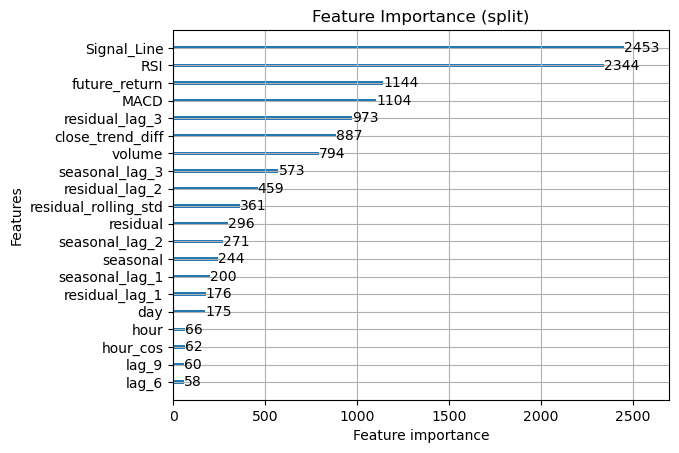

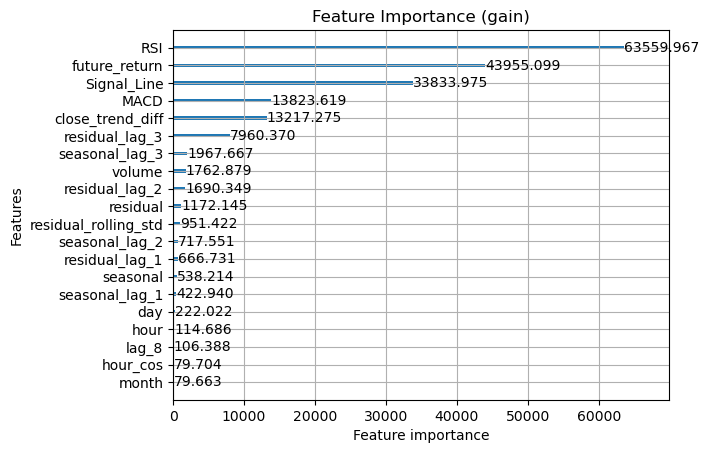

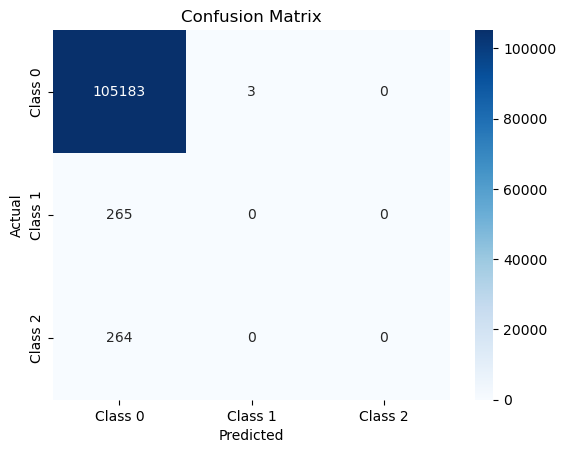

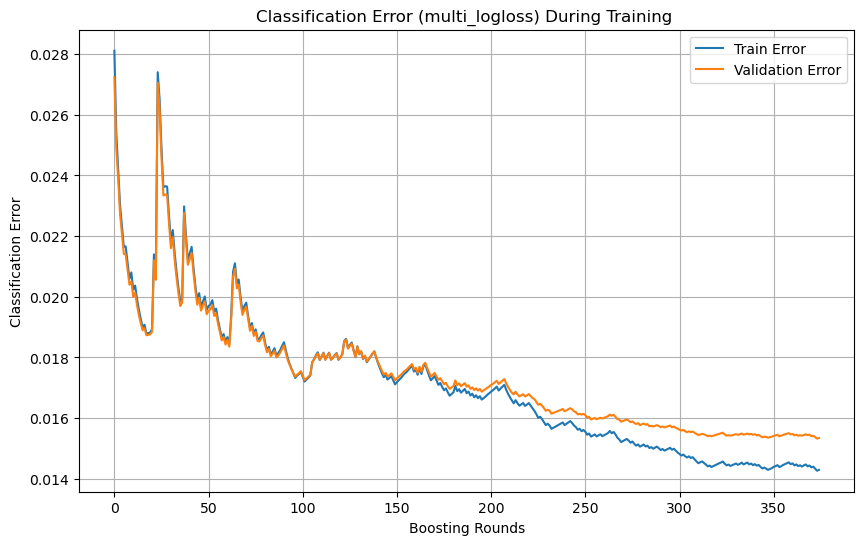


Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes

ROC-AUC Score: 0.9921556906096556
ROC-AUC per class [0, 1, 2]: [0.98822238 0.99433053 0.99391416]


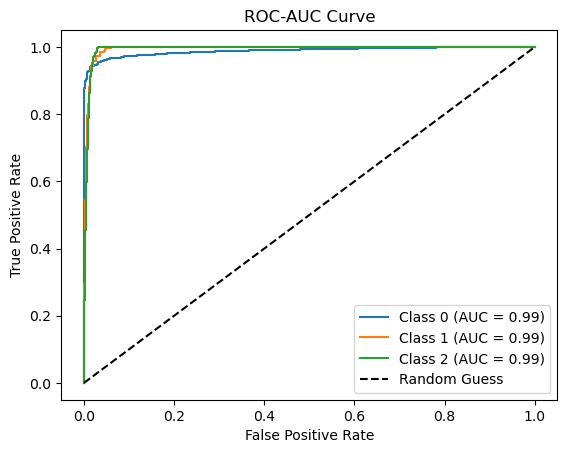

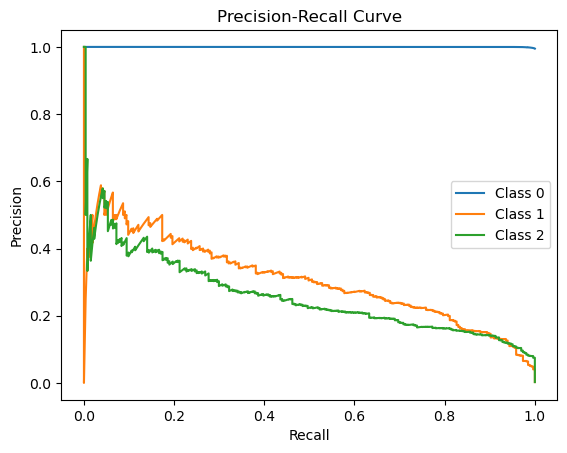

In [244]:
start_mlflow_run(mlflow_run_name)

In [209]:
#evaluate_model(lgb_model, attributes_test, target_test)

In [ ]:
start_mlflow_run(mlflow_run_name)